# Popularity Prediction of User-Posts 
# on the website of Austrian Newspaper 'Der Standard'

This noteboook deal with the challenge of prediction the popularity (measured by up- and downvotes) of user-posts in the comments-section under articles of the Austrian Newspaper 'Der Standard'.

## Step 0: Set Up

In [1]:
 #!pip install jupyter_contrib_nbextensions
 #!jupyter contrib nbextension install --user
#!pip install pydot --user
# python -m pip install pydot --user
#!pip install graphviz --user
#!pip install tqdm --user
#!pip install powerlaw
#!pip install pytesseract --user

### Step 0.1 Load Libraries

As a first step we load in the necessary libraries that we will use to accomplish this task.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from numpy import std
import sqlite3
from transformers import pipeline
from math import ceil
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind, mannwhitneyu, pointbiserialr

# for tracking time
from tqdm import tqdm
tqdm.pandas()


# Graphics and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import textwrap
from tabulate import tabulate
from matplotlib.table import Table
from textwrap import wrap


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
# deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, concatenate, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from transformers import BertTokenizer, TFBertModel


# Text processing
import re
import string
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# statistical testing
from scipy.stats import ttest_ind, mannwhitneyu, pointbiserialr
import powerlaw
from scipy.stats import probplot, shapiro

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


# spacy language model for lemmatization and POS tagging
import spacy
nlp = spacy.load("de_core_news_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Step 0.2 Load Data

In [2]:
# Relative path to the SQLite database file
database_file = "./data/corpus.sqlite3"

# Connect to the database
conn = sqlite3.connect(database_file)

# Query to fetch the first 100,000 rows from a table named 'your_table_name'
query = "SELECT * FROM Posts"

# Load data into a DataFrame
df_posts = pd.read_sql_query(query, conn)
df_articles = pd.read_sql_query("SELECT * FROM Articles", conn)

# Close the connection
conn.close()


In [3]:
print("Initial Number of Posts", df_posts.shape[0])

Initial Number of Posts 1011773


## Step 1: Preprocessing

###  Step 1.0 Merging, Filtering & Ordering

In [4]:
# Extracting the subtitle from the articles body
def extract_subtitle(html_content):
    match = re.search(r'<h2.*?>(.*?)<\/h2>', html_content)
    return match.group(1) if match else " "
df_articles['Subtitle'] = df_articles['Body'].apply(extract_subtitle)


df_articles['Subtitle'] = df_articles['Body'].apply(extract_subtitle)
# Merge the two DataFrames based on the 'ID_Article' column


# Extract the text after the subtitle from the article body
def extract_text_after_subtitle(html_content):
    match = re.search(r'<h2.*?>(.*?)<\/h2>(.*)', html_content, re.DOTALL)
    return match.group(2).strip() if match else html_content  # Return full body if no subtitle is found

# Add a new column for the processed article body
df_articles['ArticleBody'] = df_articles['Body'].apply(extract_text_after_subtitle)
columns_to_merge = df_articles.columns[df_articles.columns != 'Body']

df_merged = pd.merge(df_posts, df_articles[columns_to_merge], on='ID_Article')


### Step : Filtering Empty Posts and Posts with too few  Votes

In [199]:
# Fill NaN values in 'Headline' and 'Body' with an empty string, then strip whitespace
df_merged['Headline'] = df_merged['Headline'].fillna('').str.strip()
df_merged['Body'] = df_merged['Body'].fillna('').str.strip()

# Remove rows where both 'Body' and 'Headline' are empty
initial_row_count = len(df_posts)
df_merged = df_merged[~((df_merged['Body'] == '') & (df_merged['Headline'] == ''))]
rows_removed = initial_row_count - len(df_merged)
print(f"Number of posts removed due to missing Body and Headline: {rows_removed}")


# Remove rows that have a status 
if 'Status' in df_merged.columns:
    # Count the number of replies for each post and save it as new feature
    initial_row_count = len(df_merged)
    df_merged = df_merged[~(df_merged['Status'] == 'deleted')]
    rows_removed = initial_row_count - len(df_merged)
    print(f"Number of posts removed since they have been banned in the past: {rows_removed}")
    df_merged.drop(columns='Status', inplace=True)


# Create the 'TotalVotes' column
df_merged['TotalVotes'] = df_merged['PositiveVotes'] + df_merged['NegativeVotes']

# Rename other votes
df_merged.rename(columns={'PositiveVotes': 'UpVotes', 'NegativeVotes': 'DownVotes'}, inplace=True)
df_posts.rename(columns={'PositiveVotes': 'UpVotes', 'NegativeVotes': 'DownVotes'}, inplace=True)

# Generate feature article_post_count
df_merged['article_post_count'] = df_merged['ID_Article'].map(df_merged['ID_Article'].value_counts())
df_merged['article_vote_count'] = df_merged['ID_Article'].map(df_merged.groupby('ID_Article')['UpVotes'].sum())
df_merged['article_vote_median'] = df_merged['ID_Article'].map(df_merged.groupby('ID_Article')['UpVotes'].median())

# Remove rows that where posted under an article where none of the posts got any votes
initial_row_count = len(df_merged)
df_merged = df_merged[~(df_merged['article_vote_count'] == 0)]
rows_removed = initial_row_count - len(df_merged)
print(f"Number of posts removed due to missing Votes: {rows_removed}")

Number of posts removed due to missing Body and Headline: 7
Number of posts removed since they have been banned in the past: 62313
Number of posts removed due to missing Votes: 1554


### Generate New Columns - FullText, Total Votes, Negative-Positive Votes Ratio and more

In [200]:
# Shuffle the dataset and reset index
df_merged = df_merged.sample(n=len(df_merged))
df_merged = df_merged.reset_index(drop=True)


# Create Full Text column
df_merged['FullText'] = df_merged['Headline'] + ' ' + df_merged['Body']
df_merged['FullText'] = df_merged['FullText'].str.strip()

df_merged['ShareOfVotes'] =  df_merged['UpVotes']  / df_merged['article_vote_count'] 

# First, sort by 'ArticleID' (or equivalent column name) and then by 'ShareOfVotes' in descending order within each article
df_merged = df_merged.sort_values(by=['ID_Article', 'ShareOfVotes'], ascending=[True, True]).reset_index(drop=True)
# Calculate cumulative vote within each article group
df_merged['CumulativeVotes'] = df_merged.groupby('ID_Article')['ShareOfVotes'].cumsum()
# Correct the cumulative vote
# For each article group, assign the maximum cumulative vote 
df_merged['CumulativeVotes'] = df_merged.groupby(['ID_Article', 'UpVotes'])['CumulativeVotes'].transform('max')


df_merged['TitleLength'] = df_merged['Headline'].str.len()
df_merged['BodyLength'] = df_merged['Body'].str.len()
# Calculate the ratio of HeadlineLength to BodyLength
# Handle division by zero if BodyLength is 0
df_merged['TitleToBodyRatio'] = df_merged.apply(
    lambda row: 0 if row['TitleLength'] == 0 and row['BodyLength'] != 0 else
                1 if row['TitleLength'] > row['BodyLength'] else
                row['TitleLength'] / row['BodyLength'], axis=1)
df_merged[['Headline', 'Body','TitleLength', 'BodyLength', 'TitleToBodyRatio']].head(3).style


# Create a new column for the ratio of Negative to Positive Votes
# Define conditions
conditions = [
    (df_merged['UpVotes'] > 0) & (df_merged['DownVotes'] == 0),  # Only positive votes
    (df_merged['DownVotes'] > 0) & (df_merged['UpVotes'] == 0),  # Only negative votes
    (df_merged['UpVotes'] == df_merged['DownVotes']),            # Equal positive and negative votes
    (df_merged['UpVotes'] > df_merged['DownVotes']),             # More positive votes
    (df_merged['DownVotes'] > df_merged['UpVotes'])              # More negative votes
]
# Define corresponding values for each condition
values = [
    1,  # Only positive votes
    -1,  # Only negative votes
    0,  # Equal positive and negative votes
    ((df_merged['UpVotes'] / df_merged['TotalVotes']) - 0.5)*2,  # Positive outnumber negative
    ((-(df_merged['DownVotes'] / df_merged['TotalVotes']) + 0.5))*2  # Negative outnumber positive
]
# Create the new column 'Neg_Pos_Score'
df_merged['Neg_Pos_Score'] = np.select(conditions, values, default=0)
df_merged['Neg_Pos_Score_Rel'] = df_merged['Neg_Pos_Score'] * df_merged['TotalVotes']

if 'ID_Parent_Post' in df_merged.columns:
    # Count the number of replies for each post and save it as new feature
    reply_counts = df_merged.groupby('ID_Parent_Post').size()
    df_merged['Number_of_Replies'] = df_merged['ID_Post'].map(reply_counts).fillna(0).astype(int)
    df_merged['IsReply'] = (df_merged['ID_Parent_Post'].fillna('none') != 'none').astype(int)
    #df_merged.drop(columns='ID_Parent_Post', inplace=True)

#looking at come examples
df_merged[["UpVotes", "DownVotes", "TotalVotes", "Neg_Pos_Score", 
           "Neg_Pos_Score_Rel", "Number_of_Replies", "article_vote_count", 
           "article_post_count"]].tail(10)

,UpVotes,DownVotes,TotalVotes,Neg_Pos_Score,Neg_Pos_Score_Rel,Number_of_Replies,article_vote_count,article_post_count
947889,0,1,1,-1.000000,-1.0,0,32,12
947890,0,0,0,0.000000,0.0,1,32,12
947891,0,0,0,0.000000,0.0,1,32,12
947892,1,0,1,1.000000,1.0,1,32,12
947893,1,0,1,1.000000,1.0,0,32,12
947894,2,3,5,-0.200000,-1.0,1,32,12
947895,3,1,4,0.500000,2.0,0,32,12
947896,4,2,6,0.333333,2.0,3,32,12
947897,10,1,11,0.818182,9.0,0,32,12
947898,11,0,11,1.000000,11.0,3,32,12


#### Generate a column for the main category of the article

In [201]:
df_merged['MainTopicPath'] = df_merged["Path"].str.split("/").str[1]
print(df_merged['MainTopicPath'].value_counts().to_string())


Panorama                     170393
Inland                       158671
Wirtschaft                   116936
Web                          105534
International                103679
Sport                         93999
Kommentare                    31476
Etat                          23559
Wissenschaft                  21455
User                          17689
Gesundheit                    15064
Kolumnen                      14941
Kultur                        13266
Lifestyle                     10557
KdA                            8604
Karriere                       7761
Familie                        6001
Reisen                         4985
AutoMobil                      4414
Immobilien                     4036
diePolitik                     3443
fsmisik                        3394
Geschlechterverhaeltnisse      1665
diewissenschaft                1380
diebildung                      899
diemeinung                      840
diealltag                       838
diekultur                   

In [202]:
# Filter for articles with a post count between 10 and 20
filtered_df = df_merged[(df_merged["article_post_count"] > 10) & (df_merged["article_post_count"] < 12)]
# Group by article_id and select one group where all posts share the same article_id
example_article_id = filtered_df["ID_Article"].value_counts().idxmax()
example_df = filtered_df[filtered_df["ID_Article"] == example_article_id]

# Display the desired columns for the top 20 rows of the selected example
example_df[["ID_Article", "FullText", "UpVotes", 
            "article_vote_count", "ShareOfVotes", "CumulativeVotes"]].sort_values(by="CumulativeVotes", ascending=False).style

,ID_Article,FullText,UpVotes,article_vote_count,ShareOfVotes,CumulativeVotes
3595,26,"Warum findet sich der Artikel im Web- und nicht im Wirtschaftsressort? Achso, Apple steht acht mal in einem Artikel, deshalb geht es ja nicht um Auto- oder Pharmafirmen bzw generell eh alle, sondern die IT-Branche ;)",28,64,0.437500,1.000000
3594,26,weil das webressort mehr leser hat,17,64,0.265625,0.562500
3593,26,"Auch wenn das der Fall wäre, ist das keine Begründung. Entweder gehört ein Artikel zum Wirtschaftsressort oder nicht. Dieser Artikel gehört eindeutig zum Wirtschaftsressort.",6,64,0.093750,0.296875
3592,26,"Danke das du das jetzt geklärt hast. Weiter so, sorge für Ordnung!! ;)",5,64,0.078125,0.203125
3591,26,kaputtalismus eben. jetzt bekommen nicht mal die aktionäre cash. das bekommt jatzt nur mehr diejenige heuschrecke die ein U ausschlachtet,3,64,0.046875,0.125000
3589,26,"Andererseits kann man mit der Logik den Artikel in jedes Resort stecken: International weil es sich um Ausländische Firmen handelt Inland weil es deren Produkte auch bei uns zu kaufen gibt Wirtschaft liegt auf der Hand Web weil Apple drin vorkommt Sport weil viele Sportler auf die Pharmaindustrie angewiesen sind Etat weil man das Product Placing eh ständig in Filmen/ Serien sieht Kultur weil GM & Apple durch ihr Markenbild Kundengruppen vermitteln wollen, dass ihr Produkt etwas erstrebenswertes mit künstlerischem Aspekt ist Wissenschaft weil Pharmazie dabei ist Gesundheit -''- Reisen weil man mit GM Autos fortfahren kann Lifestyle weil manche Produkte der Firmen das darstellen sollen Familie weil die Kinder auch gerne ein iPhone hätten",2,64,0.031250,0.078125
3590,26,"ja eh, und?",2,64,0.031250,0.078125
3588,26,"Es ist ja schon mal ein Fortschritt, daß der Artikel nicht unter ""Innovationen"" ist. Haben Sie Geduld ...",1,64,0.015625,0.015625
3585,26,"Ein klarer Fall, wo Cross-Posting sinnvoll ist. Im Zeitalter des Hyperlinks könnte man ja einfach in beiden Ressorts auf den Artikel verlinken.",0,64,0.000000,0.000000
3586,26,"Finde ich auch, aber es gibt die IT-Business Unterrubrik, und da ist es jetzt nicht ganz falsch.",0,64,0.000000,0.000000


### Filtering

In [10]:
# Select subsets based on the Neg_Pos_Score condition
#negative_ratio = df_merged[ (df_merged['Neg_Pos_Score'] < 0) &  (df_merged['TotalVotes'] > 2) ].head(8000).copy()
#zero_ratio = df_merged[(df_merged['Neg_Pos_Score'] == 0) &  (df_merged['TotalVotes'] > 2)].head(8000).copy()
#positive_ratio = df_merged[(df_merged['Neg_Pos_Score'] > 0) &  (df_merged['TotalVotes'] > 2)].head(8000).copy()

# Combine the subsets into one dataset
#combined_dataset = pd.concat([negative_ratio, zero_ratio, positive_ratio], ignore_index=True)
#combined_dataset.shape
#df_merged = combined_dataset

In [11]:
#zero_ratio.shape

In [12]:
# Set display option to show all rows
#pd.set_option('display.max_rows', None)

# Print all entries of the value counts
#print(df_merged['Path'].value_counts())

# Reset display option to default (if needed)
#pd.reset_option('display.max_rows')

In [13]:
#filtered_df = df_merged[df_merged['TotalVotes']>=5].copy()
#print(filtered_df.shape)
#filtered_df['article_post_count'] = filtered_df['ID_Article'].map(filtered_df['ID_Article'].value_counts())

#filtered_df = df_merged[df_merged['article_post_count']>=10].copy()
#print(filtered_df.shape)

In [14]:
# Step 1: Get unique article IDs and shuffle
#unique_article_ids = df_merged['ID_Article'].unique()
#np.random.shuffle(unique_article_ids)

# Step 2: Initialize variables to store selected articles and count posts
#selected_article_ids = []
#total_posts_count = 0
#target_posts_count = 40000  # target number of posts

# Step 3: Select articles until we reach the desired post count
#for article_id in unique_article_ids:
    # Get posts for the current article
 #   article_posts = df_merged[df_merged['ID_Article'] == article_id]
  #  article_post_count = len(article_posts)

    # Check if adding this article would exceed the target count
   # if total_posts_count + article_post_count > target_posts_count:
    #    break  # Stop if we exceed the limit

    # Add article and update counters
    #selected_article_ids.append(article_id)
    #total_posts_count += article_post_count

# Step 4: Filter the dataframe to include only posts from selected articles
#df_selected = df_merged[df_merged['ID_Article'].isin(selected_article_ids)]

# Step 5: Remove selected rows from df_merged
#df_merged = df_merged[~df_merged['ID_Article'].isin(selected_article_ids)]

# Check the results
#print(f"Selected {len(df_selected)} posts from {len(selected_article_ids)} articles.")
#print(f"Remaining {len(df_merged)} posts in df_merged.")

# Find overlaps and differences
#overlapping_ids = set(df_merged['ID_Article'].unique()).intersection(set(df_selected['ID_Article'].unique()))
#print(f"Overlapping article IDs: {overlapping_ids}")


In [15]:
#df_merged = df_selected.copy()

In [16]:
#filtered_df = df_merged
#news_room_df = filtered_df[ (filtered_df['Path'].str.startswith("Newsroom/Inland/bundespraesi")) | 
 #                          (filtered_df['Path'].str.startswith("Newsroom/Inland/bundespraesi")) ].copy()
#print(news_room_df.shape)
#df_merged = news_room_df.copy()

In [17]:
# Set display option to show all rows
#pd.set_option('display.max_rows', None)

# Print all entries of the value counts
#print(df_merged['Path'].value_counts())

# Reset display option to default (if needed)
#pd.reset_option('display.max_rows')

###  Step 1.1 Data Cleaning

In [203]:
# Preprocessing step to replace None with empty strings
df_merged['Body'] = df_merged['Body'].fillna('')
df_merged['Headline'] = df_merged['Headline'].fillna('')
# Ensure columns are numeric
df_merged['UpVotes'] = pd.to_numeric(df_merged['UpVotes'], errors='coerce')
df_merged['DownVotes'] = pd.to_numeric(df_merged['DownVotes'], errors='coerce')
# Convert 'CreatedAt' and 'publishingDate' columns to datetime format
df_merged['CreatedAt'] = pd.to_datetime(df_merged['CreatedAt'], errors='coerce')
df_merged['publishingDate'] = pd.to_datetime(df_merged['publishingDate'], errors='coerce')
# Convert 'ID_Article' columns to numeric 
df_merged['ID_Article'] = pd.to_numeric(df_merged['ID_Article'], errors='coerce')

def clean_text(text):
    
    #removing websites (set a flag for ignoring the case that they are writtin in)
    text = re.sub(
        (
            r'(ht+ps*\s*:*\s?\/+(upload\.|de\.|en\.)*|w+\s*\.|w+\s*\.ris\.*|m+\s*\.)+'
            r'\s*(\w+-*\w*-*\w*)(.gv|.europa)*\.*\s*(com|tv|info|co|at|eu|adww|de|ch|uk|org|net|ee)'
            r'(\s*\/\s*\S*)*'
        ),
        r' \3Link ',
        text,
        flags=re.I
    )

    # Add spaces around special characters
    # for example to turn "und/oder" into "und / oder"
    # which is a thing tokenizers often fail to do
    text = re.sub(r'(\w)/(\w)', r'\1 / \2', text) 
    text = re.sub(r'(\w)\\(\w)', r'\1 \\ \2', text)
    
    return text

# Apply text cleaning to the 'Full_Text' column
df_merged['CleanedText'] = df_merged['FullText'].progress_apply(lambda text: pd.Series(clean_text(text)))


100%|████████████████████████████████████████████████████████████████████████| 947899/947899 [10:40<00:00, 1480.00it/s]


In [204]:
# Filter rows where 'fulltext' contains the pattern "www"
df_merged[df_merged['FullText'].str.contains('www', case=False, na=False)][['FullText', 'CleanedText']].head(5).style

,FullText,CleanedText
100,http://www.regenbogenwald.de/themen/mps/,regenbogenwaldLink
151,http://www.linkshaendershop.at/13-dosenoeffner,linkshaendershopLink
202,Sowas? http://www.ikea.com/at/de/catalog/products/70149465/,Sowas? ikeaLink
226,Ich war wohl einer der letzten Linkshänder die umgelernt wurden. Also schlechte Erfahrungen. http://www.linkshaenderberatungsstelle.de/folg.htm,Ich war wohl einer der letzten Linkshänder die umgelernt wurden. Also schlechte Erfahrungen. linkshaenderberatungsstelleLink
228,"flöte für linkshänder? http://www.moeck.com/cms/index.php?id=202 wie passend, gerade die hier zu präsentieren. z.b. bei gitarren ist der unterschied ungleich massiver. denkanstoss am rande: wie handhaben das in einem gemischten haushalt: haben sie jedes werkzeug doppelt, oder muss sich doch wieder einer umtrainieren?","flöte für linkshänder? moeckLink wie passend, gerade die hier zu präsentieren. z.b. bei gitarren ist der unterschied ungleich massiver. denkanstoss am rande: wie handhaben das in einem gemischten haushalt: haben sie jedes werkzeug doppelt, oder muss sich doch wieder einer umtrainieren?"


In [205]:
# Filter rows where 'fulltext' contains the word "youtube" 
df_merged[df_merged['CleanedText'].str.contains('youtube', case=False, na=False)][['FullText', 'CleanedText']].head(2).style

,FullText,CleanedText
632,das war eine unserer hymnen damals: https://www.youtube.com/watch?v=iD77vPD-zCQ,das war eine unserer hymnen damals: youtubeLink
660,"""Man weiss es ..."" siehe Tango Korrupti aus dem Jahr 1989 von Reinhard Fendrich: https://www.youtube.com/watch?v=RhZKGlDQXr8","""Man weiss es ..."" siehe Tango Korrupti aus dem Jahr 1989 von Reinhard Fendrich: youtubeLink"


In [207]:
df_merged.shape

(947899, 30)

### Step 1.2 Parsing Operation Lemmatization, POS-Tagging & NER-recognition

In [208]:
def normalize_text_with_lemmatization(doc):
    """
    Normalize text by lemmatizing verbs, nouns, and auxiliary words, 
    while keeping other tokens unchanged.
    """
    return " ".join(
        token.lemma_ if token.pos_ in {"VERB", "NOUN", "AUX"} else token.text
        for token in doc
    )

def calculate_AvgParseTreeHeight(doc):
    """
    Calculate the average parse tree height for a given SpaCy Doc object.
    """
    total_parse_depth = sum(len(list(token.ancestors)) for token in doc)
    num_tokens = len(doc)
    return total_parse_depth / num_tokens if num_tokens > 0 else 0

def extract_named_entities(doc):
    """
    Extract named entities from a SpaCy Doc object as a list of entity strings.
    """
    return [ent.text for ent in doc.ents]

def count_modal_verbs(doc):
    """
    Count the number of modal verbs in the text.
    """
    return sum(1 for token in doc if token.tag_ == "VMFIN")  # Specific to German; adjust for other languages

def parse_text(text):
    """
    Parse the text with SpaCy once and compute features:
    normalized text, average parse tree height, named entities, and modal verb count.
    """
    doc = nlp(text.strip())
    AvgParseTreeHeight = calculate_AvgParseTreeHeight(doc)
    normalized_text = normalize_text_with_lemmatization(doc)
    #additional custom normalization 
    normalized_text = re.sub(r'\b(dank(e)*(schön)*)\b',
                  ' Danke ', normalized_text, flags=re.I)
    entities = extract_named_entities(doc)
    modal_verbs_count = count_modal_verbs(doc)
    return normalized_text, AvgParseTreeHeight, entities, modal_verbs_count

def parse_and_generate_features(df, entity_limit=80):
    """
    Preprocess text data to compute features and generate one-hot encoded columns for top entities.
    """
    df[["CleanedText", "AvgParseTreeHeight", "entities", "ModelVerbs_Freq"]] = df["CleanedText"].progress_apply(
        lambda x: pd.Series(parse_text(x))
    )
    
    all_entities = [entity for entities in df["entities"] for entity in entities]
    entity_counter = Counter(all_entities)
    
    # Select the top N entities
    top_entities = [entity for entity, _ in entity_counter.most_common(entity_limit)]
    
    # Create one-hot encoded columns for the top entities
    for entity in top_entities:
        df[f"NE_{entity}"] = df["entities"].apply(lambda ents: 1 if entity in ents else 0)
    df = df.drop(columns=["entities"])
    return df

# Sample data to demonstrate how the functions work
data = {
    "FullText": [
        "Es gibt auch andere Möglichkeiten, gegen die schlechte Politik der Regierung zu protestieren.",
        "Facebook wird von vielen genutzt, auch von rechten Islamisten!",
        "welche rechten Islamisten haben da kandidiert ?",
    ],
    "CleanedText": [
        "Es gibt auch andere Möglichkeiten, gegen die schlechte Politik der Regierung zu protestieren.",
        "Facebook wird von vielen genutzt, auch von rechten Islamisten!",
        "welche rechten Islamisten haben da kandidiert ?",
    ]
}
test_df = pd.DataFrame(data)
test_df = parse_and_generate_features(test_df, entity_limit=80)
test_df.style

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 30.42it/s]


,FullText,CleanedText,AvgParseTHeight,ModelVerbs_Freq,NE_Regierung,NE_Facebook
0,"Es gibt auch andere Möglichkeiten, gegen die schlechte Politik der Regierung zu protestieren.","Es geben auch andere Möglichkeit , gegen die schlechte Politik der Regierung zu protestieren .",2.800000,0,1,0
1,"Facebook wird von vielen genutzt, auch von rechten Islamisten!","Facebook werden von vielen nutzen , auch von rechten Islamist !",2.000000,0,0,1
2,welche rechten Islamisten haben da kandidiert ?,welche rechten Islamist haben da kandidieren ?,1.285714,0,0,0


In [209]:
# apply it on the real dataset
df_merged = parse_and_generate_features(df_merged, entity_limit=80)

100%|████████████████████████████████████████████████████████████████████████| 947899/947899 [3:17:55<00:00, 79.82it/s]


In [5]:
# save or reload the dataframe - as a checkpoint
#df_merged.to_pickle("./data/df_merged_version1.pkl")
df_merged = pd.read_pickle("./data/df_merged_version1.pkl")

In [6]:
df_merged.shape

(947899, 76)

In [221]:
# look at the generated entities

def print_all_entities(df):
    generated_entities = []
    for column in df.columns:
        if column[:3] == "NE_":
            generated_entities.append(column)
    # Sort the list alphabetically
    generated_entities.sort(key=str.lower)

    # Output the list
    print(generated_entities)
    return generated_entities

generated_entities = print_all_entities(df_merged)

['NE_Apple', 'NE_Assad', 'NE_Bayern', 'NE_China', 'NE_deutsche', 'NE_Erdogan', 'NE_EU', 'NE_Europa', 'NE_Faymann', 'NE_FPÖ', 'NE_Frankreich', 'NE_Griechen', 'NE_Hofer', 'NE_Irak', 'NE_Iran', 'NE_IS', 'NE_Islam', 'NE_Israel', 'NE_Italien', 'NE_Kärnten', 'NE_Merkel', 'NE_ORF', 'NE_Rapid', 'NE_Russen', 'NE_Russland', 'NE_Salzburg', 'NE_Schweden', 'NE_Schweiz', 'NE_SPÖ', 'NE_Staaten', 'NE_Strache', 'NE_Syrien', 'NE_TTIP', 'NE_Türkei', 'NE_Ukraine', 'NE_Ungarn', 'NE_USA', 'NE_VdB', 'NE_Wien', 'NE_Wiener', 'NE_Zeit', 'NE_Österreich', 'NE_ÖVP', 'NE_€']


In [222]:
# summarize entities that are nearly the same (such as Österreich, Österreichisch)
previous_entity = ""
for column in generated_entities:
    if column[:3] == "NE_":
        if previous_entity[:9].lower() == column[:9].lower():
            df_merged[previous_entity] = df_merged[previous_entity] + df_merged[column]
            df_merged.drop(columns=[column], inplace=True)
            print(f"Summarized {previous_entity} and  {column}")    
        else:
            previous_entity = column


In [214]:
# remove some enitites that actually are none
entities_to_remove = ['NE_bisschen', 'NE_Bürger', 'NE_Danke', 
                      'NE_denke', 'NE_Du', 'NE_gibts',  'NE_Hause', 'NE_Internet', 
                      'NE_Krieg', 'NE_Land',  'NE_mich', 'NE_mir', 'NE_Na', 'NE_Naja', 'NE_naja', 'NE_Nein', 
                      'NE_nein', 'NE_NICHT',  'NE_Partei',  'NE_Sorry', 'NE_“', 'NE_' ]
try:
    for entity in entities_to_remove:
        try:
            df_merged.drop(columns = [entity], inplace = True)
        except:
            pass
    df_merged["NE_deutsche"] = df_merged["NE_D"] + df_merged["NE_deutsche"]
    df_merged.drop(columns=["NE_D"], inplace=True)
    df_merged["NE_Österreich"] = df_merged["NE_Ö"] + df_merged["NE_Österreich"]
    df_merged.drop(columns=["NE_Ö"], inplace=True)
    df_merged["NE_Europa"] = df_merged["NE_europäischen"] + df_merged["NE_Europa"]
    df_merged.drop(columns=["NE_europäischen"], inplace=True)
    df_merged["NE_Griechen"] = df_merged["NE_GR"] + df_merged["NE_Griechen"]
    df_merged.drop(columns=["NE_GR"], inplace=True)
    df_merged["NE_USA"] = df_merged["NE_den USA"] + df_merged["NE_USA"]
    df_merged.drop(columns=["NE_den USA"], inplace=True)
except:
    pass

_ = print_all_entities(df_merged)

['NE_Apple', 'NE_Assad', 'NE_Bayern', 'NE_China', 'NE_deutsche', 'NE_Erdogan', 'NE_EU', 'NE_Europa', 'NE_Faymann', 'NE_FPÖ', 'NE_Frankreich', 'NE_Griechen', 'NE_Hofer', 'NE_Irak', 'NE_Iran', 'NE_IS', 'NE_Islam', 'NE_Israel', 'NE_Italien', 'NE_Kärnten', 'NE_Merkel', 'NE_ORF', 'NE_Rapid', 'NE_Russen', 'NE_Russland', 'NE_Salzburg', 'NE_Schweden', 'NE_Schweiz', 'NE_SPÖ', 'NE_Staaten', 'NE_Strache', 'NE_Syrien', 'NE_TTIP', 'NE_Türkei', 'NE_Ukraine', 'NE_Ungarn', 'NE_USA', 'NE_VdB', 'NE_Wien', 'NE_Wiener', 'NE_Zeit', 'NE_Österreich', 'NE_ÖVP', 'NE_€']


In [223]:
df_merged[['FullText', 'CleanedText', 'AvgParseTreeHeight']].head(4).style

,FullText,CleanedText,AvgParseTreeHeight
0,"Kultur!! Ja, über einen wöchentlichen kultir newsletter würde ich mich auch freuen!!!","Kultur ! ! Ja , über einen wöchentlichen kultir newsletter werden ich mich auch freuen ! ! !",1.777778
1,"Ja, unglaublich laestig... Hab mich auch gerade abgemeldet...","Ja , unglaublich laestig ... Hab mich auch gerade abmelden ...",1.181818
2,"Wenn ich in meinen Einstellungen oder hier meine Newsletter Abos veränder,und dann speicher,wird das Fenster ""dunkel"" und zeigt nichts an,und ändert die Abos nicht :-(","Wenn ich in meinen Einstellung oder hier meine Newsletter Abos veränder , und dann speicher , werden das Fenster "" dunkel "" und zeigen nichts an , und ändern die Abos nicht :-(",2.727273
3,Bitte ich möchte keine Mails mehr kriegen. Deaktivieren Sie mir diese sch..ß Newsletter. Da kenn sich kein schwein aus wie mann das macht. Danke und auf nieee wiedersehen.,Bitte ich mögen keine Mails mehr kriegen . Deaktivieren Sie mir diese sch .. ß Newsletter . Da kenn sich kein schwein aus wie mann das machen . Danke und auf nieee wiedersehen .,1.382353


###  Step 1.3 Remove Stopwords & Generate Stopword-Features

In [224]:
custom_german_stopwords = ['aber','ab','aha', 'aso', 'achso', 'ach', 'als','also','am','an','ander', 'andere', 'anderem', 
                           'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'auch','auf','aus',
                           'bei', 'bin', 'bis', 'bist', 'bzw', 'beim', 'bei', 'breits',
                           'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'darüber',
                           'dazu', 'dafür', 'derselbe', 'derselben', 'denselben', 'desselben', 'demselben', 'denen',
                           'dieselbe', 'dieselben', 'dasselbe', 'denn', 'derer','dessen', 'dies', 'diese', 'diesem', 
                           'diesen', 'dieser', 'dieses', 'doch','dort', 'durch',  'du', 
                           'eben', 'ein', 'eigentlich', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig',  
                           'einigem', 'einmal',
                           'einigen', 'einiger', 'einiges',  'es', 'etwas', 'eher', 'eh', 'echt', 'erst', 'etc', 'er',
                           'für', 'fast', 
                           'genau', 'gar', 'ganz', 'geht', 'gehört', 'gemacht', 'gerade', 'gehen', 
                           'gesehen', 'gesehn', 'ganze',
                           'halt', 'hier','hierzu', 'hin', 'haben', 'hat',
                           'ihr', 'ihre', 'ihrem', 'ihn',
                           'ihren', 'ihrer','ihres', 'im', 'in', 'indem', 'ins', 'irgend', 'irgendwas', 'irgendwie', 
                           'irgendwer', 'ist','is', 'ja', 
                           'jede',  'jene', 'jenem', 'jenen', 'jener', 'jenes', 'jetzt', 
                           'klar', 'kommt', 'lassen', 'lasst', 'lass', 'lieber',
                           'mit', 'mal', 'mehr', 'mir', 'mein',
                           'natürlich', 'na', 'nach', 'nun', 'noch', 'nur', 'man',
                           'ob', 'obwohl', 'oder', 'ohne', 'ohnehin', 
                           'paar',
                           'schon', 'sehr', 'so', 'sozusagen', 'somit','solche', 'solchem', 'solchen', 
                           'solcher', 'solches', 'sowieso', 'sondern', 'sind', 'sich', 'sieht', 'sonst', 'sehen', 'sicher',
                           'sowas',
                           'tatsächlich',
                           'über', 'um', 'und', 'überhautpt', 'unter'
                           'viel', 'vom', 'von','vor',
                           'während', 'was', 'wegen', 'weil', 'weiter', 'welche', 'welchem', 'welchen', 'wobei', 'wieso'
                           'welcher','welches', 'wenn', 'wie', 'wieder', 'wohl', 'wird', 'werden', 'wodurch', 'wo',
                           'weshalb', 'warum', 'wieso', 'weit','wer',
                           'zu', 'zum', 'zur', 'zwar', 'zwischen', 'ziemlich',
                            # other words
                            'artikel', 'inhalt', 'post', 'beitrag'
                           # common verbs
                           'seien', 'haben', 'habe', 'können', 'sollen', 'soll', 'müssen', 'werden', 'gehen',  'machen',
                           'helfen', 'bringen', 'wollen', 'brauchen', 'tun', 'sagen', 'bleiben',
                           'sein', 'hab', 'gibt', 'gibts', 'kommen', 'dürfen', 'gelten'
]

def remove_stopwords(text):
    """
    Function to remove stopwords and calculate stopword ratio
    """
     # remove Pronouns and related patterns
    text = re.sub(r'\b(ich|mich|mir|mein(e|r)*|sei(e|n|r)*|wir|uns(e|r)*|ihr|euch|euer(e|r)*|sie|ihnen|ihr(e|r)*)\b',
                  '', text, flags=re.I)
    
    
    # remove digits
    text = re.sub(r'\d', '', text, flags=re.I)
    
    words = word_tokenize(text)  # Tokenize text using NLTK's tokenizer
    stopword_count = sum(1 for word in words if word.lower() in custom_german_stopwords)
    total_words = len(words)
    stopword_ratio = stopword_count / total_words if total_words > 0 else 0
    # Remove stopwords for cleaned FullText
    filtered_words = [word for word in words if word.lower() not in custom_german_stopwords]
    cleaned_text = ' '.join(filtered_words)
    
    
    return cleaned_text, stopword_ratio, stopword_count

# Initialize tqdm for progress tracking
tqdm.pandas()

# Apply text processing to the FullText column with progress bar
df_merged[['CleanedText', 'StopWordsRatio', 'StopWord_Freq']] = df_merged['CleanedText'].progress_apply(
    lambda text: pd.Series(remove_stopwords(text))
)


# looking at some examples
df_merged[["FullText", "CleanedText", "StopWordsRatio"]].head(4).style

100%|█████████████████████████████████████████████████████████████████████████| 947899/947899 [17:27<00:00, 905.19it/s]


,FullText,CleanedText,StopWordsRatio
0,"Kultur!! Ja, über einen wöchentlichen kultir newsletter würde ich mich auch freuen!!!","Kultur ! ! , wöchentlichen kultir newsletter freuen ! ! !",0.312500
1,"Ja, unglaublich laestig... Hab mich auch gerade abgemeldet...",", unglaublich laestig ... abmelden ...",0.400000
2,"Wenn ich in meinen Einstellungen oder hier meine Newsletter Abos veränder,und dann speicher,wird das Fenster ""dunkel"" und zeigt nichts an,und ändert die Abos nicht :-(","meinen Einstellung Newsletter Abos veränder , speicher , Fenster `` dunkel `` zeigen nichts , ändern Abos nicht : - (",0.363636
3,Bitte ich möchte keine Mails mehr kriegen. Deaktivieren Sie mir diese sch..ß Newsletter. Da kenn sich kein schwein aus wie mann das macht. Danke und auf nieee wiedersehen.,Bitte mögen keine Mails kriegen . Deaktivieren sch .. ß Newsletter . kenn kein schwein mann . Danke nieee wiedersehen .,0.322581


In [7]:
# save or reload the dataframe - as a checkpoint

df_merged.to_pickle("./data/df_merged_version2.pkl")
#df_merged = pd.read_pickle("./data/df_merged_version2.pkl")

In [8]:
df_merged.shape

(947899, 76)

### Step 1.4. Input Times

In [10]:
# Calculate the time difference in hours between 'CreatedAt' and 'publishingDate'
df_merged['publication_time'] = (df_merged['CreatedAt'] - df_merged['publishingDate']).dt.total_seconds() / 3600

# Rank the comments for each article based on 'publication_time'
df_merged['publication_rank'] = df_merged.groupby('ID_Article')['publication_time'].rank(method='first').astype(int)


def normalize_temporal_features(df, temporal_columns, group_column):
    """
    Normalizes the specified temporal columns within each group defined by 'group_column'.
    Handles cases where max and min are the same by assigning all values in the group to 0.
    
    Args:
    - df: The DataFrame containing the data.
    - temporal_columns: A list of columns to normalize (e.g., ['publication_time', 'publication_rank']).
    - group_column: The column that defines the groups (e.g., 'ID_Article').

    Returns:
    - DataFrame with normalized columns (overwrites the original columns).
    """
    for column in temporal_columns:
        def normalize_group(x):
            if x.max() == x.min():
                return 0  # Assign 0 if all values are the same in the group
            else:
                return (x - x.min()) / (x.max() - x.min())
        
        df[column] = df.groupby(group_column)[column].transform(normalize_group)
    
    return df


# Normalize 'publication_time' and 'publication_rank'
df_merged = normalize_temporal_features(df_merged, ['publication_time', 'publication_rank'], 'ID_Article')

###  Step 1.5. Generate Labels For Classification / Determing Cut-off value

##### Explorative Data Analysis to find cut-off value

###### Total vote count

In [13]:
# Calculate the sums
positive_votes_sum = df_merged['PositiveVotes'].sum()
negative_votes_sum = df_merged['NegativeVotes'].sum()
total_votes_sum = df_merged['TotalVotes'].sum()

# Create a DataFrame to hold the results
summary_table = pd.DataFrame({
    'Metric': ['Total Positive Votes', 'Total Negative Votes', 'Total Votes'],
    'Count': [positive_votes_sum, negative_votes_sum, total_votes_sum]
})

# Format the numbers with thousands separators
summary_table['Count'] = summary_table['Count'].apply(lambda x: f"{x:,.0f}".replace(",", " "))
 
# Export the DataFrame to a LaTeX table
latex_table = summary_table.to_latex(index=False, 
                                     caption="Summary of Vote Statistics",  # Updated caption
                                     label="tab:vote_statistics",          # Updated label
                                     bold_rows=True, 
                                     column_format="l|r")

# Print the LaTeX code table
print(latex_table)

# output table
summary_table

\begin{table}
\centering
\caption{Summary of Vote Statistics}
\label{tab:vote_statistics}
\begin{tabular}{l|r}
\toprule
              Metric &     Count \\
\midrule
Total Positive Votes & 3 758 636 \\
Total Negative Votes & 1 056 715 \\
         Total Votes & 4 815 351 \\
\bottomrule
\end{tabular}
\end{table}



,Metric,Count
0,Total Positive Votes,3 758 636
1,Total Negative Votes,1 056 715
2,Total Votes,4 815 351


Calculating best minimal value for power law fit


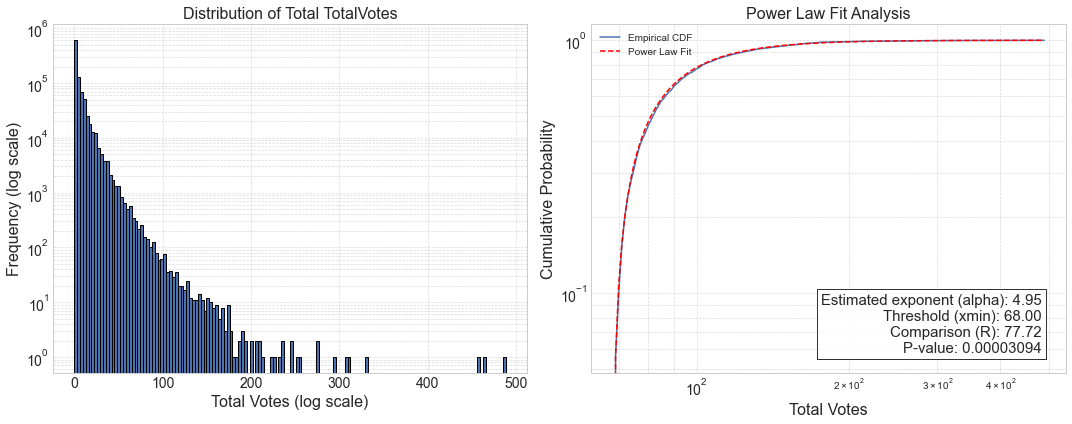

In [298]:
# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

data = df_merged['TotalVotes'][df_merged['TotalVotes'] > 0]  # Filter out non-positive values

# Perform power-law analysis
results = powerlaw.Fit(data)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left subplot: Histogram
axes[0].hist(df_merged['TotalVotes'], bins=150, edgecolor='black', log=True)
axes[0].set_title('Distribution of Total TotalVotes', fontsize=16)
axes[0].set_xlabel('Total Votes (log scale)', fontsize=16)
axes[0].set_ylabel('Frequency (log scale)', fontsize=16)

# Adjust tick label font size
axes[0].tick_params(axis='both', labelsize=14)

axes[0].grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Right subplot: Power-law analysis and summary
# Plot empirical CDF and fitted power-law model
results.plot_cdf(ax=axes[1], label='Empirical CDF')
results.power_law.plot_cdf(ax=axes[1], color='red', linestyle='--', label='Power Law Fit')

# Add statistical summary as text in the bottom-right corner
R, p = results.distribution_compare('power_law', 'exponential')
summary_text = (
    f"Estimated exponent (alpha): {results.alpha:.2f}\n"
    f"Threshold (xmin): {results.xmin:.2f}\n"
    f"Comparison (R): {R:.2f}\n"
    f"P-value: {p:.8f}"
)
axes[1].text(0.95, 0.05, summary_text, transform=axes[1].transAxes, fontsize=15, 
             bbox=dict(facecolor='white', alpha=0.8), ha='right', va='bottom')

axes[1].set_title('Power Law Fit Analysis', fontsize=16)
axes[1].set_xlabel('Total Votes', fontsize=16)
axes[1].set_ylabel('Cumulative Probability', fontsize=16)

# Adjust tick label font size
axes[1].tick_params(axis='both', labelsize=14)

axes[1].grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
axes[1].legend()

# Tight layout and save
plt.tight_layout()
plt.savefig('./figures/TotalVotes_Analysis.png', format='png', dpi=300)
plt.show()


Calculating best minimal value for power law fit


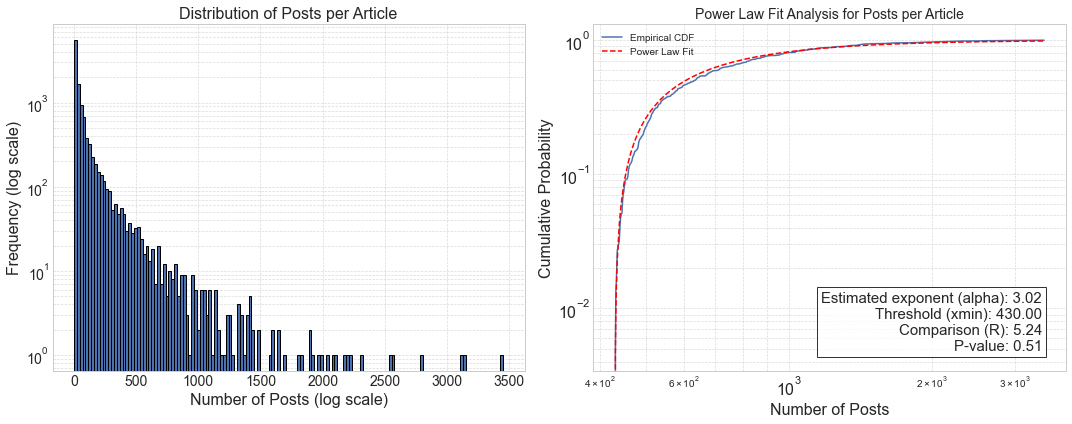

In [299]:
# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

# Step 1: Data preparation
# Assuming 'df_merged' contains a column 'ID_article'
# Group by 'ID_article' to count the number of posts per article
post_counts = df_merged.groupby('ID_Article').size()

# Filter out zero or negative counts if needed (though unlikely in this scenario)
post_counts = post_counts[post_counts > 0]

# Perform power-law analysis
results_posts = powerlaw.Fit(post_counts)

# Step 2: Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left subplot: Histogram of posts per article
axes[0].hist(post_counts, bins=150, edgecolor='black', log=True)
axes[0].set_title('Distribution of Posts per Article', fontsize=16)
axes[0].set_xlabel('Number of Posts (log scale)', fontsize=16)
axes[0].set_ylabel('Frequency (log scale)', fontsize=16)

# Adjust tick label font size
axes[0].tick_params(axis='both', labelsize=14)

axes[0].grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Right subplot: Power-law analysis and summary
# Plot empirical CDF and fitted power-law model
results_posts.plot_cdf(ax=axes[1], label='Empirical CDF')
results_posts.power_law.plot_cdf(ax=axes[1], color='red', linestyle='--', label='Power Law Fit')

# Add statistical summary as text in the bottom-right corner
R_posts, p_posts = results_posts.distribution_compare('power_law', 'exponential')
summary_text_posts = (
    f"Estimated exponent (alpha): {results_posts.alpha:.2f}\n"
    f"Threshold (xmin): {results_posts.xmin:.2f}\n"
    f"Comparison (R): {R_posts:.2f}\n"
    f"P-value: {p_posts:.2f}"
)
axes[1].text(0.95, 0.05, summary_text_posts, transform=axes[1].transAxes, fontsize=15, 
             bbox=dict(facecolor='white', alpha=0.8), ha='right', va='bottom')

axes[1].set_title('Power Law Fit Analysis for Posts per Article', fontsize=14)
axes[1].set_xlabel('Number of Posts', fontsize=16)
axes[1].set_ylabel('Cumulative Probability', fontsize=16)

# Adjust tick label font size
axes[1].tick_params(axis='both', labelsize=16)

axes[1].grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
axes[1].legend()

# Tight layout and save
plt.tight_layout()
plt.savefig('./figures/PostsPerArticle_Analysis.png', format='png', dpi=300)
plt.show()

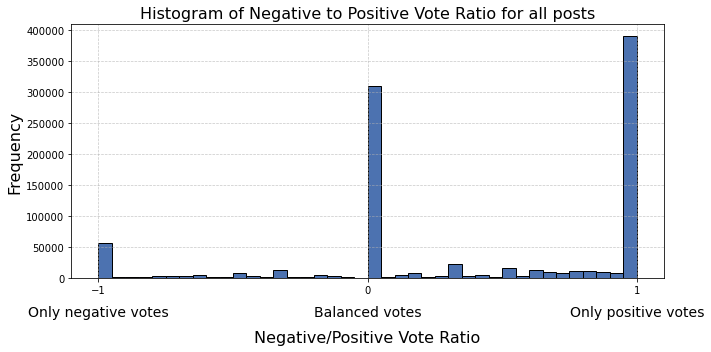

In [45]:


# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(df_merged['Neg_Pos_Score'].dropna(), bins=40, edgecolor='black')
plt.title('Histogram of Negative to Positive Vote Ratio for all posts', fontsize=16)
plt.xlabel('Negative/Positive Vote Ratio', fontsize=16, labelpad=35)  # Add margin using labelpad
plt.ylabel('Frequency', fontsize=16)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotate x axsis for improved clarity
plt.annotate('Only positive votes', xy=(1, 0), xytext=(1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=14,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )

plt.annotate('Balanced votes', xy=(0, 0), xytext=(0, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=14,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
            )

plt.annotate('Only negative votes', xy=(-1, 0), xytext=(-1, -0.15),  
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=14,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )
plt.xlim(-1.1, 1.1)
plt.xticks([-1, 0, 1])

# Show the plot
plt.tight_layout()
plt.savefig('./figures/Neg_Pos_Score_Histogram_engaging_posts.png', format='png', dpi=300)
plt.show()





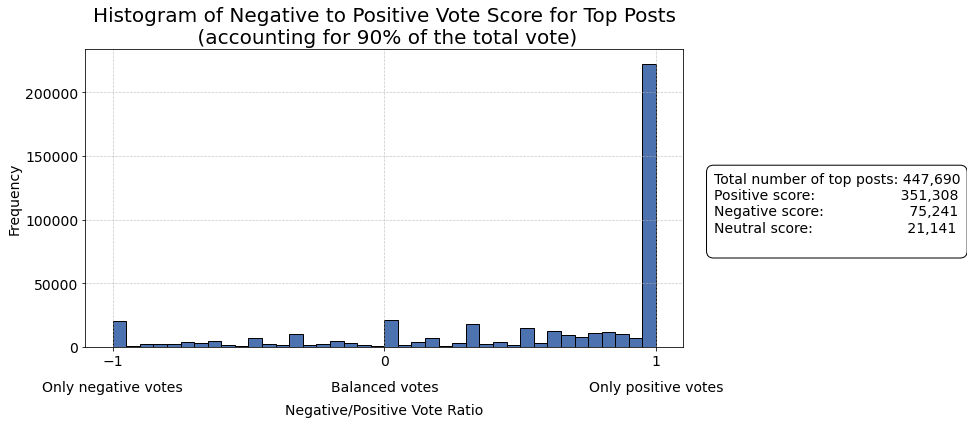

In [46]:
# Filter for "engaging posts" (those that account for 90% of total vote)
engaging_posts = df_merged[df_merged['CumulativeVotes'] > 0.1]

# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

# Create the histogram
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the histogram for the Negative/Positive Score
ax.hist(engaging_posts['Neg_Pos_Score'].dropna(), bins=40, edgecolor='black')
ax.set_title('Histogram of Negative to Positive Vote Score for Top Posts\n (accounting for 90% of the total vote)', 
             fontsize=20)
ax.set_xlabel('Negative/Positive Vote Ratio', fontsize=14, labelpad=35)  
ax.set_ylabel('Frequency', fontsize=14)

# Adjust tick label font size
ax.tick_params(axis='both', labelsize=14)

# Add gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotate x axis for improved clarity
ax.annotate('Only positive votes', xy=(1, 0), xytext=(1, -0.15),  
            textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=14,
            bbox=dict(facecolor='white', edgecolor='none', pad=3),
            )

ax.annotate('Balanced votes', xy=(0, 0), xytext=(0, -0.15),  
            textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=14,
            bbox=dict(facecolor='white', edgecolor='none', pad=3),
            )

ax.annotate('Only negative votes', xy=(-1, 0), xytext=(-1, -0.15),  
            textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=14,
            bbox=dict(facecolor='white', edgecolor='none', pad=3),
            )
ax.set_xlim(-1.1, 1.1)
ax.set_xticks([-1, 0, 1])

# Total number of posts
total_posts = len(engaging_posts)
positive_posts = len(engaging_posts[engaging_posts['Neg_Pos_Score'] > 0])
negative_posts = len(engaging_posts[engaging_posts['Neg_Pos_Score'] < 0])
neutral_posts = len(engaging_posts[engaging_posts['Neg_Pos_Score'] == 0])

formatted_stats = (
    f"Total number of top posts: {total_posts:,}\n"
    f"Positive score:                   {positive_posts:,}\n"
    f"Negative score:                   {negative_posts:,}\n"
    f"Neutral score:                     {neutral_posts:,}\n"
)

# Create an inset with the statistics text close to the plot's right side
fig.text(0.83, 0.5, formatted_stats, ha='left', va='center', fontsize=14, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Adjust layout to ensure the text is included
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right margin to fit the text box

# Save the figure ensuring bounding box includes text
plt.savefig('./figures/Neg_Pos_Score_Histogram_Engaging_Posts.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


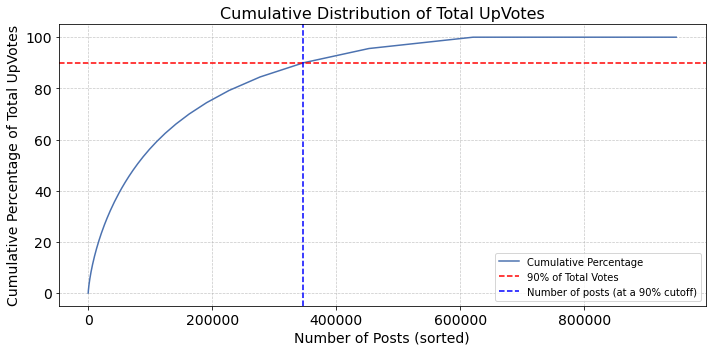

In [7]:
# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

# Cumulative distribution analysis
sorted_votes = df_merged['UpVotes'].sort_values(ascending=False).reset_index(drop=True)
cumulative_votes = sorted_votes.cumsum()
cumulative_percentage = (cumulative_votes / cumulative_votes.iloc[-1]) * 100

# Find cutoff point where 50% of posts contribute to 90% of votes
cutoff_index = np.searchsorted(cumulative_percentage, 90)
cutoff_value = sorted_votes.iloc[cutoff_index]

# Plot cumulative distribution with cutoff line
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sorted_votes.index, cumulative_percentage, label='Cumulative Percentage')
ax.axhline(y=90, color='red', linestyle='--', label='90% of Total Votes')
ax.axvline(x=cutoff_index, color='blue', linestyle='--', label=f'Number of posts (at a 90% cutoff)')
ax.set_title('Cumulative Distribution of Total UpVotes', fontsize=16)
ax.set_xlabel('Number of Posts (sorted)', fontsize=14)
ax.set_ylabel('Cumulative Percentage of Total UpVotes', fontsize=14)

# Adjust tick label font size
ax.tick_params(axis='both', labelsize=14)

ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend()

# Save the cumulative plot
plt.tight_layout()
plt.savefig('./figures/TotalVotes_Cumulative.png', format='png', dpi=300)
plt.show()


##### Setting non time-corrected Cut Off Value

In [522]:
# Initialize all as 'regular post'
df_merged['PostEngagement'] = 'regular post'

# Update 'PostEngagement' to 'engaging post' where PostVotes is greater than article_vote_median
df_merged.loc[df_merged['CumulativeVotes'] > 0.05, 
              'PostEngagement'] = 'engaging post'

# Calculate top 40% threshold for articles with more than 10 posts
# (Additional code would be needed here to compute the threshold if it's intended to be added)
df_merged['PostEngagement'].value_counts()

# Calculate total votes
total_votes = df_merged['TotalVotes'].sum()

# Calculate total votes for 'engaging posts'
top_votes = df_merged.loc[df_merged['PostEngagement'] == 'engaging post', 'TotalVotes'].sum()

# Calculate the percentage of total votes spent on 'engaging posts'
percentage_top_votes = (top_votes / total_votes) * 100

percentage_engaging_posts = df_merged[df_merged['PostEngagement'] == 'engaging post'].count()[1] / df_merged.shape [0]

# Output the results
print(f"Total Votes: {total_votes}")
print(f"Engaging posts Votes: {top_votes}")
print(f"Percentage of Total Votes on engaging posts: {percentage_top_votes:.3f}%")
print(f"Percentage of engaging posts to regular posts: {percentage_engaging_posts:.3f}%")

Total Votes: 4815159
Engaging posts Votes: 4456298
Percentage of Total Votes on engaging posts: 92.547%
Percentage of engaging posts to regular posts: 0.330%


In [523]:
correlation_time, p_value_time = pointbiserialr(df_merged["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      df_merged["publication_time"])

# Print results
print("Corrrection with publication time")
print(f"Point Biserial Correlation: {correlation_time}")
print(f"P-value: {p_value_time}")

correlation_rank, p_value_rank = pointbiserialr(df_merged["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      df_merged["publication_rank"])

# Print results
print("Corrrection with publication rank")
print(f"Point Biserial Correlation: {correlation_rank}")
print(f"P-value: {p_value_rank}")

Corrrection with publication time
Point Biserial Correlation: -0.1906276242600869
P-value: 0.0
Corrrection with publication rank
Point Biserial Correlation: -0.2735392686853885
P-value: 0.0


**Looking at some examples example** 

In [524]:
df_merged[df_merged['ID_Article'] == 6703][["ID_Article", "FullText", 
                                          # "PositiveVotes", "NegativeVotes", 
                                           "TotalVotes",  "ShareOfVotes", "CumulativeVotes",
                                            "PostEngagement", ]].style

,ID_Article,FullText,TotalVotes,ShareOfVotes,CumulativeVotes,PostEngagement
524495,6703,Was sind schon läppische 100 Jahre im Vergleich zu Ewigkeit.,0,0.000000,0.000000,regular post
524496,6703,THX You made my day!,2,0.090909,0.090909,engaging post
524497,6703,"Ein fast 400 Jahre alter Talmud, .. .. zwischen 1519 und 1523 gedruckt. »Menschen werden JournalistInnen, weil sie gerne Geschichten erzählen – und Mathe hassen.« (Scott Maier)",20,0.909091,1.000000,engaging post


In [525]:
df_merged[df_merged['ID_Article'] == 103][["ID_Article", "FullText",# "PositiveVotes", "NegativeVotes", 
                                           "TotalVotes", "ShareOfVotes", "CumulativeVotes",
                                           "PostEngagement", ]]

,ID_Article,FullText,TotalVotes,ShareOfVotes,CumulativeVotes,PostEngagement
5775,103,Ich stehe ja auf das Mozart Eis und Raphaello ...,0,0.000000,0.000000,regular post
5776,103,"Ausbildung in Italien gut und schön, aber muss...",0,0.000000,0.000000,regular post
5777,103,"Cassata gibt's in der krugerstraße, derzeit mu...",0,0.000000,0.000000,regular post
5778,103,Cassata geht mir in Wien auch furchtbar ab. Mi...,0,0.000000,0.000000,regular post
5779,103,"""...und der Eisverkäufer ruft ""Gelati Gelati""....",0,0.000000,0.000000,regular post
5780,103,Eis das mit der Spachtel aufgetragen wird ist ...,0,0.000000,0.000000,regular post
5781,103,Herzlichen Dank für den interessanten Tip! Cas...,0,0.000000,0.000000,regular post
5782,103,Laienhaft frage ich nach: Fuer mich wirkt das ...,0,0.000000,0.000000,regular post
5783,103,In Oesterreich gibt es vielleicht 900 Eisgesch...,0,0.000000,0.000000,regular post
5784,103,"""Eh, wasse wolle due, hä?""",1,0.166667,0.333333,engaging post


### 1.5.1 Setting Time-corrected Cut Off Value

In [601]:
# create a feature that combines publication time and rank
df_merged['combined_time'] = (df_merged['publication_rank']*1.5 + df_merged['publication_time']) / 2.5
df_merged = normalize_temporal_features(df_merged, ['combined_time'], 'ID_Article')

##### analysis

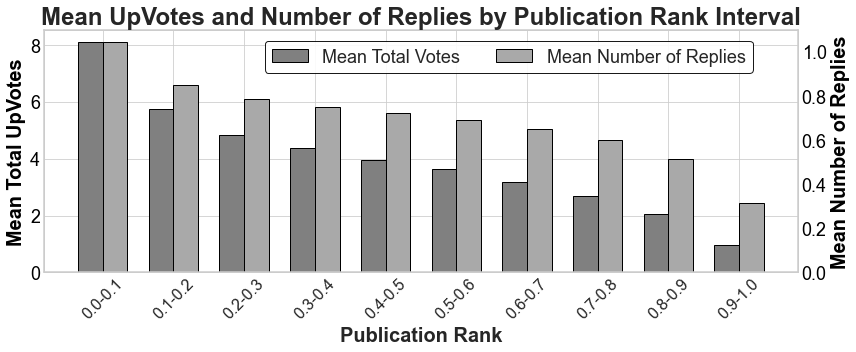

In [297]:
# Define bins for the intervals (0-0.1, 0.1-0.2, ..., 0.9-1.0)
bins = [i / 10 for i in range(11)]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

# Create a new column for the binned intervals based on 'publication_rank'
rank = pd.cut(df_merged['publication_rank'], bins=bins, labels=labels, include_lowest=True).copy()

# Group by intervals and calculate the mean of 'UpVotes' and 'Number_of_Replies'
mean_values_by_interval = df_merged.groupby(rank)[['UpVotes', 'Number_of_Replies']].mean().reset_index()

# Set the size and style of the plot
plt.style.use('seaborn-whitegrid')
fig, ax1 = plt.subplots(figsize=(12, 5))

# Define bar width and positions
bar_width = 0.35
x = range(len(mean_values_by_interval))

# Plot UpVotes on the primary axis
ax1.bar(
    [i - bar_width / 2 for i in x], 
    mean_values_by_interval['UpVotes'], 
    width=bar_width, 
    color='gray', 
    edgecolor='black', 
    label='Mean Total Votes'
)
ax1.set_xlabel('Publication Rank', fontsize=20, fontweight='bold')  # Increased fontsize
ax1.set_ylabel('Mean Total UpVotes', fontsize=20, fontweight='bold', color='black')  # Increased fontsize
ax1.tick_params(axis='y', labelsize=18, labelcolor='black')  # Increased fontsize
ax1.tick_params(axis='x', labelsize=18)  # Increased fontsize
ax1.set_xticks(x)
ax1.set_xticklabels(mean_values_by_interval['publication_rank'], rotation=45, fontsize=16)  # Increased fontsize

# Create a secondary y-axis for Number_of_Replies
ax2 = ax1.twinx()
ax2.bar(
    [i + bar_width / 2 for i in x], 
    mean_values_by_interval['Number_of_Replies'], 
    width=bar_width, 
    color='darkgray', 
    edgecolor='black', 
    label='Mean Number of Replies'
)
ax2.set_ylabel('Mean Number of Replies', fontsize=20, fontweight='bold', color='black')  # Increased fontsize
ax2.tick_params(axis='y', labelsize=18, labelcolor='black')  # Increased fontsize

# Add gridlines and a border
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Add legend
fig.legend(
    loc='upper left', 
    bbox_to_anchor=(0.3, 0.9), 
    fontsize=18,  # Increased fontsize
    frameon=True, 
    edgecolor='black', 
    framealpha=0.9, 
    ncol=2
)

# Title and layout improvements
plt.title('Mean UpVotes and Number of Replies by Publication Rank Interval', fontsize=24, fontweight='bold')  # Increased fontsize
fig.tight_layout()

plt.savefig('./figures/publication_rank_to_total_votes.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


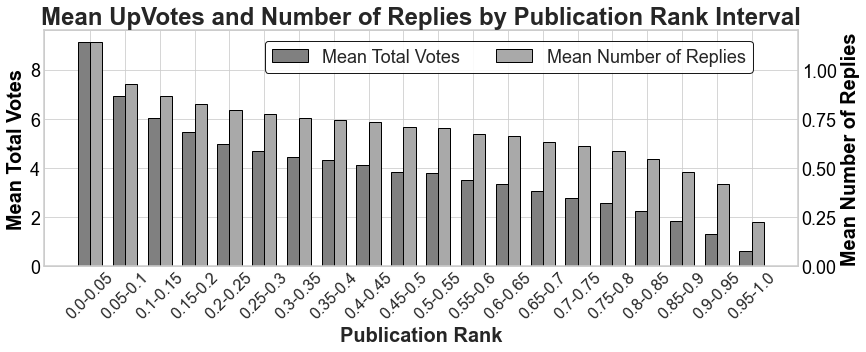

In [9]:
# Define bins for the intervals (0-0.05, 0.05-0.1, ..., 0.95-1.0)
bins = [i / 20 for i in range(21)]  # Bins from 0 to 1 with 0.05 steps
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

# Create a new column for the binned intervals based on 'publication_rank'
rank = pd.cut(df_merged['publication_rank'], bins=bins, labels=labels, include_lowest=True).copy()

# Group by intervals and calculate the mean of 'UpVotes' and 'Number_of_Replies'
mean_values_by_interval = df_merged.groupby(rank)[['UpVotes', 'Number_of_Replies']].mean().reset_index()

# Set the size and style of the plot
plt.style.use('seaborn-whitegrid')
fig, ax1 = plt.subplots(figsize=(12, 5))  # Larger figure size

# Define bar width and positions
bar_width = 0.35
x = range(len(mean_values_by_interval))

# Plot UpVotes on the primary axis
ax1.bar(
    [i - bar_width / 2 for i in x], 
    mean_values_by_interval['UpVotes'], 
    width=bar_width, 
    color='gray', 
    edgecolor='black', 
    label='Mean Total Votes'
)
ax1.set_xlabel('Publication Rank', fontsize=20, fontweight='bold')  # Increased fontsize
ax1.set_ylabel('Mean Total Votes', fontsize=20, fontweight='bold', color='black')  # Increased fontsize
ax1.tick_params(axis='y', labelsize=18, labelcolor='black')  # Increased fontsize
ax1.tick_params(axis='x', labelsize=18)  # Increased fontsize
ax1.set_xticks(x)
ax1.set_xticklabels(mean_values_by_interval['publication_rank'], rotation=45, fontsize=16)  # Increased fontsize

# Create a secondary y-axis for Number_of_Replies
ax2 = ax1.twinx()
ax2.bar(
    [i + bar_width / 2 for i in x], 
    mean_values_by_interval['Number_of_Replies'], 
    width=bar_width, 
    color='darkgray', 
    edgecolor='black', 
    label='Mean Number of Replies'
)
ax2.set_ylabel('Mean Number of Replies', fontsize=20, fontweight='bold', color='black')  # Increased fontsize
ax2.tick_params(axis='y', labelsize=18, labelcolor='black')  # Increased fontsize

# Add gridlines and a border
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Add legend
fig.legend(
    loc='upper left', 
    bbox_to_anchor=(0.3, 0.9), 
    fontsize=18,  # Increased fontsize
    frameon=True, 
    edgecolor='black', 
    framealpha=0.9, 
    ncol=2
)

plt.savefig('./figures/publication_rank_to_total_votes.png', dpi=300, bbox_inches='tight')

# Title and layout improvements
plt.title('Mean UpVotes and Number of Replies by Publication Rank Interval', fontsize=24, fontweight='bold')  # Increased fontsize
fig.tight_layout()

# Show the plot
plt.show()


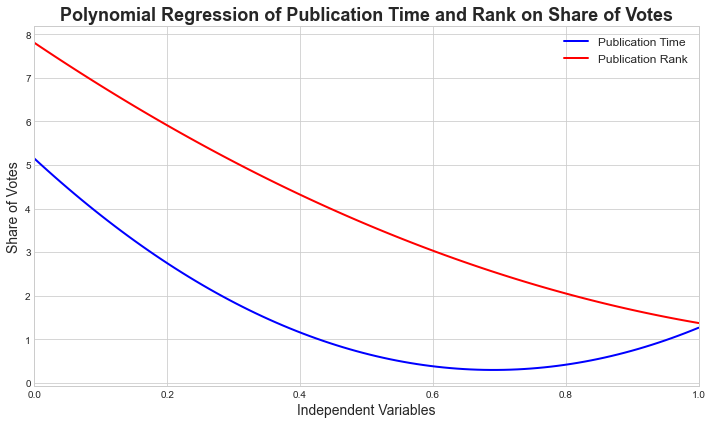

In [12]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plot polynomial regression for publication_time (degree 2 for quadratic curve)
sns.regplot(x='publication_time', y='UpVotes', data=df_merged, 
            scatter=False, 
            line_kws={'color': 'blue', 'lw': 2}, 
            ci=None, 
            order=2,  # Polynomial degree 2 for quadratic regression
            label='Publication Time')

# Plot polynomial regression for publication_rank (degree 2 for quadratic curve)
sns.regplot(x='publication_rank', y='UpVotes', data=df_merged, 
            scatter=False, 
            line_kws={'color': 'red', 'lw': 2}, 
            ci=None, 
            order=2,  # Polynomial degree 2 for quadratic regression
            label='Publication Rank')

# Add title and labels
plt.title('Polynomial Regression of Publication Time and Rank on Share of Votes', fontsize=18, fontweight='bold')
plt.xlabel('Independent Variables', fontsize=14)
plt.ylabel('Share of Votes', fontsize=14)

# Add a legend to distinguish between the two regression lines
plt.legend(fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()



plt.savefig('./figures/regression_time.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


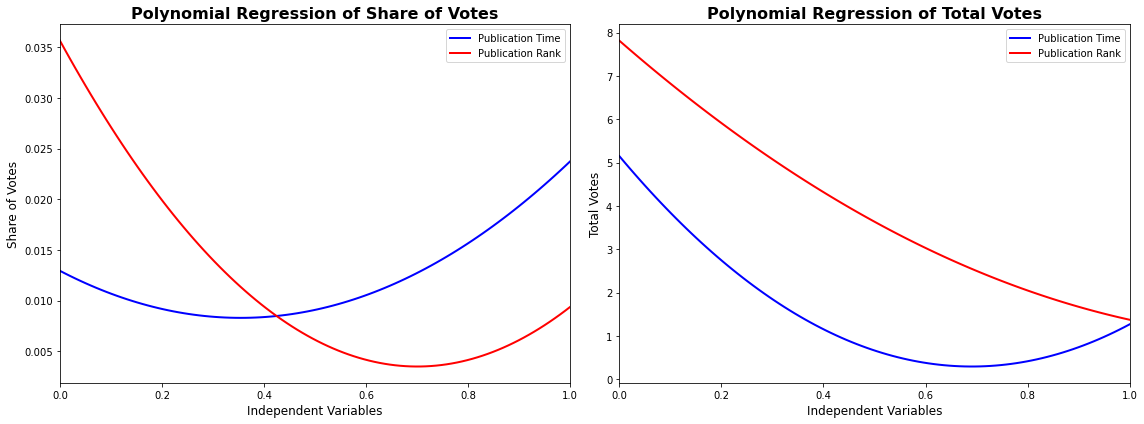

In [11]:


# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)  # Two plots side by side

# First plot: Share of Votes
sns.regplot(
    x='publication_time', 
    y='ShareOfVotes',  # Assuming this column exists in your data
    data=df_merged,
    scatter=False,
    line_kws={'color': 'blue', 'lw': 2},
    ci=None,
    order=2,  # Polynomial degree 2 for quadratic regression
    ax=axes[0],
    label='Publication Time'
)
sns.regplot(
    x='publication_rank',
    y='ShareOfVotes',
    data=df_merged,
    scatter=False,
    line_kws={'color': 'red', 'lw': 2},
    ci=None,
    order=2,
    ax=axes[0],
    label='Publication Rank'
)
axes[0].set_title('Polynomial Regression of Share of Votes', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Independent Variables', fontsize=12)
axes[0].set_ylabel('Share of Votes', fontsize=12)
axes[0].legend(fontsize=10)

# Second plot: Total Votes
sns.regplot(
    x='publication_time',
    y='UpVotes',  # Total votes column
    data=df_merged,
    scatter=False,
    line_kws={'color': 'blue', 'lw': 2},
    ci=None,
    order=2,
    ax=axes[1],
    label='Publication Time'
)
sns.regplot(
    x='publication_rank',
    y='UpVotes',
    data=df_merged,
    scatter=False,
    line_kws={'color': 'red', 'lw': 2},
    ci=None,
    order=2,
    ax=axes[1],
    label='Publication Rank'
)
axes[1].set_title('Polynomial Regression of Total Votes', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Independent Variables', fontsize=12)
axes[1].set_ylabel('Total Votes', fontsize=12)
axes[1].legend(fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('./figures/regression_comparison.png', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()


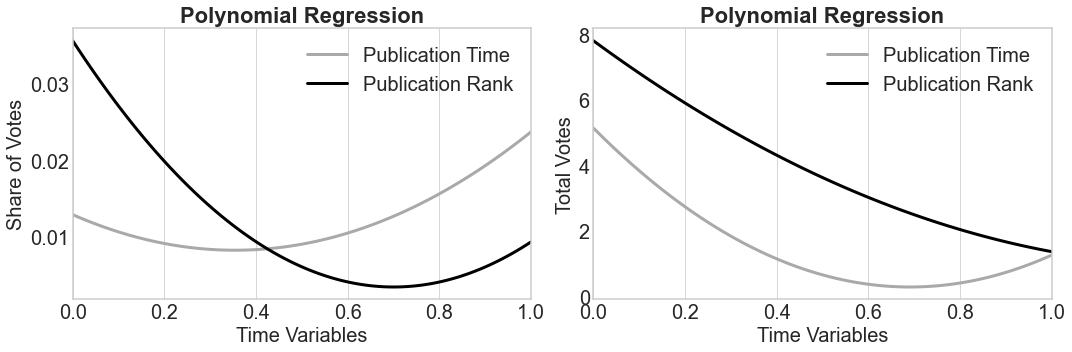

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set greyscale style
plt.style.use('seaborn-whitegrid')

# Set up subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)  # Compact figure size for printing

# Greyscale color settings
colors = {'blue': 'darkgray', 'red': 'black'}

# Increase font sizes and line thickness
title_fontsize = 22
label_fontsize = 20
tick_fontsize = 20
line_width = 3

# First plot: Polynomial Regression of Share of Votes
sns.regplot(
    x='publication_time',
    y='ShareOfVotes',
    data=df_merged,
    scatter=False,
    line_kws={'color': colors['blue'], 'lw': line_width},
    ci=None,
    order=2,
    ax=axes[0],
    label='Publication Time'
)
sns.regplot(
    x='publication_rank',
    y='ShareOfVotes',
    data=df_merged,
    scatter=False,
    line_kws={'color': colors['red'], 'lw': line_width},
    ci=None,
    order=2,
    ax=axes[0],
    label='Publication Rank'
)
axes[0].set_title('Polynomial Regression', fontsize=title_fontsize, fontweight='bold')
axes[0].set_xlabel('Time Variables', fontsize=label_fontsize)
axes[0].set_ylabel('Share of Votes', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)
axes[0].legend(fontsize=tick_fontsize)

# Second plot: Polynomial Regression of Total Votes
sns.regplot(
    x='publication_time',
    y='UpVotes',
    data=df_merged,
    scatter=False,
    line_kws={'color': colors['blue'], 'lw': line_width},
    ci=None,
    order=2,
    ax=axes[1],
    label='Publication Time'
)
sns.regplot(
    x='publication_rank',
    y='UpVotes',
    data=df_merged,
    scatter=False,
    line_kws={'color': colors['red'], 'lw': line_width},
    ci=None,
    order=2,
    ax=axes[1],
    label='Publication Rank'
)
axes[1].set_title('Polynomial Regression', fontsize=title_fontsize, fontweight='bold')
axes[1].set_xlabel('Time Variables', fontsize=label_fontsize)
axes[1].set_ylabel('Total Votes', fontsize=label_fontsize)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)
axes[1].legend(fontsize=tick_fontsize)

# Adjust plot aesthetics
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

# Tight layout for compact spacing
plt.tight_layout()

# Save the figure in greyscale
plt.savefig('./figures/regression_comparison_greyscale_small.png', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()


In [20]:
# Define bins for the intervals (0-0.1, 0.1-0.2, ..., 0.9-1.0)
bins = [i / 10 for i in range(11)] 
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]
# Create a new column for the binned intervals based on 'publication_rank'
df_merged['publication_rank_interval'] = pd.cut(df_merged['combined_time'], 
                                                bins=bins, 
                                                labels=labels, include_lowest=True)

df_merged[df_merged["ID_Article"] == 103].sort_values(by=['publication_time', 
                                                          'publication_rank', 
                                                          'publication_rank_interval'])[['FullText',
                                                                                         'UpVotes',
                                                                                         'ShareOfVotes',
                                                                                         'publication_time', 
                                                                                        'publication_rank', 
                                                                                        'combined_time',
                                                                                        'publication_rank_interval']].style


,FullText,UpVotes,ShareOfVotes,publication_time,publication_rank,combined_time,publication_rank_interval
5786,"Wann gibt es endlich wieder Cassata, Peach-Melba und dieses herrliche Vanilla-Eis mit Kirsche und Kirschenlikör? Außerdem bevorzuge ich das Eis mit einer Spachtel am Stanitzel und nicht das zusammengedrückte Eis in einer Kugel. Eis wurde in den letzten Jahrzehnten immer primitiver serviert.",4,0.666667,0.000000,0.000000,0.000000,0.0-0.1
5785,"""Eh, wasse wolle due, hä?""",1,0.166667,0.007312,0.090909,0.049110,0.0-0.1
5781,"Cassata geht mir in Wien auch furchtbar ab. Mit viel Glück vielleicht einmal im Jahr zufällig am Hohen Markt, aber sonst nirgends, und das obwohl es in Wien eigentlich durchaus recht passables Eis gibt. Dabei hab ich heute doch tatsächlich bei Zanoni ""Kaugummi""-Eis gesehen! - Wenn für solche Experimente Platz in der Vitrine ist, mußte doch auch für solche Klassiker wie Cassata, die hier sowieso niemand hat, eine halbe oder Viertelwanne drin sein. Warum müssen die nur alle das Sortiment der anderen kopieren, statt auch ein paar eigene Akzente bei den Sorten zu setzen, für die man gelegentlich auch speziell hingehen würde. Daß das durchaus (und sogar zu ziemlich hohen Preisen) funktioniert, hat ja Grom schon bewiesen.",0,0.000000,0.028874,0.181818,0.105346,0.1-0.2
5775,"Cassata gibt's in der krugerstraße, derzeit muss man aber viel geduld mitbringen, die schlange steht regelmäßig auf die straße hinaus und trotzdem habens die einverkäufer nicht eilig...",0,0.000000,0.065288,0.272727,0.169008,0.1-0.2
5784,Danke für den Tip. Werde dort vorbei schauen.,1,0.166667,0.066024,0.363636,0.214830,0.2-0.3
5780,Ich stehe ja auf das Mozart Eis und Raphaello ist auch irgendwie geil.,0,0.000000,0.095108,0.454545,0.274827,0.2-0.3
5776,Laienhaft frage ich nach: Fuer mich wirkt das mit der Spachtel reingeschmierte zusammengedrueckte als das mit dem Eisportionierer quasi ausgestochene Eis. Koennen Sie mich bitte aufklaeren? Danke & Mahlzeit!,0,0.000000,0.098043,0.545455,0.321749,0.3-0.4
5778,"""...und der Eisverkäufer ruft ""Gelati Gelati""..."" https://youtu.be/j_ntb29ndI8",0,0.000000,0.100399,0.636364,0.368381,0.3-0.4
5782,"In Oesterreich gibt es vielleicht 900 Eisgeschäfte, aber mit Sicherheit keine einzige ""Eisdiele"".",0,0.000000,0.113287,0.727273,0.420280,0.4-0.5
5777,Eis das mit der Spachtel aufgetragen wird ist viel lockerer und schmeckt deshalb auch wesentlich besser als die zusammengedrückte Kugel.,0,0.000000,0.136477,0.818182,0.477330,0.4-0.5


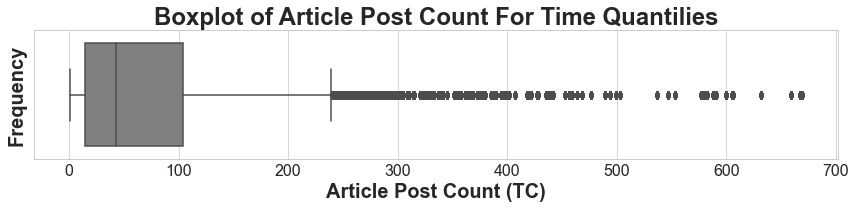

In [300]:
# Set the size and style of the plot
plt.figure(figsize=(12, 3))

# Create the boxplot
df_merged['article_post_count_tc'] = df_merged.groupby(['ID_Article', 'publication_rank_interval'])['ID_Post'].transform('count')

sns.boxplot(x=df_merged['article_post_count_tc'], color='gray', fliersize=5)

df_merged['article_post_count_tc'] = df_merged.groupby(['ID_Article', 'publication_rank_interval'])['ID_Post'].transform('count')

# Add title and labels
plt.title('Boxplot of Article Post Count For Time Quantilies', fontsize=24, fontweight='bold')
plt.xlabel('Article Post Count (TC)', fontsize=20, fontweight='bold')
plt.ylabel('Frequency', fontsize=20, fontweight='bold')

# Increase tick label size
plt.tick_params(axis='both', labelsize=16)

# Show the plot
plt.tight_layout()
plt.savefig('./figures/boxPlot_time_quantiles.png', dpi=300, bbox_inches='tight')
plt.show()


In [923]:
df_merged.reset_index(drop=True, inplace=True)

In [314]:
df_merged.shape

(948196, 85)

#### Final Approach: Setting time corrected

In [602]:
def label_and_filter_posts(df, bins=None, interval_labels=None):
    """
    Processes a DataFrame of posts to filter, group, and label posts as 'engaging' or 'regular'
    based on specified criteria, including splitting intervals, calculating statistics, 
    and handling odd-sized groups.

    Args:
        df (pd.DataFrame): Input DataFrame containing post data with at least the following columns:
            - 'ID_Article', 'publication_rank', 'UpVotes', 'ID_Post'
        bins (list, optional): List of bin edges for publication intervals. Defaults to [i / 10 for i in range(11)].
        interval_labels (list, optional): List of labels for publication intervals. If None, labels are generated from bins.

    Returns:
        pd.DataFrame: Processed and labeled DataFrame.
    """
    # Default bins and labels
    if bins is None:
        bins = [i / 10 for i in range(11)]
    if interval_labels is None:
        interval_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

    # Step 1: Bin time into intervals
    df['initial_interval'] = pd.cut(
        df['combined_time'], bins=bins, labels=interval_labels, include_lowest=True
    )

    # Step 2: Sort by ID_Article, interval, and time
    df = df.sort_values(by=['ID_Article', 'initial_interval', 'combined_time']).reset_index(drop=True)

    # Step 3: Assign subgroup indices to ensure max 10 posts per interval
    df['group_rank'] = (
        df.groupby(['ID_Article', 'initial_interval'])
        .cumcount() // 10  # Split into subgroups of size 10
    )

    # Step 4: Create publication_rank_interval by appending group_rank to intervals
    df['publication_rank_interval'] = np.where(
        df['group_rank'] == 0,
        df['initial_interval'].astype(str),
        df['initial_interval'].astype(str) + "-" + df['group_rank'].astype(str)
    )
    df.drop(columns=['group_rank', 'initial_interval'], inplace=True)

    # Step 5: Calculate statistics for intervals
    df['article_vote_count_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('sum')
    df['article_post_count_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['ID_Post'].transform('count')
    df['ShareOfVotes_tc'] = df['UpVotes'] / df['article_vote_count_tc']
    df['ShareOfVotes_tc'].fillna(0, inplace=True)
    df.sort_values(['ShareOfVotes_tc'], inplace=True)
    df['CumulativeVotes_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['ShareOfVotes_tc'].cumsum()
    df['CumulativeVotes_tc'] = df.groupby(['ID_Article', 'publication_rank_interval', 'ShareOfVotes_tc'])['CumulativeVotes_tc'].transform('max')
    df['article_vote_median_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('median')
    #df['article_vote_mean_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('mean')

    # Step 6: Filter out intervals
    initial_rows = df.shape[0]
    initial_votes = df["TotalVotes"].sum()
    df = df[(df['article_vote_median_tc'] > 0) & (df['article_post_count_tc'] == 10) &
            (df['article_vote_count_tc'] > 15) ].copy()
    removed_rows_due_to_low_engagement = initial_rows - df.shape[0]
    removed_votes_due_to_low_engagement = initial_votes - df["TotalVotes"].sum()
    
    
     # Step 5: Recalulate statistics for intervals
    df['article_vote_count_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('sum')
    df['article_vote_min'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('min')
    df['article_vote_max'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('min')
    df['article_post_count_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['ID_Post'].transform('count')
    df['ShareOfVotes_tc'] = df['UpVotes'] / df['article_vote_count_tc']
    df['ShareOfVotes_tc'].fillna(0, inplace=True)
    df.sort_values(['ShareOfVotes_tc'], inplace=True)
    df['CumulativeVotes_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['ShareOfVotes_tc'].cumsum()
    df['CumulativeVotes_tc'] = df.groupby(['ID_Article', 'publication_rank_interval', 'ShareOfVotes_tc'])['CumulativeVotes_tc'].transform('max')
    df['article_vote_median_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('median')

    
    # correct this part below - begins
    # Do Labeling PostEngagement column
    
    # Step 6: Add ranking order within each interval
    df = df.sort_values(by=['ID_Article', 'publication_rank_interval', 'UpVotes', "Number_of_Replies"],
                       ascending=[True, True, False, False]).reset_index(drop=True)
    df['RankingOrder'] = df.groupby(['ID_Article', 'publication_rank_interval']).cumcount() + 1
    print(df['RankingOrder'].value_counts())

    # Initialize engagement columns with "undefined"
    df['PostEngagement'] = 'undefined'
    df['PostEngagementTopFlop20'] = 'undefined'
    df['PostEngagementTopFlop10'] = 'undefined'


    # Apply labels directly to the main DataFrame
    df['PostEngagement'] = ['engaging post' if x <= 5 else 'regular post' for x in df['RankingOrder']]

    df['PostEngagementTopFlop20'] = [
        'engaging post' if x <= 2 else 'regular post' if x >= 9 else 'undefined' 
        for x in df['RankingOrder']
    ]

    df['PostEngagementTopFlop10'] = [
        'engaging post' if x == 1 else 'regular post' if x == 10 else 'undefined' 
        for x in df['RankingOrder']
    ]
    
    # Output statistics
    top_25_count = (df['PostEngagementTopFlop20'] == 'engaging post').sum()
    flop_25_count = (df['PostEngagementTopFlop20'] == 'regular post').sum()
    top_10_count = (df['PostEngagementTopFlop10'] == 'engaging post').sum()
    flop_10_count = (df['PostEngagementTopFlop10'] == 'regular post').sum()
    
    # Step 8: Calculate Summary Stats
    total_votes = df['UpVotes'].sum()
    top_votes = df.loc[df['PostEngagement'] == 'engaging post', 'UpVotes'].sum()
    percentage_top_votes = (top_votes / total_votes) * 100
    percentage_engaging_posts = (df['PostEngagement'].value_counts().get('engaging post', 0) / len(df)) * 100
    rows_lost_percentage = (removed_rows_due_to_low_engagement / initial_rows) * 100

    # Print summary statistics
    print("Filtering statistics")
    print(f"Initial Rows: {initial_rows}")
    print(f"Rows Removed Due to Low Engagement: {removed_rows_due_to_low_engagement} ({rows_lost_percentage:.3f}%)")
    print(f"Votes Removed Due to Low Engagement: {removed_votes_due_to_low_engagement} ({rows_lost_percentage:.3f}%)")
    print(f"Total UpVotes: {total_votes}")
    print(f"Engaging Posts UpVotes: {top_votes}")
    print(f"Percentage of Total UpVotes, attributed to Engaging Posts: {percentage_top_votes:.3f}%")
    print(f"Percentage of Engaging Posts to Regular Posts: {percentage_engaging_posts:.3f}%")

    return df

time_corrected = label_and_filter_posts(df_merged)

1     51248
2     51248
3     51248
4     51248
5     51248
6     51248
7     51248
8     51248
9     51248
10    51248
Name: RankingOrder, dtype: int64
Filtering statistics
Initial Rows: 947899
Rows Removed Due to Low Engagement: 435419 (45.935%)
Votes Removed Due to Low Engagement: 1279722 (45.935%)
Total UpVotes: 2785789
Engaging Posts UpVotes: 2496219
Percentage of Total UpVotes, attributed to Engaging Posts: 89.605%
Percentage of Engaging Posts to Regular Posts: 50.000%


In [603]:
correlation_time, p_value_time = pointbiserialr(time_corrected["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      time_corrected["publication_time"])

# Print results
print("Corrrection with publication time")
print(f"Point Biserial Correlation: {correlation_time}")
print(f"P-value: {p_value_time}")

correlation_rank, p_value_rank = pointbiserialr(time_corrected["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      time_corrected["publication_rank"])

# Print results
print("Corrrection with publication rank")
print(f"Point Biserial Correlation: {correlation_rank}")
print(f"P-value: {p_value_rank}")

correlation_rank, p_value_rank = pointbiserialr(time_corrected["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      time_corrected["article_post_count"])

# Print results
print("Corrrection with post count")
print(f"Point Biserial Correlation: {correlation_rank}")
print(f"P-value: {p_value_rank}")

Corrrection with publication time
Point Biserial Correlation: -0.000830298774387777
P-value: 0.5522509486714875
Corrrection with publication rank
Point Biserial Correlation: -0.0014017406310026807
P-value: 0.3156331601223393
Corrrection with post count
Point Biserial Correlation: -3.848705954086727e-20
P-value: 1.0000000001047997


In [604]:
df_merged=time_corrected.copy()

In [607]:
time_corrected.shape

(512480, 93)

In [758]:
df_merged["ArticleTitle"].head()

0    Welche Erfahrungen haben Sie als Linkshänder g...
1    Welche Erfahrungen haben Sie als Linkshänder g...
2    Welche Erfahrungen haben Sie als Linkshänder g...
3    Welche Erfahrungen haben Sie als Linkshänder g...
4    Welche Erfahrungen haben Sie als Linkshänder g...
Name: ArticleTitle, dtype: object

In [763]:
article_df["PostEngagementTopFlop10"].head()

397600    engaging post
397601        undefined
397602        undefined
397603        undefined
397604        undefined
Name: PostEngagementTopFlop10, dtype: object

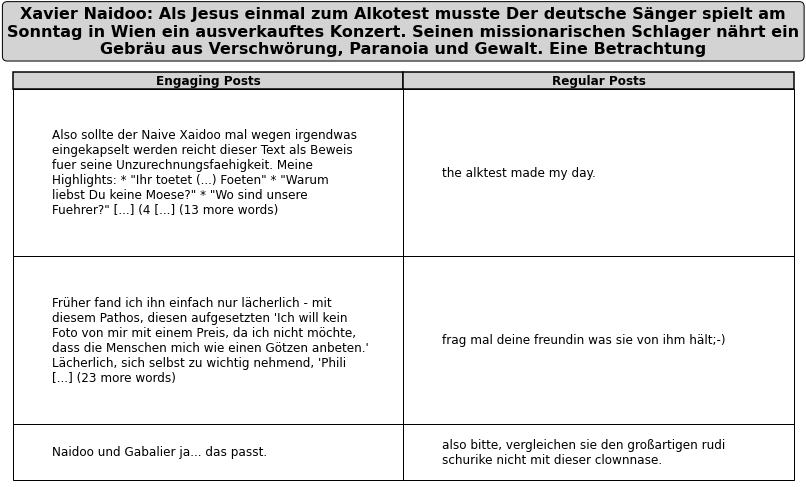

Styled table saved as graphic: styled_posts_table.png


In [375]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Shuffle the dataframe before selecting an article
df_merged = df_merged.sample(frac=1, random_state=42).reset_index(drop=True)

# Automatically find an ID_Article with at least 3 engaging and 3 regular posts
valid_article = None
for article_id in df_merged["ID_Article"].unique():
    article_df = df_merged[df_merged["ID_Article"] == article_id]
    if (article_df[article_df["PostEngagementTopFlop10"] == "engaging post"].shape[0] >= 3 and
        article_df[article_df["PostEngagementTopFlop10"] == "regular post"].shape[0] >= 3):
        valid_article = article_id
        break

if valid_article is None:
    raise ValueError("No article found with enough data.")

# Filter the dataframe for the specific article
article_df = df_merged[df_merged["ID_Article"] == valid_article]

# Shuffle the data to get different examples each time (only after selecting the article)
engaging_posts = article_df[article_df["PostEngagementTopFlop10"] == "engaging post"].sample(n=3)["FullText"].tolist()
regular_posts = article_df[article_df["PostEngagementTopFlop10"] == "regular post"].sample(n=3)["FullText"].tolist()

# Get the article title
article_title = article_df["ArticleTitle"].iloc[0]

# Define text wrapping function with a text length limit of 50 characters
def wrap_text(text, max_width=50, max_length=250):
        """Wrap text to ensure it fits within a maximum width without splitting words."""
        
        
        if len(text) > max_length:
            initial_length=len(text)
            text = str(text)[:max_length]  # Limit text length to max_length
            text = text + f" [...] ({initial_length-max_length} more words)"  # Append ellipsis if text is truncated
        words = str(text).split()
        lines = []
        current_line = []
        current_length = 0

        for word in words:
            if current_length + len(word) + len(current_line) > max_width:
                lines.append(" ".join(current_line))
                current_line = [word]
                current_length = len(word)
            else:
                current_line.append(word)
                current_length += len(word)
        if current_line:
            lines.append(" ".join(current_line))
        return "\n".join(lines)

# Apply text wrapping to the post texts and the article title, with a max width of 50 characters
wrapped_engaging_posts = [wrap_text(post) for post in engaging_posts]
wrapped_regular_posts = [wrap_text(post) for post in regular_posts]
wrapped_article_title = wrap_text(article_title, max_width=85)

# Combine them into a DataFrame for display
df_display = pd.DataFrame({
    "Engaging Posts": wrapped_engaging_posts,
    "Regular Posts": wrapped_regular_posts
})

# Define a function to create a styled table
def create_label_examples(df, article_title, output_path, max_length=50, font_size=12):
    """
    Create a styled table from a DataFrame and save it as an image.
    """
    # Apply text wrapping to all cells
    df = df.copy()
    df_wrapped = df.applymap(lambda x: wrap_text(x))

    # Calculate the required row heights based on the content length
    row_heights = []
    for _, row in df_wrapped.iterrows():
        max_height = max([len(cell) // 50 + 1 for cell in row])  # One row of height for every 50 characters
        row_heights.append(max_height)

    # Define the column width (equal for both columns)
    col_widths = [0.45] * 2  # Both columns should have the same width

    # Create the figure
    fig, ax = plt.subplots(figsize=(14, 6 + len(df_wrapped) * 0.5))  # Adjust height for better fit
    ax.axis("off")  # Remove axes

    # Add article title above the table
    ax.text(0.5, 1.1, article_title, fontsize=16, ha="center", va="center", fontweight="bold",
            bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle="round, pad=0.3"))

    # Create a styled table
    table = Table(ax, bbox=[0, 0, 1, 1])
    n_rows, n_cols = df_wrapped.shape

    # Add header cells with consistent style and minimal space
    header_color = "#D3D3D3"  # Light gray
    text_color = "black"
    for col_idx, column_name in enumerate(df_wrapped.columns):
        cell = table.add_cell(
            0, col_idx, width=col_widths[col_idx], height=0.3,
            text=column_name, loc="center",
            facecolor=header_color, edgecolor="black"
        )
        cell.get_text().set_color(text_color)
        cell.get_text().set_weight("bold")
        cell.set_linewidth(1.5)  # Set consistent border thickness

    # Add data cells with consistent edges and text wrapping
    for row_idx, (idx, row) in enumerate(df_wrapped.iterrows(), start=1):
        for col_idx, cell_value in enumerate(row):
            cell = table.add_cell(
                row_idx, col_idx, width=col_widths[col_idx], 
                height=row_heights[row_idx-1] * 0.5,  # Dynamic height
                text=str(cell_value), loc="left",
                facecolor="white", edgecolor="black"
            )
            cell.set_linewidth(1.0)  # Set consistent border thickness

    # Adjust font size and add the table to the plot
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)
    ax.add_table(table)

    # Save the styled table as an image
    plt.savefig(output_path, dpi=900, bbox_inches="tight")
    plt.show()
    print(f"Styled table saved as graphic: {output_path}")

# Create and save the styled table
create_label_examples(df_display, wrapped_article_title, "styled_posts_table.png", max_length=100, font_size=12)


#### other Approaches

##### Rank Groups

In [547]:
def label_and_filter_posts(df, bins=None, interval_labels=None):
    """
    Processes a DataFrame of posts to filter, group, and label posts as 'engaging' or 'regular'
    based on specified criteria, including splitting intervals, calculating statistics, 
    and handling odd-sized groups.

    Args:
        df (pd.DataFrame): Input DataFrame containing post data with at least the following columns:
            - 'ID_Article', 'publication_rank', 'UpVotes', 'ID_Post'
        bins (list, optional): List of bin edges for publication intervals. Defaults to [i / 10 for i in range(11)].
        interval_labels (list, optional): List of labels for publication intervals. If None, labels are generated from bins.

    Returns:
        pd.DataFrame: Processed and labeled DataFrame.
    """
    # Default bins and labels
    if bins is None:
        bins = [i / 10 for i in range(11)]
    if interval_labels is None:
        interval_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

    # Step 1: Bin publication_rank into intervals
    df['initial_interval'] = pd.cut(
        df['combined_time'], bins=bins, labels=interval_labels, include_lowest=True
    )

    # Step 2: Sort by ID_Article, interval, and publication_rank
    df = df.sort_values(by=['ID_Article', 'initial_interval', 'combined_time']).reset_index(drop=True)

    # Step 3: Assign subgroup indices to ensure max 10 posts per interval
    df['group_rank'] = (
        df.groupby(['ID_Article', 'initial_interval'])
        .cumcount() // 10  # Split into subgroups of size 10
    )

    # Step 4: Create publication_rank_interval by appending group_rank to intervals
    df['publication_rank_interval'] = np.where(
        df['group_rank'] == 0,
        df['initial_interval'].astype(str),
        df['initial_interval'].astype(str) + "-" + df['group_rank'].astype(str)
    )
    df.drop(columns=['group_rank', 'initial_interval'], inplace=True)

    # Step 5: Calculate statistics for intervals
    df['article_vote_count_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('sum')
    df['article_post_count_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['ID_Post'].transform('count')
    df['ShareOfVotes_tc'] = df['UpVotes'] / df['article_vote_count_tc']
    df['ShareOfVotes_tc'].fillna(0, inplace=True)
    df.sort_values(['ShareOfVotes_tc'], inplace=True)
    df['CumulativeVotes_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['ShareOfVotes_tc'].cumsum()
    df['CumulativeVotes_tc'] = df.groupby(['ID_Article', 'publication_rank_interval', 'ShareOfVotes_tc'])['CumulativeVotes_tc'].transform('max')
    df['article_vote_median_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('median')

    # Step 6: Filter out intervals with no votes or fewer than 2 posts
    initial_rows = df.shape[0]
    initial_votes = df["TotalVotes"].sum()
    df = df[(df['article_vote_median_tc'] > 0) & (df['article_post_count_tc'] == 10) &
            (df['article_vote_count_tc'] > 15)].copy()
    removed_rows_due_to_low_engagement = initial_rows - df.shape[0]
    removed_votes_due_to_low_engagement = initial_votes - df["TotalVotes"].sum()
    
    
     # Step 5: Recalulate statistics for intervals
    df['article_vote_count_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('sum')
    df['article_post_count_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['ID_Post'].transform('count')
    df['ShareOfVotes_tc'] = df['UpVotes'] / df['article_vote_count_tc']
    df['ShareOfVotes_tc'].fillna(0, inplace=True)
    df.sort_values(['ShareOfVotes_tc'], inplace=True)
    df['CumulativeVotes_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['ShareOfVotes_tc'].cumsum()
    df['CumulativeVotes_tc'] = df.groupby(['ID_Article', 'publication_rank_interval', 'ShareOfVotes_tc'])['CumulativeVotes_tc'].transform('max')
    df['article_vote_median_tc'] = df.groupby(['ID_Article', 'publication_rank_interval'])['UpVotes'].transform('median')

    
    # correct this part below - begins
    # Do Labeling PostEngagement column
    
    # Step 6: Add ranking order within each interval
    df = df.sort_values(by=['ID_Article', 'publication_rank_interval', 'publication_rank']).reset_index(drop=True)
    df['RankingOrder'] = df.groupby(['ID_Article', 'publication_rank_interval']).cumcount() + 1
    print(df['RankingOrder'].value_counts())

    # Pre-sort the DataFrame
    df = df.sort_values(
        by=['RankingOrder', 'ShareOfVotes_tc', 'Number_of_Replies'],
        ascending=[True, False, False]
    ).reset_index(drop=True)

    # Initialize engagement columns with "undefined"
    df['PostEngagement'] = 'undefined'
    df['PostEngagementTopFlop25'] = 'undefined'
    df['PostEngagementTopFlop10'] = 'undefined'

    # Label posts based on pre-sorted DataFrame
    for i in range(1, 11):  # Loop through ranking positions 1 to 10
        # Filter subgroup for the current ranking position
        subgroup_indices = df[df['RankingOrder'] == i].index
        if len(subgroup_indices) == 0:
            continue  # Skip if no posts exist for this ranking order

        # Calculate boundaries for labeling
        half_point = len(subgroup_indices) // 2
        top_25_count = len(subgroup_indices) // 4
        top_10_count = max(1, len(subgroup_indices) // 10)  # At least 1 post in top 10%

        # Apply labels directly to the main DataFrame
        df.loc[subgroup_indices[:half_point], 'PostEngagement'] = 'engaging post'
        df.loc[subgroup_indices[half_point:], 'PostEngagement'] = 'regular post'

        if top_25_count > 0:
            df.loc[subgroup_indices[:top_25_count], 'PostEngagementTopFlop25'] = 'engaging post'
            df.loc[subgroup_indices[-top_25_count:], 'PostEngagementTopFlop25'] = 'regular post'

        if top_10_count > 0:
            df.loc[subgroup_indices[:top_10_count], 'PostEngagementTopFlop10'] = 'engaging post'
            df.loc[subgroup_indices[-top_10_count:], 'PostEngagementTopFlop10'] = 'regular post'

    # Output statistics
    top_25_count = (df['PostEngagementTopFlop25'] == 'engaging post').sum()
    flop_25_count = (df['PostEngagementTopFlop25'] == 'regular post').sum()
    top_10_count = (df['PostEngagementTopFlop10'] == 'engaging post').sum()
    flop_10_count = (df['PostEngagementTopFlop10'] == 'regular post').sum()
    
    # Step 8: Calculate Summary Stats
    total_votes = df['UpVotes'].sum()
    top_votes = df.loc[df['PostEngagement'] == 'engaging post', 'UpVotes'].sum()
    percentage_top_votes = (top_votes / total_votes) * 100
    percentage_engaging_posts = (df['PostEngagement'].value_counts().get('engaging post', 0) / len(df)) * 100
    rows_lost_percentage = (removed_rows_due_to_low_engagement / initial_rows) * 100

    # Print summary statistics
    print("Filtering statistics")
    print(f"Initial Rows: {initial_rows}")
    print(f"Rows Removed Due to Low Engagement: {removed_rows_due_to_low_engagement} ({rows_lost_percentage:.3f}%)")
    print(f"Votes Removed Due to Low Engagement: {removed_votes_due_to_low_engagement} ({rows_lost_percentage:.3f}%)")
    print(f"Total UpVotes: {total_votes}")
    print(f"Engaging Posts UpVotes: {top_votes}")
    print(f"Percentage of Total UpVotes, attributed to Engaging Posts: {percentage_top_votes:.3f}%")
    print(f"Percentage of Engaging Posts to Regular Posts: {percentage_engaging_posts:.3f}%")

    return df

time_corrected = label_and_filter_posts(df_merged)


1     51248
2     51248
3     51248
4     51248
5     51248
6     51248
7     51248
8     51248
9     51248
10    51248
Name: RankingOrder, dtype: int64
Filtering statistics
Initial Rows: 947899
Rows Removed Due to Low Engagement: 435419 (45.935%)
Votes Removed Due to Low Engagement: 1279722 (45.935%)
Total UpVotes: 2785789
Engaging Posts UpVotes: 2540761
Percentage of Total UpVotes, attributed to Engaging Posts: 91.204%
Percentage of Engaging Posts to Regular Posts: 50.000%


In [548]:
correlation_time, p_value_time = pointbiserialr(time_corrected["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      time_corrected["publication_time"])

# Print results
print("Corrrection with publication time")
print(f"Point Biserial Correlation: {correlation_time}")
print(f"P-value: {p_value_time}")

correlation_rank, p_value_rank = pointbiserialr(time_corrected["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      time_corrected["publication_rank"])

# Print results
print("Corrrection with publication rank")
print(f"Point Biserial Correlation: {correlation_rank}")
print(f"P-value: {p_value_rank}")

correlation_rank, p_value_rank = pointbiserialr(time_corrected["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      time_corrected["article_post_count"])

# Print results
print("Corrrection with post count")
print(f"Point Biserial Correlation: {correlation_rank}")
print(f"P-value: {p_value_rank}")

Corrrection with publication time
Point Biserial Correlation: 0.01159294805884978
P-value: 1.0465217543989852e-16
Corrrection with publication rank
Point Biserial Correlation: -0.010107283658301092
P-value: 4.629978854959423e-13
Corrrection with post count
Point Biserial Correlation: -0.039276704431877564
P-value: 4.444331992950457e-174


#### Risch et. al

In [563]:
def label_and_filter_posts(df, bins=None, interval_labels=None):
    """
    Processes a DataFrame of posts to filter, group, and label posts as 'engaging' or 'regular'
    based on specified criteria, including splitting intervals, calculating statistics, 
    and handling odd-sized groups.

    Args:
        df (pd.DataFrame): Input DataFrame containing post data with at least the following columns:
            - 'ID_Article', 'publication_rank', 'UpVotes', 'ID_Post'
        bins (list, optional): List of bin edges for publication intervals. Defaults to [i / 10 for i in range(11)].
        interval_labels (list, optional): List of labels for publication intervals. If None, labels are generated from bins.

    Returns:
        pd.DataFrame: Processed and labeled DataFrame.
    """
    df['publication_rank'] = df.groupby('ID_Article')['publication_time'].rank(method='first').astype(int)
    
    # Default bins and labels
    initial_rows = df.shape[0]
    df = df[df['article_post_count']>10]
    df = df[df['publication_rank']<10]
    removed_rows_due_to_low_engagement = initial_rows - df.shape[0]


    # Pre-sort the DataFrame
    df = df.sort_values(
        by=['publication_rank', 'UpVotes', 'Number_of_Replies'],
        ascending=[True, False, False]
    ).reset_index(drop=True)

    # Initialize engagement columns with "undefined"
    df['PostEngagement'] = 'undefined'
    df['PostEngagementTopFlop25'] = 'undefined'
    df['PostEngagementTopFlop10'] = 'undefined'

    # Label posts based on pre-sorted DataFrame
    for i in range(1, 236):  # Loop through ranking positions 1 to 10
        # Filter subgroup for the current ranking position
        subgroup_indices = df[df['publication_rank'] == i].index
        if len(subgroup_indices) == 0:
            continue  # Skip if no posts exist for this ranking order

        # Calculate boundaries for labeling
        half_point = len(subgroup_indices) // 2
        top_25_count = len(subgroup_indices) // 4
        top_10_count = max(1, len(subgroup_indices) // 10)  

        # Apply labels directly to the main DataFrame
        df.loc[subgroup_indices[:half_point], 'PostEngagement'] = 'engaging post'
        df.loc[subgroup_indices[half_point:], 'PostEngagement'] = 'regular post'

        if top_25_count > 0:
            df.loc[subgroup_indices[:top_25_count], 'PostEngagementTopFlop25'] = 'engaging post'
            df.loc[subgroup_indices[-top_25_count:], 'PostEngagementTopFlop25'] = 'regular post'

        if top_10_count > 0:
            df.loc[subgroup_indices[:top_10_count], 'PostEngagementTopFlop10'] = 'engaging post'
            df.loc[subgroup_indices[-top_10_count:], 'PostEngagementTopFlop10'] = 'regular post'

    # Output statistics
    top_25_count = (df['PostEngagementTopFlop25'] == 'engaging post').sum()
    flop_25_count = (df['PostEngagementTopFlop25'] == 'regular post').sum()
    top_10_count = (df['PostEngagementTopFlop10'] == 'engaging post').sum()
    flop_10_count = (df['PostEngagementTopFlop10'] == 'regular post').sum()
    
    # Step 8: Calculate Summary Stats
    total_votes = df['UpVotes'].sum()
    top_votes = df.loc[df['PostEngagement'] == 'engaging post', 'UpVotes'].sum()
    percentage_top_votes = (top_votes / total_votes) * 100
    percentage_engaging_posts = (df['PostEngagement'].value_counts().get('engaging post', 0) / len(df)) * 100
    rows_lost_percentage = (removed_rows_due_to_low_engagement / initial_rows) * 100

    # Print summary statistics
    print("Filtering statistics")
    print(f"Initial Rows: {initial_rows}")
    print(f"Rows Removed Due to Low Engagement: {removed_rows_due_to_low_engagement} ({rows_lost_percentage:.3f}%)")
    #print(f"Votes Removed Due to Low Engagement: {removed_votes_due_to_low_engagement} ({rows_lost_percentage:.3f}%)")
    print(f"Total UpVotes: {total_votes}")
    print(f"Engaging Posts UpVotes: {top_votes}")
    print(f"Percentage of Total UpVotes, attributed to Engaging Posts: {percentage_top_votes:.3f}%")
    print(f"Percentage of Engaging Posts to Regular Posts: {percentage_engaging_posts:.3f}%")

    return df

time_corrected = label_and_filter_posts(df_merged)


Filtering statistics
Initial Rows: 512480
Rows Removed Due to Low Engagement: 481934 (94.040%)
Total UpVotes: 286726
Engaging Posts UpVotes: 260803
Percentage of Total UpVotes, attributed to Engaging Posts: 90.959%
Percentage of Engaging Posts to Regular Posts: 50.000%


In [564]:
correlation_time, p_value_time = pointbiserialr(time_corrected["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      time_corrected["publication_time"])

# Print results
print("Corrrection with publication time")
print(f"Point Biserial Correlation: {correlation_time}")
print(f"P-value: {p_value_time}")

correlation_rank, p_value_rank = pointbiserialr(time_corrected["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      time_corrected["publication_rank"])

# Print results
print("Corrrection with publication rank")
print(f"Point Biserial Correlation: {correlation_rank}")
print(f"P-value: {p_value_rank}")

correlation_rank, p_value_rank = pointbiserialr(time_corrected["PostEngagement"].map({"engaging post": 1,"regular post": 0}), 
                                      time_corrected["article_post_count"])

# Print results
print("Corrrection with post count")
print(f"Point Biserial Correlation: {correlation_rank}")
print(f"P-value: {p_value_rank}")

Corrrection with publication time
Point Biserial Correlation: -0.06515855691686849
P-value: 4.1966118547084765e-30
Corrrection with publication rank
Point Biserial Correlation: 1.0313473165768361e-17
P-value: 1.0000000000108766
Corrrection with post count
Point Biserial Correlation: 0.07114644251001007
P-value: 1.4014774341004401e-35


## Step 2: Explorative Data Analysis 

In order to develop a feeling for the data, step 1 focuses on analyzing and visualizing the dataset.



### Step 2.1. Boxplot of Positive & Negative Votes

In order to get a feeling for how the values of Up- and Downvotes are distributed, we generate two boxplots, one for the upvotes feature, and one for the downvotes feature.

In [869]:
def make_box_plot(column, df):
    """
    Function to create a boxplot for a column in the dataframe
    Inputs:
    Name of the Column to make boxplot for (string)
    A Pandas data frame object 
    """

    # Set style
    sns.set_style("whitegrid")

    # Adjust the figure size
    plt.figure(figsize=(8, 2))

    # Create the box plot
    ax = sns.boxplot(x=df_posts[column], orient='h', fliersize=1, color='lightblue')

    # Set title
    ax.set_title("Distribution of " + column +  " (Log Scale)", fontsize=16)

    # Set x-axis label
    ax.set_xlabel("Number of "+ column, fontsize=14)

    # Remove y-axis label
    ax.set_ylabel("")

    # Set logarithmic scale for x-axis
    ax.set_xscale('log')

    # Set ticks on the x-axis
    custom_ticks = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 50, 100, 500]
    plt.xticks(custom_ticks, [str(i) for i in custom_ticks], fontsize=16)

    # Remove top and right spines
    sns.despine()
    
    # Save the plot
    plt.savefig('./figures/boxplot_' + column + '.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()

    


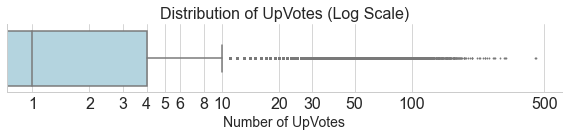

In [870]:
make_box_plot('UpVotes', df_posts)

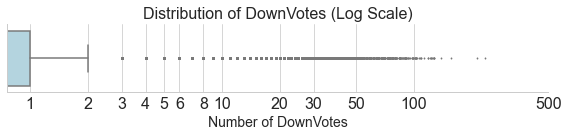

In [871]:
make_box_plot('DownVotes', df_posts)

### Step 2.2. Heatmap of Positive and Negtive Votes

In order to analyzse the distribution further, a heatmap is generated.

In [55]:
# Define custom intervals for UpVotes and DownVotes
positive_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]
negative_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]

# Create result DataFrame with named columns and rows
result_df = pd.DataFrame(0, index=[f'{interval[0]}-{interval[1]}' for interval in negative_intervals],
                         columns=[f'{interval[0]}-{interval[1]}' for interval in positive_intervals])

# Iterate through each post and update the count in the result DataFrame
for _, row in df_posts.iterrows():
    neg_interval = None
    pos_interval = None

    
    # Find the index of the negative interval
    for i, interval in enumerate(negative_intervals):
        if interval[0] <= row['DownVotes'] <= interval[1]:
            neg_interval = i
            break
            
    # Find the index of the positive interval
    for i, interval in enumerate(positive_intervals):
        if interval[0] <= row['UpVotes'] <= interval[1]:
            pos_interval = i
            break
    
    if neg_interval is not None and pos_interval is not None:
        result_df.iloc[neg_interval, pos_interval] += 1
        # row = interval for downvoates - column = interval for upvotes


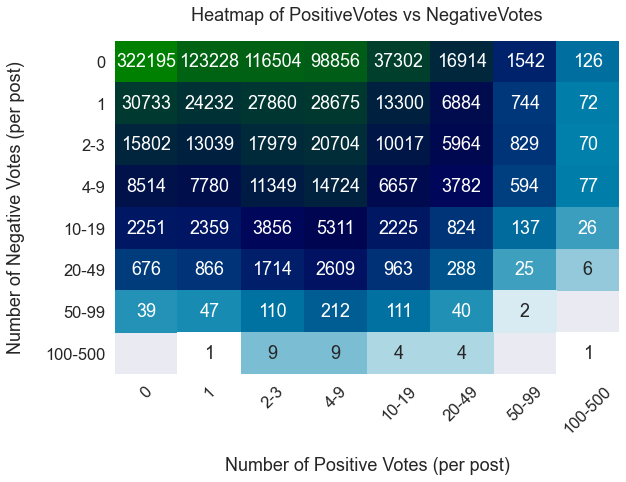

In [56]:

# Rename columns and index
result_df.rename(columns={'1-1': '1', '0-0': '0'}, 
                 index={'1-1': '1', '0-0': '0'}, 
                 inplace=True)

# Get the colormap 
cmap = cm.get_cmap('ocean')
# Flip the colormap
flipped_cmap = cmap.reversed()

# Set font scale for the heatmap and axis labels
sns.set(font_scale=1.5)  # Adjust font scale as needed

# Plot heatmap for UpVotes with logarithmic color scale
plt.figure(figsize=(10, 8))
sns.heatmap(result_df, cmap=flipped_cmap, annot=True, fmt='d', cbar=False, 
            norm=LogNorm(vmin=1, vmax=result_df.max().max()))
plt.title('Heatmap of UpVotes vs DownVotes', pad=20)  # Adjust title padding
plt.xlabel('Number of Positive Votes (per post)', labelpad=20)  # Adjust x label padding
plt.ylabel('Number of Negative Votes (per post)', labelpad=20)  # Adjust y label padding
plt.xticks(rotation=45)  # Rotate x ticks for better visibility
plt.yticks(rotation=0)   # Rotate y ticks for better visibility
plt.tight_layout(pad=3.0)  # Adjust padding between plot and figure edges


plt.savefig("./figures/heatmap.png", dpi=300, bbox_inches='tight' )
plt.show()


### Step 2.3. Overview of all posts

Next we generate an overview about how many posts have at least one vote (positive or negative), at least one positive or at least one negative votes.

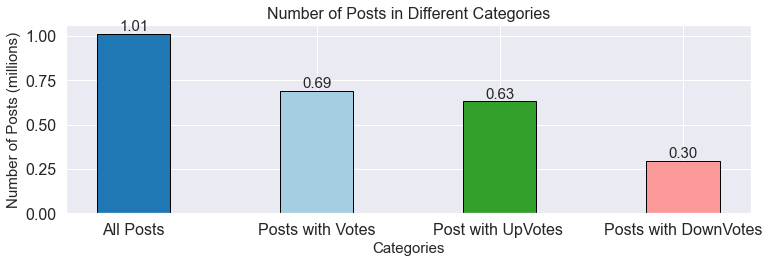

In [57]:
all_posts = df_posts["ID_Post"].count()
all_posts_with_votes = df_posts[(df_posts["UpVotes"] > 0) | (df_posts["DownVotes"] > 0)]["ID_Post"].count()
positive_posts = df_posts[(df_posts["UpVotes"] > 0)]["ID_Post"].count()
negative_posts = df_posts[(df_posts["DownVotes"] > 0)]["ID_Post"].count()

# Convert values to millions
all_posts /= 1e6
all_posts_with_votes /= 1e6
positive_posts /= 1e6
negative_posts /= 1e6

# Define categories and their corresponding values
categories = ['All Posts', 'Posts with Votes', 'Post with UpVotes ', 'Posts with DownVotes']
values = [all_posts, all_posts_with_votes, positive_posts, negative_posts]

# Choose a more suitable color palette
colors = ['#1F78B4', '#A6CEE3',   '#33A02C', '#FB9A99']
# Create bar plot
plt.figure(figsize=(11, 4))
bars = plt.bar(categories, values, color=colors, 
               edgecolor='black', width=0.4)  

# Add labels and title
plt.xlabel('Categories', fontsize=15)
plt.ylabel('Number of Posts (millions)', fontsize=15)
plt.title('Number of Posts in Different Categories', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the value on top of each bar with larger font size
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=15)

# Save the plot
plt.savefig('./figures/bar_plot.png', dpi=300, bbox_inches='tight')
# Show plot
plt.tight_layout()
plt.show()



In [ ]:
print(f"The median number of Upvotes is: { df_posts.UpVotes.median() }")
print(f"The median number of Downvotes is: { df_posts.DownVotes.median() }")


print(f"The mean number of Upvotes is: { df_posts.UpVotes.mean() }")
print(f"The mean number of Downvotes is: { df_posts.DownVotes.mean() }")

### Step 2.4. Looking at the Data

Next we look at a few example for posts with more than 10 upvotes or posts with more than 10 downvotes.

In [59]:
df_posts[df_posts["UpVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
108,,Ist es schon überarbeitet? Ich möchte wieder so berühmt werden wie früher. Das hat mir damals sagenhaft viele perverse Kontakte verschafft.
109,"""Multiuser"" und ""Bewertungsuser""?","Gibt es eine Meldeadresse/-stelle an die man sich wenden kann, wenn man annimmt einen ""Multiuser"" (mehrfach registrierten Benutzer) gefunden zu haben? Und was ist mit Usern die schon länger registriert sind, selbst 0 Postings verfasst haben und in Threads auffallend oft von oben bis unten durchgehend nur mit rot oder grün bewerten?"
157,Zugriff zu den eigenen ...,...posts bzw. Konto wäre eine gute Erweiterung....
189,"Oh, wie schön, heute ist m e i n Tag! :-)","Beste Grüße an alle Mit-Lefties dieser Erde und auch Nicht-Erde!!! Erfahrungen: # wirkliche Probleme, sehr eindrücklich als Kind zB beim Werken/Basteln, haben mir immer bestimmte Scheren gemacht (die z.B. dann total in der Hand weh tun, wenn links gehalten, oder einfach eher reißen als schneiden) # das eindrücklichste Erlebnis ist ein paar Jahre her: in einer Café-Lokation auf der Wiener Währinger Straße wurde mir meine Melange in einer Tasse serviert, deren ""ergonomisch"" schiefer/geschwungener Griff für eine rechte Hand (wohl) sehr gut passt - mit der linken Hand kann man das Häferl dadurch aber praktisch kaum halten... # beim Sporteln war mein Lefty-tum, glaub ich, immer nur ein Vorteil :-) ;-)"
206,,"wenn mir jemand bezüglich meiner handwerklichen Fähigkeiten gesagt hat, dass ich zwei Linke habe, habe ich mich für das Komplement bedankt."
215,,"am allerschlimmsten sind saucenschöpfer mit schnabel... da kann ich machen was ich will, ich kann diese teile einfach nicht bedienen.. die sauce rinnt überall hin, nur nicht auf den teller..."
289,,"Die Meinl-Häferln sind wirklich eine sinnlose Geschichte. Glückwunsch an den Designer für Hirnlosigkeit im Dienst - auch wenn es Linkshänder-Exemplare theoretisch geben tät, kein Restaurant würde die bestellen. Scheren sind ein kleines Problem, wobei ich mir mit einer Linkshänderschere auch weh tu - weil schon zu lange an die falschen Scheren gewohnt. Wenn man sich aber ausschließlich mit Linkshänderprodukten umgibt, ""sperrt"" man sih quasi von der dominierenden Rechtshänderwelt ab. Letztendlich drängt einem das Linkshändertum ein wenig, den Individualisten zu spielen - mir hat's nicht geschadet, oder ich merk's nicht."
297,,"Meine Großmutter hat mir mal erzählt, dass sie in der Schule noch geohrfeigt wurde, weil sie Linkshänderin war. Umlernen wurde gefordert, nicht nur in der Schule, sondern auch vom Elternhaus (natürlich auch mit Prügel verbunden) - kann mir nicht vorstellen, was für Leid das in einem Kind/Jugendlichen verursacht, wegen so einer Lappalie unter Druck gesetzt und verdroschen zu werden. Heute kann sie beide Hände fast gleich nutzen, präferiert bei den meisten Sachen jedoch die Linke."
347,,"Als Linkshänder, welcher die Computer Maus mit der rechten bedient, kann ich gleichzeitig etwas (ab)schreiben und mit der Maus am Computer zB Textstellen markieren und scrollen ;)"
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot


In [60]:
df_posts[df_posts["DownVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
235,,Zum Sport: Wer schießt (wie ich) beim Fußball mit rechts? Wer ist links unterwegs? rot=links grün=rechts
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot
759,,"schön. Bis zu jenem Tag, als die Trabis die Mariahilferstraße verstopft haben mit den Waschmaschinen am Dachl."
884,,"Ich hab jene Ostdeutschen bedauert, die den Versprechungen von Kohl und Genscher geglaubt haben."
1085,,"Wenn das so schlimm war, wieso hast sie dann überhaupt wiedergesehen? Oder wars nur für eine Nacht?"
1113,,das is ja wirklich grauslich - ich hätt' Euch auch nicht rein gelassen
1120,,In London gibts außergewöhnlich gute Hotels. Man muss sie sich halt leisten können und wollen. ;-)
1123,,DAnn frage ich dich nochmal: Was war damals an dem Erlebnis so schlimm?
1129,,"Im Nachhinein ist was anderes, ich glaube, hier gehts darum, welches Hotelerlebnis man im Moment des Erlebens als schlimm empfand. Also eher off topic, hier von kaputten späteren Beziehungen zu plaudern. :-)"
1251,,"dann graust mir davor, wie Dich Deine Ex-Frau umgedreht hat *brr*"


Most interestingly we see here for example that users misuse the functionality the downvotes and upvotes to start a survey (as shown in the first two rows).

## Step 3: Feature Generation

Next we generate the features to train our models with.

### Step 3.1: Main Feature Generation

#### Explorative Feature Analysis

In [443]:
patterns = { 
    
    'LongWords': re.compile(r'\b[A-ZÄÖÜa-zäöüß]{17,}\b'),
    'LongWordCombo': re.compile(r'\b[A-ZÄÖÜa-zäöüß]{13,}(\s|-)+[A-ZÄÖÜa-zäöüß]{13,}\b'),
    'ShortWords': re.compile(r'\b[A-ZÄÖÜa-zäöüß]{2,5}\b'),
    'ShortWordCombo': re.compile(r'\b[A-ZÄÖÜa-zäöüß]{2,5}(\s|-)+[A-ZÄÖÜa-zäöüß]{2,5}\b'),
    
    'ConsicePhrase': re.compile(r'([A-ZÄÖÜa-zäöüß]{4,}\.{1}|^)\s+[A-ZÄÖÜa-zäöüß]{4,}(\.{1}|\,{1})'),
    'RepeatedWords': re.compile(r'((\s|^)+[A-ZÄÖÜa-zäöüß]{6,}(\s|\.|\,)+)[\s\S\r\n]*\1',),
    'Exaggerate': re.compile(r'!{2,}|\?{2,}|[A-ZÄÖÜ]{4,}'),
    
    'Affection':  re.compile(r'\b((liebe)|(wunder(schön|bar|voll)+|herrlich|grandios|großartig|fantastisch)+(e|r|s)*)\b', re.IGNORECASE),
    'Wondering':  re.compile(r'\b(ich|mich)\s+(wunder(t)*|frage|überlege)\b', re.IGNORECASE),
    'Desire': re.compile(r'\b(ich)\s+(hoff|wünsch|sehne|verlang)(e)*\b', re.IGNORECASE),
    
    'OnlySymbols': re.compile(r'^[\W\s\d]+$'),
    'OnlyWords': re.compile(r'^[\w\d]+$'),
    'NoCapsShort': re.compile(r'^[a-zäöüß\s\W\d]{1,50}$'),
    'OnlyLink': re.compile(
        r'^(ht+ps*\s?:*\s?\/+(upload\.|de\.|en\.)*|w+\s?\.r*i*s*\.*|m+\s?\.)+' 
       r'\s?(\w+-*\w*-*\w*)(.gv|.europa)*\.*\s?(com|tv|info|co|at|eu|adww|de|ch|uk|org|net|ee)' 
       r'(\s?\/\s?\S*)*$'
    ),
    
    'Uncompassion': re.compile(r'^(?=.{1,20}$).*\b(lol|wtf|ok(ay)*|also|eh|schon|\.\.\.|hm|klar|toll|passt)\b.*', 
                              re.IGNORECASE),
    'Formality': re.compile(r'\b(Sie|Ihr(e|n)*)\b'),
    'Profanity': re.compile(r'\b((voll)*(idiot|depp|trottel|wappler)(e|n)*|scheiß(e|n)*|fick(t|e)*|wichs(e|r)*|mist|arsch(l(o|ö)che*r*)*|verpiss(t)*)\b', re.IGNORECASE),
    'EmojiPositive': re.compile(r'(:\s*(-|\^)*\s*(\)|>|D\s*|3)|(\(|<)\s*(-|\^)*\s*:|<\s*3)'),
    'EmojiNegative': re.compile(r'(:\s*(-|\^)*\s*(\(|<|8|\[|\|)|\s+(\)|>|\^)\s*(-|\^)?\s*:)'),
    'EmojiSurprise': re.compile(r':\s*-*\s*(o|O)+(\s|$|\)|\()+'),
    'EmojiSarcastic': re.compile(r'(;\s*(-|\^)*\s*(\)|>)|(\(|<)\s*(-|\^)*\s*;)'),
    'Exclaim': re.compile(r'!'),
    'Period': re.compile(r'\.'),
    'Quote': re.compile(r'["\']'),
    'Question': re.compile(r'\?', re.IGNORECASE),
    'CapLetter': re.compile(r'[A-ZÄÖÜ]'),
    'FullCaps': re.compile(r'\b[A-ZÄÖÜ]{2,}\b'),
    'FirstSing': re.compile(r'\b(ich|mich|mir|mein(e|r)*)\b', re.IGNORECASE),
    'FirstPlural': re.compile(r'\b(wir|uns(e|r)*)\b', re.IGNORECASE),
    'SecondPlural': re.compile(r'\b(ihr|euch|euer(e|r)*)\b', re.IGNORECASE),
    'Digits': re.compile(r'\d+', re.IGNORECASE),
    'Conjunctive': re.compile(r'\b(hätt(e|n)*|würd(e|n)*|wär(e|n)*|könnt(e|n)*|sollt(e|n)*|müsst(e|n)*)\b', re.IGNORECASE),
    'ModalObligation': re.compile(r'\b(m(u|ü)sse*n|d(a|ü)rfe*n*|sollt*(e|n)*)\b', re.IGNORECASE),
    'ModalPossibility': re.compile(r'\b(k(a|ö)nne*n*|w(i|o)lle*n)\b', re.IGNORECASE),
    'PastTense': re.compile(r'\b(ware*n*|damals|hatte|wurden*|machten*|ginge*n*|kame*n*)\b', re.IGNORECASE),
    
}


In [456]:
import warnings
# Suppress specific UserWarning
warnings.filterwarnings('ignore', message='This pattern has match groups.')

def get_prediction_estimate(df, patterns):
    """
    Analyzes Votes trends in a DataFrame by examining the influence of patterns
    in text columns on Votes metrics.

    Parameters:
    - df : pd.DataFrame
        DataFrame containing text and Votes data.
    - patterns : dict
        Dictionary where keys are descriptive pattern names and values are compiled regex patterns 
        to match within the 'FullText' column.

    Returns:
    - result_df : pd.DataFrame
        A DataFrame containing the Votes analysis results for each pattern, with columns:
        ['Pattern', 'Higher_Count', 'Lower_Count', 'Neutral_Count', 'Majority_Category', 'Examples']
    """

    # Initialize a list to store results
    results = []

    # Iterate through each pattern in the dictionary
    for pattern_name, pattern in patterns.items():
        # Filter rows where 'FullText' contains the given pattern
        filtered_df = df[df['FullText'].str.contains(pattern, na=False)].copy()
        
        if filtered_df.empty:
            # Skip patterns with no matches
            continue

        # Define conditions to categorize each row's Votes level
        filtered_df.loc[:, 'Votes_Category'] = filtered_df.apply(
            lambda row: 'Higher' if row['UpVotes'] > row['article_vote_median_tc']
            else ('Lower' if row['UpVotes'] < row['article_vote_median_tc']
            else 'Neutral'), 
            axis=1
        )

        # Calculate category counts
        category_counts = filtered_df['Votes_Category'].value_counts()
        higher_count = category_counts.get('Higher', 0)
        lower_count = category_counts.get('Lower', 0)
        neutral_count = category_counts.get('Neutral', 0)

        # Determine the majority case
        majority_case = category_counts.idxmax()
        
        # Get examples with context for the pattern matches
        examples = []
        for _, row in filtered_df[filtered_df['Votes_Category'] == majority_case].head(3).iterrows():
            examples.append({
                'Pattern': pattern_name,
                'FullText': row['FullText'],
                'UpVotes': row['UpVotes'],
                'DownVotes': row['DownVotes'],
                'ArticleTitle': row['ArticleTitle'],
                'article_vote_median': row['article_vote_median']
            })

        # Append the results for this pattern
        results.append({
            'Pattern': pattern_name,
            'Higher_Count': higher_count,
            'Lower_Count': lower_count,
            'Neutral_Count': neutral_count,
            'Majority_Category': majority_case,
            'Examples': examples,
        })

    # Convert results to a DataFrame for structured output
    result_df = pd.DataFrame(results)
    
    # Ensure proper indentation and syntax for if-elif-else statements
    result_df['Ratio_High_To_Low'] = np.where(result_df['Majority_Category'] == 'Higher', 
                                              result_df['Higher_Count'] / result_df['Lower_Count'], 
                                              np.where(result_df['Majority_Category'] == 'Lower', 
                                              result_df['Lower_Count'] / result_df['Higher_Count'], 
                                              0)
    )
    
    # Create a sorting key to differentiate ascending for "Lower" and descending for "Higher"
    result_df['Sorting_Key'] = result_df.apply(
        lambda row: row['Ratio_High_To_Low'] if row['Majority_Category'] == 'Lower' else -row['Ratio_High_To_Low'], 
        axis=1
    )
    # Sort by Majority_Category and then by the Sorting_Key
    result_df.sort_values(["Majority_Category", "Sorting_Key"], ascending=[True, True], inplace=True)
    # Drop the temporary Sorting_Key column
    result_df.drop(columns=['Sorting_Key'], inplace=True)

    return result_df


# Extract examples for a specific pattern (e.g., "exclamation") into a structured DataFrame
def extract_examples(result_df, pattern_name):
    # Filter the result_df for the specified pattern and extract its examples
    pattern_examples = result_df[result_df['Pattern'] == pattern_name]['Examples'].explode().dropna()
    example_df = pd.DataFrame(pattern_examples.tolist())  # Flatten into a structured DataFrame
    return example_df

In [363]:
from PIL import Image, ImageDraw, ImageFont
import io
import IPython.display as display
import re

def wrap_text(text, max_width, font, max_length=250, highlighted_pattern=None):
    """Wrap text to fit within a maximum width, ensuring at least one occurrence of the highlighted pattern remains visible."""

    # Find all matches of the highlighted pattern
    matches = list(re.finditer(highlighted_pattern, text)) if highlighted_pattern else []

    if len(text) > max_length:
        if matches:
            # Ensure at least one occurrence of the pattern remains visible
            first_match_start = matches[0].start()
            first_match_end = matches[0].end()
            visible_pattern = text[first_match_start:first_match_end]

            # Decide how to truncate the text
            if first_match_start > max_length // 2:
                # Pattern is in the latter half of the text: trim from the front
                text = "[...] " + text[first_match_start - (max_length // 2):]
            elif len(text) - first_match_end > max_length // 2:
                # Pattern is in the first half: trim from the back
                text = text[:first_match_end + (max_length // 2)] + " [...]"
            else:
                # Pattern is roughly in the middle: trim from both sides
                start_index = max(0, first_match_start - (max_length // 4))
                end_index = min(len(text), first_match_end + (max_length // 4))
                text = "[...] " + text[start_index:end_index] + " [...]"
        else:
            text = text[:max_length] + " [...]"

    # Split text into lines based on maximum width
    words = text.split()
    lines = []
    current_line = []
    current_width = 0

    for word in words:
        word_width = font.getsize(word + " ")[0]  # Add space width
        if current_width + word_width > max_width:
            lines.append(" ".join(current_line))
            current_line = [word]
            current_width = word_width
        else:
            current_line.append(word)
            current_width += word_width
    
    if current_line:
        lines.append(" ".join(current_line))

    return "\n".join(lines)



def create_highlighted_image(article_title, text, highlighted_pattern, 
                             upvotes, downvotes, median_upvotes, pattern_name, max_width=700):
    """
    Create an image with wrapped text, highlighted pattern, and metadata.
    """
    # Ensure the title is at most 60 characters
    if len(article_title) > 60:
        article_title = article_title[:65] + " [...]"

    # Set up font
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()

    # Estimate image height dynamically based on content
    title_height = font.getsize(article_title)[1] + 10  # Title height with some margin
    wrapped_text = wrap_text(text, max_width - 100, font, max_length=150, highlighted_pattern=highlighted_pattern)
    text_lines = wrapped_text.split("\n")
    text_height = len(text_lines) * font.getsize(text_lines[0])[1] +30
    metadata_height = font.getsize("Sample text")[1] + 10  # Space for metadata
    total_height = title_height + text_height + metadata_height + 60  # Total dynamic height with margins

    # Create image
    img = Image.new('RGB', (800, total_height), color='white')
    draw = ImageDraw.Draw(img)

    # Title
    draw.text((20, 10), "ArticleTitle: " + article_title, font=font, fill='black')
    draw.line((20, 40, 780, 40), fill='black', width=2)  # Line under the title

    # Wrap text and draw text box
    text_start_y = 50  # Directly below the title
    draw.rectangle([(20, text_start_y), (780, text_start_y + text_height + 60)], outline='black', width=2)

    # Render wrapped text
    current_y = text_start_y + 10
    pattern = re.compile(highlighted_pattern)

    for line in text_lines:
        match = pattern.search(line)
        if match:
            # Highlight the matching pattern
            start_index = match.start()
            end_index = match.end()
            pattern_start_x = 30 + font.getsize(line[:start_index])[0]
            pattern_end_x = 30 + font.getsize(line[:end_index])[0]
            draw.rectangle(
                [(pattern_start_x, current_y), (pattern_end_x, current_y + font.getsize(line)[1])],
                fill='#71D3FF'
            )
        draw.text((30, current_y), line, font=font, fill='black')
        current_y += font.getsize(line)[1]

    # Add metadata below the text box
    current_y += 20
    metadata = f"  - Upvotes: {upvotes}; Median Upvotes (for posts appearing in the comment section): {int(median_upvotes)}; "
    draw.text((20, current_y), metadata, font=font, fill='black')

    # Display image
    buf = io.BytesIO()
    img.save(buf, format='PNG')
    buf.seek(0)
    display.display(display.Image(data=buf.read()))

    # Save the image to a file
    img.save('highlighted_pattern_'+ pattern_name + '.png')



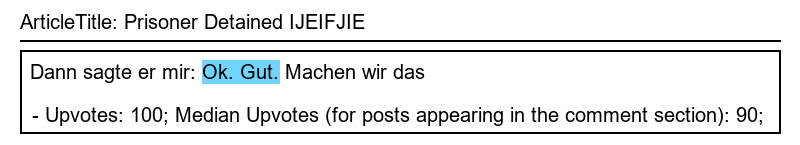

In [364]:
create_highlighted_image(
    article_title="Prisoner Detained IJEIFJIE",
    text="Dann sagte er mir: Ok. Gut. Machen wir das",
    highlighted_pattern=re.compile(r'\w{2,}\.{1} +\w{2,}(\.|\,)'),
    upvotes=100,
    downvotes=5,
    pattern_name = "Test",
    median_upvotes=90
)


In [369]:
df_merged.shape

(512480, 152)

In [458]:
# ignore warning about regex groups - since we only check for their existence this is not important
import warnings
# Suppress specific UserWarning
warnings.filterwarnings('ignore', message='This pattern has match groups.')


# Run the function and get result
result_df = get_prediction_estimate(df_merged, patterns)


result_df[['Pattern', 'Higher_Count', 'Neutral_Count', 'Lower_Count', 'Majority_Category', 'Ratio_High_To_Low']].style

,Pattern,Higher_Count,Neutral_Count,Lower_Count,Majority_Category,Ratio_High_To_Low
8,Wondering,628,90,318,Higher,1.974843
7,Affection,2641,453,1464,Higher,1.803962
9,Desire,1397,270,806,Higher,1.733251
1,LongWordCombo,10815,2162,7306,Higher,1.480290
16,Profanity,1346,289,940,Higher,1.431915
5,RepeatedWords,48134,9868,33937,Higher,1.418334
28,FirstPlural,29356,5795,20785,Higher,1.412365
4,ConsicePhrase,5882,1220,4222,Higher,1.393179
29,SecondPlural,8596,1699,6234,Higher,1.378890
0,LongWords,56164,11755,41435,Higher,1.355472


In [366]:
# ignore warning about regex groups - since we only check for their existence this is not important
import warnings
# Suppress specific UserWarning
warnings.filterwarnings('ignore', message='This pattern has match groups.')

patterns_to_investigate = {
    
    #'Affection1': re.compile(r'\b(liebe)\b'),
    'profanity': re.compile(r'\b((voll)*(idiot|depp|trottel|wappler)(e|n)*|scheiß(e|n)*|fick(t|e)*|wichs(e|r)*|mist|arsch(l(o|ö)che*r*)*|verpiss(t)*)\b', re.IGNORECASE),
}



# Run the function and get result
result_df_new = get_prediction_estimate(df_merged, patterns_to_investigate)


result_df_new[['Pattern', 'Higher_Count', 'Neutral_Count', 'Lower_Count', 'Majority_Category', 'Ratio_High_To_Low']].style

,Pattern,Higher_Count,Neutral_Count,Lower_Count,Majority_Category,Ratio_High_To_Low
0,profanity,1346,289,940,Higher,1.431915


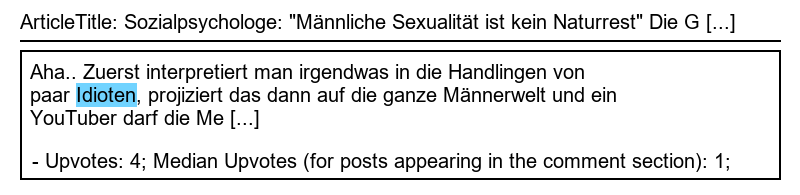

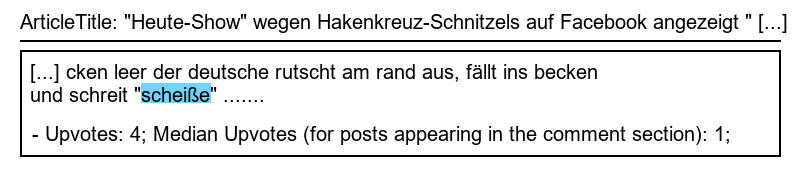

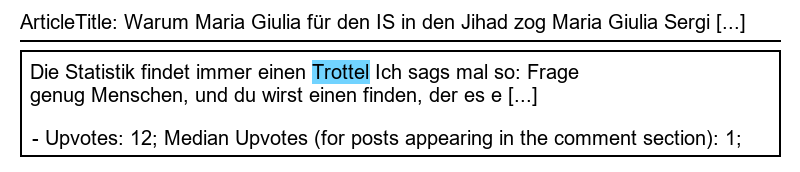

,Pattern,FullText,UpVotes,DownVotes,ArticleTitle,article_vote_median
0,Profanity,"Aha.. Zuerst interpretiert man irgendwas in die Handlingen von paar Idioten, projiziert das dann auf die ganze Männerwelt und ein YouTuber darf die Meinung der Männer zu diesem Thema vertreten? Total seriös..",4,3,"Sozialpsychologe: ""Männliche Sexualität ist kein Naturrest"" Die Gemeinsamkeiten zwischen männlichen Flüchtlingen und hiesigen Männern sind größer als die Unterschiede, sagt Sozialpsychologe Rolf Pohl. Viele verbinde ein im Kern abwertendes Frauenbild",1.000000
1,Profanity,"ein österreicher, ein tscheche und ein deutscher stehn vor einem wünschelschwimmbad. jeder darf sich wünschen mit was sich das becken füllen soll und dann reinspringen. der österreicher ruft ""wein"" und springt hinein und trinkt das becken leer der tscheche ruft ""bier"" und springt hinein und trinkt das becken leer der deutsche rutscht am rand aus, fällt ins becken und schreit ""scheiße"" .......",4,0,"""Heute-Show"" wegen Hakenkreuz-Schnitzels auf Facebook angezeigt ""Österreicher wählen eben so, wie sie es vom Schnitzel kennen: möglichst flach und schön braun"": Tiroler Student zeigte ZDF-Sendung an",1.000000
2,Profanity,"Die Statistik findet immer einen Trottel Ich sags mal so: Frage genug Menschen, und du wirst einen finden, der es ernst meint, dass die Kinder der Storch bringt. Anders ausgedrückt: Der Blödsinn kann gar nicht groß genug sein, dass sich nicht ein Kopf finden lässt, der klein genug ist, wo er hinein passt.",12,0,"Warum Maria Giulia für den IS in den Jihad zog Maria Giulia Sergio ist nach Syrien ausgewandert. Es ist die Frage, warum eine junge italienische Frau sich radikalisierte, die die Öffentlichkeit beschäftigt",1.000000


In [368]:
# Extract examples for a specific pattern (e.g., "exclamation") into a structured DataFrame
def extract_examples(result_df, pattern_name=None):
    # Filter the result_df for the specified pattern and extract its examples
    if pattern_name != None:
        pattern_examples = result_df[result_df['Pattern'] == pattern_name]['Examples'].explode().dropna()
        example_df = pd.DataFrame(pattern_examples.tolist())  # Flatten into a structured DataFrame
    else:
        pattern_examples=result_df['Examples'].explode().dropna()
        example_df = pd.DataFrame(pattern_examples.tolist())  # Flatten into a structured DataFrame
        pattern_name = example_df["Pattern"][1]
        
    example_counter=0
    for _, row in example_df.iterrows():
        
        if example_counter<3:
            create_highlighted_image(
                article_title=row["ArticleTitle"],
                text=row["FullText"],
                highlighted_pattern=patterns[pattern_name],
                upvotes=row["UpVotes"],
                downvotes=row["DownVotes"],
                median_upvotes=row["article_vote_median"],
                pattern_name=pattern_name
            )
            example_counter += 1
        else:
            pass
    
    return example_df

# Get examples as a structured DataFrame
exclamation_examples_df = extract_examples(result_df, pattern_name="Profanity")
exclamation_examples_df.style

In [258]:
# Define the sarcastic emoji pattern
sarcastic_emoji_pattern = re.compile(r'\?')

# Assuming df_merged is already loaded in the environment, re-run the filter
# Filter rows where the 'FullText' column matches the sarcastic emoji pattern
matching_posts = df_merged[df_merged['FullText'].str.contains(sarcastic_emoji_pattern, na=False)]
matching_posts.head(30)[["FullText", "UpVotes"]].style


,FullText,UpVotes
6,"das zeigt es ihnen ""gefühlt"" vielleicht. Objektiv zeigt es, ganz banal: Österreich ist in den letzzten Jahrzehnten sicherer geworden. Da gibt es Hotspots und Wellen, aber es ist doch wohl jedem einigermaßen in Relationen und Kontexten denkendem Zeitgenossen klar, dass ""die Asylanten"" zwar für Schlagzeilen sorgen, die Welt (in Österreich) deshalb nicht unsicherer geworden ist. Aber für manche gilt halt: je mehr Aufregung und Empörung im (ca. virtuellen) Blätterwald, desto gefährlicher die Realität. Kann nicht sein, habs doch gelesen! in den Achzigern wurde ich und ein Freund in Graz dermaßen vermöbelt, dass wir aus mehreren Öffnungen heftig bluteten und fast nicht mehr gehen konnten. x Zähne futsch Täter: 4 Steirer im karierten Flanellhemd. Grund: die Vier: ""wo is die disco xy?"" Freuind: Neben eich, hobts eire guggis im oasch?""",11
11,für Wien reicht es 6x Meister in 10 Jahren. Ratetipp: Wie oft wurde Rapid in den letzten 5 Jahren Meister? 1x 2x 3x und wie oft Salzburg?,2
17,Ist die IS ein Militärdienst eines fremden Staates?,0
21,wie alt simma denn ? klingt nach Berufsstudent ;-),0
22,"okay, nur wo kommen wir dann hin? Wenn eh ""jedes Bit"" die eine oder andere Datenschutzverletzung darstellt? Alles abdrehn' und zurück zum Telefax?",1
28,"Wie wäre es mit Menschenrechten, Säkularismus und Humanismus und Wissenschaft?",5
31,"Die Rekrutieren in Europa - wieso solln die es notwendig haben irgendjemanden hier ""einzuschleusen""?",0
35,"Weiß nicht, ob mein Posting durchkommt, aber Sie lenken ab. Nur weil jemand kein Flüchtling nach GFK ist, soll er gleich Wirtschaftsflüchtling sein? Abgesehen davon, ist das Stellen eines Asylantrags ein Menschenrecht!",0
36,"Hawi, bist heute in der Früh wieder beim Türststock angrennt?",0
37,"Hilflose arme Hascherl, in Panik durcheinander rennend. Geistige Titanen, rhetorisch perfekt mit Wissen, dem keiner gleichkommen kann, treiben die armen, ehrlichen, guten Schafe vor sich her. Wer soll das glauben? Was für eine lächerliche, resignierende, peinliche Geisteshaltung. ""Autoritärer Führerstaat""? A geh, und der Rest hofft auf Kern als ebenfalls endlich autoritären, neuen Retter der Nation. Politiker Diskurs für Dummies, Teil 1.",11


In [ ]:
# ignore warning about regex groups - since we only check for their existence this is not important
import warnings
# Suppress specific UserWarning
warnings.filterwarnings('ignore', message='This pattern has match groups.')


# Run the function and get result
result_df = get_prediction_estimate(df_merged, patterns)
result_df.sort_values(["Majority_Category", "Ratio_High_To_Low"], ascending=[True, False], inplace=True)

result_df[['Pattern', 'Higher_Count', 'Neutral_Count', 'Lower_Count', 'Majority_Category', 'Ratio_High_To_Low']].style

#### Generate Features

In [377]:
def calculate_frequency(text, pattern):
    """Calculate the frequency of a given pattern in the text."""
    if pd.isnull(text):
        return 0
    return len(re.findall(pattern, text))


def calculate_ratio(numerator, denominator):
    """Calculate the ratio of two values."""
    if denominator == 0:
        return 0
    return numerator / denominator


def calculate_ari(char_count, word_count, sent_count):
    """
    Calculate the Automated Readability Index (ARI).
    ARI = 4.71 * (characters/words) + 0.5 * (words/sentences) - 21.43
    """
    if word_count == 0 or sent_count == 0:
        return 0
    return 4.71 * (char_count / word_count) + 0.5 * (word_count / sent_count) - 21.43


def calculate_flesch(word_count, syllable_count, sent_count):
    """
    Calculate the Flesch Reading Ease score for German.
    FRE (German) = 180 - (words / sentences) - (58.5 * syllables / words)
    """
    if word_count == 0 or sent_count == 0:
        return 0
    return 180 - (word_count / sent_count) - (58.5 * syllable_count / word_count)


def calculate_smog(sent_count, polysyllable_count):
    """
    Calculate the SMOG readability score.
    SMOG = 1.043 * sqrt(30 * (polysyllables / total_sentences)) + 3.1291
    """
    if sent_count == 0:
        return 0
    return 1.043 * (30 * polysyllable_count / sent_count) ** 0.5 + 3.1291



def count_syllables(word):
    """Count the number of syllables in a German word."""
    vowels = "aeiouäöü"
    diphthongs = ["au", "ei", "eu", "ie"]  # Common German diphthongs
    word = word.lower()
    syllables = 0

    # Handle diphthongs as single vowels
    for diphthong in diphthongs:
        word = word.replace(diphthong, "*")  # Replace with a placeholder

    # Count vowels (and placeholders for diphthongs)
    for i in range(len(word)):
        if word[i] in vowels or word[i] == "*":
            # Count only if it's the start or not preceded by another vowel
            if i == 0 or word[i - 1] not in vowels + "*":
                syllables += 1

    return syllables


def count_total_syllables(text):
    """Count the total number of syllables in a text."""
    if pd.isnull(text):
        return 0
    return sum(count_syllables(word) for word in text.split())


def count_polysyllables(text):
    """Count the total number of polysyllabic words in a text."""
    if pd.isnull(text):
        return 0
    return sum(1 for word in text.split() if count_syllables(word) >= 3)


def extract_features(df):
    """
    Integrate all features into the dataframe based on the FullText column.
    Includes readability metrics such as ARI, Flesch Reading Ease, and SMOG score.
    """
    
    def calculate_features(full_text):
        # Counts
        word_count = len(full_text.split())
        sent_count = len(re.split(r'[.!?]', full_text)) - 1 if len(re.split(r'[.!?]', full_text)) > 1 else 1
        
        features = {
            'WordCount': word_count,
            'UniqueWords': len(set(full_text.split())),
            'CharCount': len(full_text),
            'PunctCount': sum(c in string.punctuation for c in full_text),
            'SentCount': sent_count,
            'SyllableCount': count_total_syllables(full_text),
            'PolysyllableCount': count_polysyllables(full_text),
            **{f"{key}_Freq": calculate_frequency(full_text, pattern) for key, pattern in patterns.items()},

            # Ratios
            'PunctToTextRatio': calculate_ratio(sum(c in string.punctuation for c in full_text), len(full_text)),
            'DiversityRatio': calculate_ratio(len(set(full_text.split())), len(full_text.split())),
            'AvgSentLength': calculate_ratio(word_count, sent_count),
            'AvgWordLength': calculate_ratio(sum(len(word) for word in full_text.split()), word_count),
            'WordsPer100Chars': calculate_ratio(word_count, len(full_text) / 100) if len(full_text) > 0 else 0,
            'CapToLowerRatio': calculate_ratio(calculate_frequency(full_text, r'[A-Z]'), calculate_frequency(full_text, r'[a-z]')),

            # Readability Metrics
            'ARIScore': calculate_ari(len(full_text), word_count, sent_count),
            'FleschEaseScore': calculate_flesch(word_count, count_total_syllables(full_text), sent_count),
            'SMOGScore': calculate_smog(sent_count, count_polysyllables(full_text)),
        }
        return features
    
    # Apply the feature calculation function to the FullText column
    feature_df = df['FullText'].progress_apply(calculate_features).copy()

    # Convert feature rows to a DataFrame
    feature_df = pd.DataFrame(feature_df.tolist()).copy()

    # Assign features back to the original dataframe
    for column in feature_df.columns:
        df[column] = feature_df[column].copy()



# Apply feature extraction
extract_features(df_merged)


100%|█████████████████████████████████████████████████████████████████████████| 512480/512480 [11:57<00:00, 714.56it/s]


### Step 2.3: Sentiment Feature Generation

In [378]:
from sklearn.preprocessing import MinMaxScaler

if "SentimentScore" not in df_merged.columns:
    # Append the generated sentiment score (that was predicted in file sentiment analysis)
    df_sentiment = pd.read_pickle("./data/sentiment_dataframe.pkl")[["ID_Post", "sentiment_score"]]
    df_sentiment.rename(columns={"sentiment_score": "SentimentScore"}, inplace=True)
    
    # Merge the sentiment scores into df_merged
    df_merged = df_merged.merge(df_sentiment, on="ID_Post", how="left")
    
    # Min-Max scale the SentimentScore
    scaler = MinMaxScaler()
    df_merged["SentimentScore"] = scaler.fit_transform(df_merged[["SentimentScore"]])
    
    # Create binary features for strongly positive and strongly negative sentiment
    df_merged["StronglyPositive"] = (df_merged["SentimentScore"] > 0.9).astype('int')
    df_merged["StronglyNegative"] = (df_merged["SentimentScore"] < 0.1).astype('int')


In [379]:
#df_merged = df_merged.merge(df_posts[["ID_Post", "ID_Parent_Post"]], on = "ID_Post", how='left')

In [380]:
df_merged[{"SentimentScore", "StronglyPositive", "StronglyNegative"}].head(5)

,SentimentScore,StronglyPositive,StronglyNegative
0,0.499993,0,0
1,0.001530,0,1
2,0.968452,1,0
3,0.499993,0,0
4,0.499993,0,0


### Step 2.4: Random Features

In [408]:
np.random.seed(7)  

# Generate a feature that oscillates between 1 and 300
df_merged["RandomFeature1"] = np.random.rand(len(df_merged))*300
# Generate a feature that oscillates between 0 and 1
df_merged["RandomFeature2"] = np.random.rand(len(df_merged))
# Generate a feature that is Randomly binary (0 or 1)
df_merged["RandomFeature3"] = np.random.choice([0, 1], size=len(df_merged))

### Step 2.5: Similarity Features Generation

In [618]:
df_merged["ArticleTitle"] = df_merged["Title"] + " " + df_merged["Subtitle"]

In [620]:
# Combine 'Title' and 'Subtitle' into a single string

# Vectorize the text data
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_merged['ArticleTitle'].tolist() + df_merged['CleanedText'].tolist())

# Split the matrix into two parts: FullText and CombinedText
n = len(df_merged)
tfidf_fulltext = tfidf_matrix[:n]
tfidf_combinedtext = tfidf_matrix[n:]



In [621]:

# Initialize an empty list to store cosine similarities
cosine_similarities = []

# Compute cosine similarity row by row 
for i in tqdm(range(len(df_merged)), desc="Calculating Cosine Similarity"):
    sim = cosine_similarity(tfidf_fulltext[i], tfidf_combinedtext[i])
    cosine_similarities.append(sim[0][0])
    
# Add the cosine similarity as a new column
df_merged['Similarity_ArticleTitle'] = cosine_similarities


Calculating Cosine Similarity: 100%|██████████████████████████████████████████| 512480/512480 [23:04<00:00, 370.14it/s]


In [622]:
# Combine 'Title' and 'Subtitle' into a single string

# Vectorize the text data
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_merged['ArticleBody'].tolist() + df_merged['CleanedText'].tolist())

# Split the matrix into two parts: FullText and CombinedText
n = len(df_merged)
tfidf_fulltext = tfidf_matrix[:n]
tfidf_combinedtext = tfidf_matrix[n:]



In [623]:


# Initialize an empty list to store cosine similarities
cosine_similarities = []

# Compute cosine similarity row by row 
for i in tqdm(range(len(df_merged)), desc="Calculating Cosine Similarity"):
    sim = cosine_similarity(tfidf_fulltext[i], tfidf_combinedtext[i])
    cosine_similarities.append(sim[0][0])
    
# Add the cosine similarity as a new column
df_merged['Similarity_ArticleBody'] = cosine_similarities


Calculating Cosine Similarity: 100%|██████████████████████████████████████████| 512480/512480 [20:19<00:00, 420.27it/s]


In [624]:
df_merged[df_merged['Similarity_ArticleTitle']>0.4][["Title", "FullText"]].head().style

,Title,FullText
2620,Menschen werden laut IQ-Tests seit 100 Jahren klüger,"""Menschen werden laut IQ-Tests seit 100 Jahren klüger"" das läßt für mich nur eine schlußfolgerung zu: IQ-Tests werden seit 100 Jahren immer dümmer"
3114,Neues Urheberrecht: Festplattenabgabe kommt,"""dass es auch künftig Privatkopien von urheberrechtlich geschütztem Material geben darf"" ""Recht auf Privatkopie"", schön und recht - wie übe ich dieses Recht aus? Oh, indem ich mir für mein legalen Privatkopien eine Festplatte zulege, die allerdings mit einer Festplattenabgabe... Geht's noch, liebe Politik?"
6679,100 pensionierte Finanzer als Steuerfahnder,Und die beste Möglichkeit dies zu erreichen ist natürlich indem man schon längst pensionierte Beamte als Steuerfahnder einsetzt... wie lange sind die schon in Pension? Sind die überhaupt in der Lage diesen Job durch zu führen?
7280,Jetzt erst recht(s),"ÖVP und SPÖ versuchen, die FPÖ in ihren Kernanliegen zu überholen Geh bitte, wo denn? PS.: Auf der anderen Seite funktioniert so Demokratie. Auch wenns den Medien nicht passt, es geht nicht nur immer weiter nach links."
9099,"Urheberrecht: Verwerter vermissen ""faire Entlohnung""","Ich werd die ""faire Entlohnung"" dann ab 1. Oktober auch vermissen. :|"


### Step 3.4. Train/Test Split

It is important to generate the train and test split before generating some of the features (as for example the TF-IDF) to avoid information leakage from the train to test set and therefore distort the result of the tests.

In [412]:
print(df_merged.columns.tolist())

['ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt', 'Headline', 'Body', 'UpVotes', 'DownVotes', 'Path', 'publishingDate', 'Title', 'Subtitle', 'ArticleBody', 'TotalVotes', 'article_post_count', 'article_vote_count', 'article_vote_median', 'FullText', 'ShareOfVotes', 'CumulativeVotes', 'TitleLength', 'BodyLength', 'TitleToBodyRatio', 'Neg_Pos_Score', 'Neg_Pos_Score_Rel', 'Number_of_Replies', 'IsReply', 'MainTopicPath', 'CleanedText', 'ModelVerbs_Freq', 'NE_Österreich', 'NE_EU', 'NE_FPÖ', 'NE_Europa', 'NE_Wien', 'NE_USA', 'NE_Zeit', 'NE_SPÖ', 'NE_ÖVP', 'NE_Türkei', 'NE_Russland', 'NE_IS', 'NE_Syrien', 'NE_Staaten', 'NE_Merkel', 'NE_€', 'NE_Ungarn', 'NE_Strache', 'NE_China', 'NE_Ukraine', 'NE_Wiener', 'NE_Griechen', 'NE_Frankreich', 'NE_Russen', 'NE_Israel', 'NE_deutsche', 'NE_Iran', 'NE_Faymann', 'NE_Italien', 'NE_Schweden', 'NE_ORF', 'NE_VdB', 'NE_Assad', 'NE_TTIP', 'NE_Apple', 'NE_Islam', 'NE_Bayern', 'NE_Rapid', 'NE_Hofer', 'NE_Erdogan', 'NE_Irak', 'NE_Schweiz', 'NE_Kä

In [626]:
#df_merged['PostEngagementTopFlop25'].fillna('undefined', inplace=True)

In [413]:
# Identify columns with missing values and count them
missing_values = df_merged.isna().sum()

# Filter to only include columns with at least one missing value
missing_values = missing_values[missing_values > 0]

# Print the columns with missing values and their counts
print("Columns with missing values and their counts:")
print(missing_values)


Columns with missing values and their counts:
ID_Parent_Post    171732
dtype: int64


In [414]:
df_merged['PostEngagementTopFlop10'].value_counts()

undefined        409984
engaging post     51248
regular post      51248
Name: PostEngagementTopFlop10, dtype: int64

In [416]:
print(df_merged[df_merged["PostEngagement"] == "engaging post"]["CharCount"].mean())
print(df_merged[df_merged["PostEngagement"] == "regular post"]["CharCount"].mean())
print(df_merged[df_merged["PostEngagement"] == "engaging post"]["RandomFeature1"].mean())
print(df_merged[df_merged["PostEngagement"] == "regular post"]["RandomFeature1"].mean())
print(df_merged[df_merged["PostEngagement"] == "engaging post"]["RandomFeature2"].mean())
print(df_merged[df_merged["PostEngagement"] == "regular post"]["RandomFeature2"].mean())
print(df_merged[df_merged["PostEngagement"] == "engaging post"]["RandomFeature3"].mean())
print(df_merged[df_merged["PostEngagement"] == "regular post"]["RandomFeature3"].mean())

242.54164064939118
190.3589798626288
150.0008231970082
150.24563074879305
0.49941314307305945
0.5001686700740351
0.5009249141429909
0.500140493287543


In [633]:
#y_train["PostEngagementTopFlop25"].fillna('undetermined', inplace=True)

In [634]:
#df_merged = df_merged.sample(frac=1, random_state=42).reset_index(drop=True)


In [417]:
# Define the initial X and y
target_variables = ['PostEngagement',
                    'UpVotes', 'DownVotes', 'TotalVotes', 'article_vote_count', 
                     'ShareOfVotes', 'PostEngagementTopFlop10','PostEngagementTopFlop20',
                    #'TotalVotes_tc', 
                    'ShareOfVotes_tc', 'CumulativeVotes_tc',
                    'combined_time', 'publication_rank_interval', 
                    'article_vote_count_tc','article_post_count_tc', 
                    'article_vote_median_tc',
                    'CumulativeVotes', 
                    'article_vote_median', 'Neg_Pos_Score', 
                    'Neg_Pos_Score_Rel', 'Number_of_Replies']
X = df_merged.drop(columns=target_variables).copy()
y = df_merged[target_variables].copy()

# Perform the train-test split only once
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7,
                                                    stratify=y['PostEngagementTopFlop10'])


In [418]:
y["PostEngagement"].value_counts()

engaging post    256240
regular post     256240
Name: PostEngagement, dtype: int64

In [419]:
y.shape

(512480, 20)

In [420]:
print(X_train.columns.to_list())

['ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt', 'Headline', 'Body', 'Path', 'publishingDate', 'Title', 'Subtitle', 'ArticleBody', 'article_post_count', 'FullText', 'TitleLength', 'BodyLength', 'TitleToBodyRatio', 'IsReply', 'MainTopicPath', 'CleanedText', 'ModelVerbs_Freq', 'NE_Österreich', 'NE_EU', 'NE_FPÖ', 'NE_Europa', 'NE_Wien', 'NE_USA', 'NE_Zeit', 'NE_SPÖ', 'NE_ÖVP', 'NE_Türkei', 'NE_Russland', 'NE_IS', 'NE_Syrien', 'NE_Staaten', 'NE_Merkel', 'NE_€', 'NE_Ungarn', 'NE_Strache', 'NE_China', 'NE_Ukraine', 'NE_Wiener', 'NE_Griechen', 'NE_Frankreich', 'NE_Russen', 'NE_Israel', 'NE_deutsche', 'NE_Iran', 'NE_Faymann', 'NE_Italien', 'NE_Schweden', 'NE_ORF', 'NE_VdB', 'NE_Assad', 'NE_TTIP', 'NE_Apple', 'NE_Islam', 'NE_Bayern', 'NE_Rapid', 'NE_Hofer', 'NE_Erdogan', 'NE_Irak', 'NE_Schweiz', 'NE_Kärnten', 'NE_Salzburg', 'AvgParseTreeHeight', 'StopWordsRatio', 'StopWord_Freq', 'publication_time', 'publication_rank', 'RankingOrder', 'WordCount', 'UniqueWords', 'CharCount', 

In [421]:
# Identify columns with missing values and count them
missing_values = X_train.isna().sum()

# Filter to only include columns with at least one missing value
missing_values = missing_values[missing_values > 0]

# Print the columns with missing values and their counts
print("Columns with missing values and their counts:")
print(missing_values)

Columns with missing values and their counts:
ID_Parent_Post    137218
dtype: int64


In [ ]:
#y_train["PostEngagementTopFlop25"].value_counts()

### Step 3.5: TF IDFs

In [422]:
def input_tfidfs(X_train, X_test):

    # Step 1: Initialize and fit TfidfVectorizer on the training set only
    vectorizer = TfidfVectorizer()
    tfidf_train = vectorizer.fit_transform(X_train["CleanedText"])

    # Step 2: Calculate average TF-IDF scores and select the top 200 terms
    feature_names = vectorizer.get_feature_names_out()
    average_tfidf_scores = tfidf_train.mean(axis=0).A1
    top_200_indices = average_tfidf_scores.argsort()[::-1][:200]  # Indices of top 200 terms
    top_200_features = [feature_names[i] for i in top_200_indices]

    # Step 3: Refit the vectorizer to use only the top 200 terms
    vectorizer_top_200 = TfidfVectorizer(vocabulary=top_200_features)
    tfidf_train_top_200 = vectorizer_top_200.fit_transform(X_train["CleanedText"])
    tfidf_test_top_200 = vectorizer_top_200.transform(X_test["CleanedText"])

    # Step 4: Convert the TF-IDF matrices to DataFrames with proper column names
    tfidf_train_df = pd.DataFrame(tfidf_train_top_200.toarray(), columns=[f"TFIDF_{feature}" for feature in top_200_features])
    tfidf_test_df = pd.DataFrame(tfidf_test_top_200.toarray(), columns=[f"TFIDF_{feature}" for feature in top_200_features])

    # Step 5: Reset indices to align DataFrames for concatenation
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    # Step 6: Concatenate the TF-IDF DataFrames with the original train and test DataFrames
    X_train = pd.concat([X_train, tfidf_train_df], axis=1)
    X_test = pd.concat([X_test, tfidf_test_df], axis=1)
    
    return X_train, X_test

X_train, X_test = input_tfidfs(X_train, X_test)


### Step 3.6: N-Grams

In [423]:
def input_ngrams(X_train, X_test):
    # Step 1: Initialize and fit TfidfVectorizer for bigrams (2-grams), trigrams (3-grams), and fourgrams (4-grams)
    vectorizer_ngrams = TfidfVectorizer(ngram_range=(2, 4))  # This will include 2-grams, 3-grams, and 4-grams
    tfidf_train_ngrams = vectorizer_ngrams.fit_transform(X_train["CleanedText"])

    # Step 2: Calculate average TF-IDF scores and select the top 100 n-grams
    feature_names_ngrams = vectorizer_ngrams.get_feature_names_out()  
    average_tfidf_scores_ngrams = tfidf_train_ngrams.mean(axis=0).A1
    top_100_indices_ngrams = average_tfidf_scores_ngrams.argsort()[::-1][:150]  # Indices of top n n-grams
    top_100_ngrams = [feature_names_ngrams[i] for i in top_100_indices_ngrams]

    # Step 3: Refit the vectorizer to use only the top 100 n-grams (2-grams, 3-grams, 4-grams)
    vectorizer_top_100_ngrams = TfidfVectorizer(vocabulary=top_100_ngrams, ngram_range=(2, 4))
    tfidf_train_top_100_ngrams = vectorizer_top_100_ngrams.fit_transform(X_train["CleanedText"])
    tfidf_test_top_100_ngrams = vectorizer_top_100_ngrams.transform(X_test["CleanedText"])

    # Step 4: Convert the TF-IDF matrices to DataFrames with proper column names for n-grams
    tfidf_train_ngrams_df = pd.DataFrame(tfidf_train_top_100_ngrams.toarray(), columns=[f"NGRAM_{feature}" for feature in top_100_ngrams])
    tfidf_test_ngrams_df = pd.DataFrame(tfidf_test_top_100_ngrams.toarray(), columns=[f"NGRAM_{feature}" for feature in top_100_ngrams])

    # Step 5: Concatenate the TF-IDF DataFrames for n-grams with the original train and test DataFrames
    X_train = pd.concat([X_train, tfidf_train_ngrams_df], axis=1)
    X_test = pd.concat([X_test, tfidf_test_ngrams_df], axis=1)
    
    return X_train, X_test
    
X_train, X_test = input_ngrams(X_train, X_test)


### Step 3.7: Feature Analysis

In [424]:
# Now print all columns
print(X_train.columns.to_list())

['ID_Post', 'ID_Parent_Post', 'ID_Article', 'ID_User', 'CreatedAt', 'Headline', 'Body', 'Path', 'publishingDate', 'Title', 'Subtitle', 'ArticleBody', 'article_post_count', 'FullText', 'TitleLength', 'BodyLength', 'TitleToBodyRatio', 'IsReply', 'MainTopicPath', 'CleanedText', 'ModelVerbs_Freq', 'NE_Österreich', 'NE_EU', 'NE_FPÖ', 'NE_Europa', 'NE_Wien', 'NE_USA', 'NE_Zeit', 'NE_SPÖ', 'NE_ÖVP', 'NE_Türkei', 'NE_Russland', 'NE_IS', 'NE_Syrien', 'NE_Staaten', 'NE_Merkel', 'NE_€', 'NE_Ungarn', 'NE_Strache', 'NE_China', 'NE_Ukraine', 'NE_Wiener', 'NE_Griechen', 'NE_Frankreich', 'NE_Russen', 'NE_Israel', 'NE_deutsche', 'NE_Iran', 'NE_Faymann', 'NE_Italien', 'NE_Schweden', 'NE_ORF', 'NE_VdB', 'NE_Assad', 'NE_TTIP', 'NE_Apple', 'NE_Islam', 'NE_Bayern', 'NE_Rapid', 'NE_Hofer', 'NE_Erdogan', 'NE_Irak', 'NE_Schweiz', 'NE_Kärnten', 'NE_Salzburg', 'AvgParseTreeHeight', 'StopWordsRatio', 'StopWord_Freq', 'publication_time', 'publication_rank', 'RankingOrder', 'WordCount', 'UniqueWords', 'CharCount', 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


StopWordsRatio: does NOT follow a normal distribution (p-value = 0.0000)


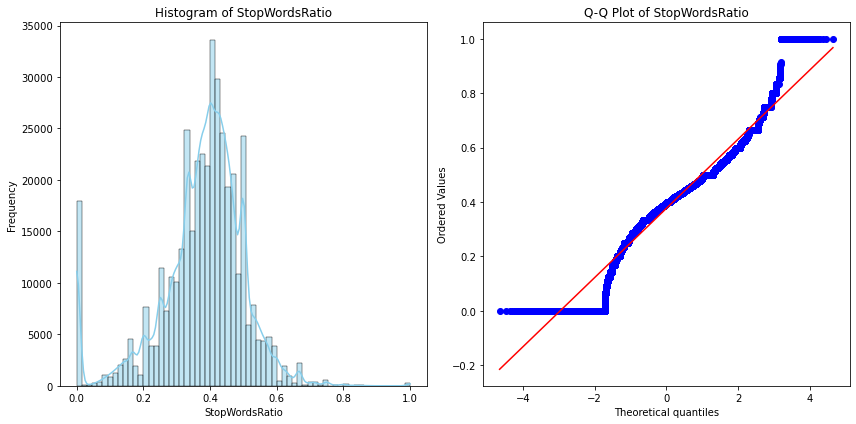

In [388]:


def check_normality(data):
    # If the input is a pandas Series, wrap it in a DataFrame for consistency
    if isinstance(data, pd.Series):
        data = data.to_frame()
    
    for column in data.select_dtypes(include=['float', 'int']).columns:
        column_data = data[column].dropna()  # Drop missing values
        
        # Perform Shapiro-Wilk test
        stat, p_value = shapiro(column_data)
        
        # Determine normality based on p-value
        if p_value > 0.05:
            normality_result = "follows a normal distribution"
        else:
            normality_result = "does NOT follow a normal distribution"
        
        # Print the result
        print(f"{column}: {normality_result} (p-value = {p_value:.4f})")
        
        # Visualization
        plt.figure(figsize=(12, 6))
        
        # Plot Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(column_data, kde=True, color='skyblue', bins=65)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        # Plot Q-Q Plot
        plt.subplot(1, 2, 2)
        probplot(column_data, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {column}')
        
        plt.tight_layout()
        plt.show()

# checking a single column:
check_normality(X_train["StopWordsRatio"])

# or whole dataframe
#check_normality(X_train["capital_to_lowercase_ratio"])

In [ ]:
# Define helper functions for effect size
def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / (np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2))

# Exclude unwanted columns and select generated features
excluded_columns = {
    "ID_Post", "ID_Parent_Post", "ID_Article", "ID_User", "CreatedAt", "article_post_count", 
    "Status",  "Path", "publishingDate", "Title", "Subtitle", "ArticleText",
    "publication_time", "publication_rank",
    "ArticleTitle", "ArticleFullText", "ArticleBody", "Headline", "Body", "IsReply",
    "FullText", "CleanedText", "rank_interval", "initial_interval", "RankingOrder", "MainTopicPath", "level_2",
}

generated_features = [col for col in X_train.columns if col not in excluded_columns]

target_variable = "PostEngagementTopFlop10"

# Merge the features and target into a single DataFrame
df = X_train[generated_features].copy()
df[target_variable] = y_train[target_variable].copy().to_list()
df = df[df[target_variable] != 'undetermined']

# Map PostEngagement to binary (1 = "engaging post", 0 = "regular post")
df['PostEngagement_Binary'] = df[target_variable].map({'regular post': 0, 'engaging post': 1})

# Calculate means for both classes (raw, unscaled data) before scaling
mean_class_0 = df[df[target_variable] == 'regular post'][generated_features].mean()
mean_class_1 = df[df[target_variable] == 'engaging post'][generated_features].mean()

# Initialize the scaler
scaler = MinMaxScaler()
# Scale all features before starting the loop
# Log-transform features with a shift to handle negative values
df[generated_features] = df[generated_features].apply(lambda x: np.log(x - np.min(x) + 1))  # Shift to avoid log(0)
df[generated_features] = scaler.fit_transform(df[generated_features])
#df = df.round(5)

df.fillna(0, inplace=True)

# Initialize a list to store the analysis results
results = []

# Filter the DataFrame for 'regular post' and 'engaging post' after scaling
regular_posts = df[df[target_variable] == 'regular post']
engaging_posts = df[df[target_variable] == 'engaging post']

# Wrap the loop with tqdm to track progress
for feature in tqdm(generated_features, desc="Testing features for relevance", unit="feature"):
    
    # Calculate the absolute and relative differences (based on scaled data)
    abs_diff = abs(mean_class_1[feature] - mean_class_0[feature])
    rel_diff = abs_diff / np.mean([mean_class_0[feature], mean_class_1[feature]]) if mean_class_0[feature] != 0 and mean_class_1[feature] != 0 else 0

    # Perform statistical tests using scaled data
    #t_stat, p_value_ttest = ttest_ind(regular_posts[feature], 
     #                                 engaging_posts[feature], equal_var=False)
    u_stat, p_value_mannwhitney = mannwhitneyu(regular_posts[feature], 
                                               engaging_posts[feature])

    # Calculate effect size (Cohen's d)
    d_value = cohen_d(regular_posts[feature], engaging_posts[feature])

    # Calculate the point-biserial correlation using the scaled data
    correlation, p_value_correlation = pointbiserialr(df['PostEngagement_Binary'], df[feature])
    correlation_direction = 'Positive' if correlation > 0 else 'Negative'

    # Determine significance based on the Mann-Whitney p-value
    significance = 'Y' if (p_value_mannwhitney < 0.05 and p_value_correlation < 0.05)  else 'N'

    # Append results for the current feature
    results.append({
        'Feature': feature,
        'S': significance,
        'Correlation': correlation,
        'Correlation_Direction': correlation_direction,
        'RegularPostMean': mean_class_0[feature],
        'EngagingPostMean': mean_class_1[feature],
        'Abs_Diff': abs_diff,
        'Rel_Diff': rel_diff,
        #'TTest_PValue': p_value_ttest,
        'Correlation_PValue': p_value_correlation,
        'MannWhitney_PValue': p_value_mannwhitney,
        '|Cohen_D|': abs(d_value),
    })

# Convert results to a DataFrame
analysis_df = pd.DataFrame(results)

# Rank features based on various metrics
analysis_df['Rank_Abs_Diff'] = analysis_df['Abs_Diff'].rank(ascending=False)
analysis_df['Rank_Rel_Diff'] = analysis_df['Rel_Diff'].rank(ascending=False)
analysis_df['Rank_PValue'] = analysis_df['MannWhitney_PValue'].rank()  
analysis_df['Rank_PValue_C'] = analysis_df['Correlation_PValue'].rank()
analysis_df['Rank_Cohen_D'] = analysis_df['|Cohen_D|'].rank(ascending=False)

# Sort by composite rank
analysis_df['Composite_Rank'] = analysis_df[['Rank_PValue', 'Rank_PValue_C']].sum(axis=1)
analysis_df_sorted = analysis_df.sort_values(by=['S', 'Composite_Rank', '|Cohen_D|'], ascending=[False, True, False])


# Optional: Correlation analysis (if needed)
# correlation_matrix = df[generated_features].corr()


In [426]:
# Apply the replacement only to numeric columns
numeric_columns = analysis_df_sorted.select_dtypes(include=['number']).columns
analysis_df_sorted[numeric_columns] = analysis_df_sorted[numeric_columns].applymap(lambda x: 0 if 0 < x < 0.00001 else x)
analysis_df_sorted = analysis_df_sorted.round(5)

In [427]:
# Set display option to show all rows
pd.set_option('display.max_rows', None)

output_features = ["Feature", "RegularPostMean", "EngagingPostMean",  "Correlation", 
                   'Correlation_PValue', "MannWhitney_PValue","|Cohen_D|", "Significance"]

# Print all entries of the value counts
#analysis_df_sorted[analysis_df_sorted["Feature"].str.startswith("TFIDF_")][output_features]
#analysis_df_sorted[analysis_df_sorted["Feature"].str.startswith("NGRAM_")][output_features]
#analysis_df_sorted[analysis_df_sorted["Feature"].str.startswith("NE_")][output_features].shape
#analysis_df_sorted[~analysis_df_sorted["Feature"].str.startswith(("NGRAM", "TFIDF", "NE_"))][output_features]
#analysis_df_sorted[analysis_df_sorted["Feature"].str.contains(("Score"))][output_features]


# Reset display option to default (if needed)
#pd.reset_option('display.max_rows')
#analysis_df_sorted[output_features]

In [437]:
def plot_top_correlations(data, output_path="top_correlations.png", top_n=15, only_positive=False, only_negative=False):
    """
    Plots the top correlations with optional filtering for positive or negative correlations.
    
    Parameters:
        data (DataFrame): The input data containing features and correlations.
        output_path (str): Path to save the plot.
        top_n (int): Number of top features to display.
        filter_type (str): 'positive', 'negative', or None for no filtering.
    """
    # Apply filtering based on the filter_type
    if only_positive:
        data = data[data["Correlation"] > 0]
    else:
        pass
    if only_negative:
        data = data[data["Correlation"] < 0]
    else:
        pass

    # Select the top N based on absolute correlation values
    sorted_data = data.reindex(data["Correlation"].abs().sort_values(ascending=False).index).head(top_n)
    sorted_features = sorted_data["Feature"]
    sorted_correlations = sorted_data["Correlation"]

    # Set plot style
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create the bar chart with gray bars
    ax.barh(sorted_features, sorted_correlations, color='#D3D3D3', edgecolor='black')

    # Invert y-axis for descending order
    ax.invert_yaxis()

    # Label axes and add title
    title_prefix = "Top Positive" if only_positive == 'positive' else "Top Negative" if only_negative == 'negative' else "Top"
    ax.set_xlabel("Correlation", fontsize=20, fontweight="bold")
    ax.set_title(f"{title_prefix} {top_n} Negative Feature with Engagement", fontsize=24, fontweight="bold")

    # Adjust tick parameters
    ax.tick_params(axis='y', labelsize=18)  # Larger font for feature names
    ax.tick_params(axis='x', labelsize=18)  # Larger font for correlation values

    # Add gridlines and adjust border
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)

    # Save the plot
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Correlation plot saved as: {output_path}")

    # Show the plot
    plt.show()

In [685]:
#df_merged.drop(columns=["article_vote_min", "article_vote_max"], inplace=True)

Correlation plot saved as: ./figures/top_15_negative_correlations.png


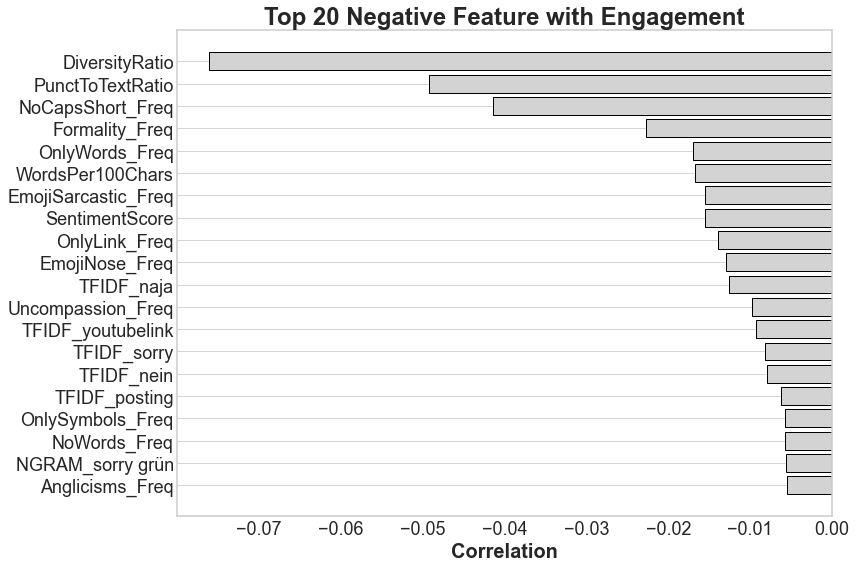

In [435]:


# Example usage
plot_top_correlations(analysis_df_sorted[output_features], 
                      output_path="./figures/top_15_negative_correlations.png", top_n=20, only_negative=True)


Correlation plot saved as: ./figures/top_15_correlations.png


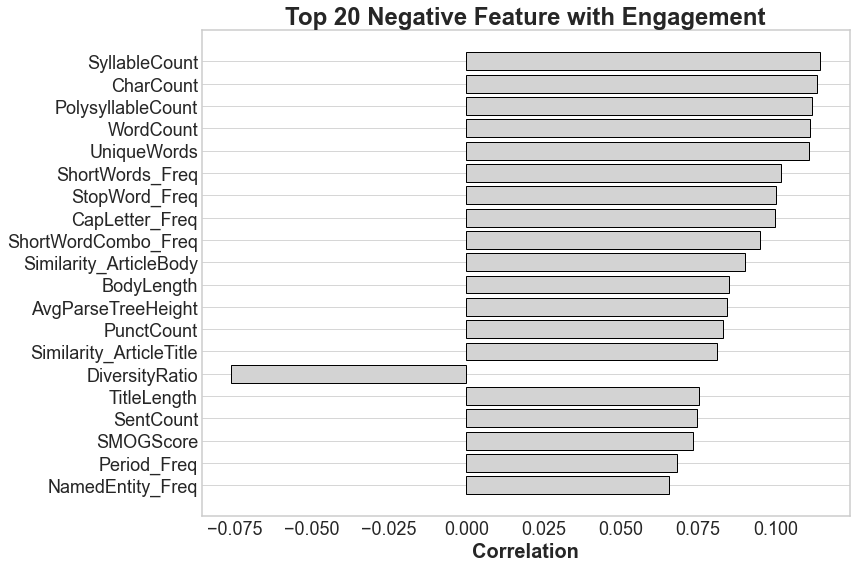

In [438]:
# Example usage
plot_top_correlations(analysis_df_sorted[output_features], 
                      output_path="./figures/top_15_correlations.png", top_n=20)

In [735]:
# Create the new feature by summing across those columns
df_merged['NamedEntity_Freq'] = df_merged.filter(regex='^NE_').sum(axis=1)

In [736]:
df_merged[df_merged["StronglyPositive"] == 1][['FullText', 'SentimentScore']].tail(20).style

,FullText,SentimentScore
512019,nicht nur...,0.947665
512033,"Hoffnung Vielleicht gibt es einmal nur mehr Trolle, Nazis und Idioten auf faecebook. Vielleicht kann diese Pest so bekaempft werden. Das wuerde mich freuen.",0.918508
512090,"guter Kommentar... ... und es liegt an jedem Einzelnen, Schwachsinn an seiner Verbreitung zu hindern!",0.986140
512160,"Das Mediennetzwerk der FPÖ ist beeindruckend. Und ja, darüber ist Aufregung angebracht. Denn das FPÖ-""Hate-Book"" wird von der Partei selbst gesteuert. Nach dem öffentlichen Aufruf Straches an seine Fans, sich zu mäßigen, hat er selbst täglich weitere Beiträge zum Thema Wahlmanipulation gepostet, dem Bundeskanzler unterstellt, keine demokratische Legitimation zu haben u.s.w. Dass sich eine Parlamentspartei öffentlich derart ""gebärden"" kann, halte ich für mehr als bedenklich. Eine sehr gute Zusammenfassung: http://www.profil.at/oesterreich/fpoe-strache-internet-tag-tag-propagandastueck-6378335",0.987105
512203,http://www.redrevolution.at/ https://roteantifawien.wordpress.com/ http://www.rkob.net/ https://twitter.com/antifa_w Eine Perle nach der anderen. https://twitter.com/antifa_w/status/722475580659253251 Viel Spaß.,0.998580
512212,viel spaß wenn dieser pöbel einmal an der macht ist ...,0.991322
512229,Der Vergleich mit der Raumfahrt ist super! Danke Ihnen :-),0.987295
512256,"vor allem im ""Standarte""",0.992398
512261,"Sehr nett Plage mich da mit dem Handy, sie zu verteidigen und sie verarschen mich. Danke",0.956373
512271,Sehr gut auf den Punkt gebracht.,0.999595


In [737]:
df_merged[df_merged["StronglyNegative"] == 1][['FullText', 'SentimentScore']].tail().style

,FullText,SentimentScore
512470,"Hans Rauscher hat nicht verstanden. Die FPÖ nicht und auch nicht die Wut vieler Österreicherinnen und Österreicher. Schade eigentlich. Wut? Stülpt sich einer den vollen Nachttopf über den Kopf, dass ihm die braune Sosse übers Gesicht läuft und knurrt wutentbrannt: ""Denen hab ich´s aber jetzt gezeigt!""",0.008442
512471,"diese unglaubliche Inkompetenz, die in den verantwortlichen Stellen dieses Landes offenbar herrscht - Die Geschichten vom ""Wahlbetrug"" haben auch ""manche Medien"" genüßlich angeheizt und stark übertrieben. 1. So riesenhafte Irrtümer großen Ausmaßes sind das nicht - selbst wenn diese ""zu früh"" ausgezählten Stimmen abgezählt würden, erreichen sie nicht einmal zur Hälfte den knappen Vorsprung VdBs Deswegen wird der Verfassungsgerichtshof die Wahl nicht aufheben und könnte die F-Partei nur mit 3-wöchiger Frist ihren Herrn Hofer als dritten (Nationalrats-)Präsidenten interimistisch regieren lassen. 2. Das ist doch das Entscheidende: die Irrtümer sind alle aufgekommen! Nicht unter den Tisch gekehrt oder versteckt worden. 3. Ich meine, so genau wie bei dieser Stichwahl haben sich die Betreffenden selten auf die Finger geschaut und ist selten so penibel gearbeitet worden. (Menschen sind keine Maschinen - und da gibts noch schlimmere Irrtümer.)",0.001339
512474,"Die Stromhexe ist ja weidlich dafür bekannt,das sie in diversen ORF Foren ihre Kommentare absondert,und zwar ganz ganz seltsame,Man möge sich ein Bild davon machen,und auch Tina P sie ist ja sehr bekannt in der Esoterikszene,oder heißt das jetzt Erotizszene,na gut was solls,HC Strache hat immerhin 6000euro dafür geblecht,ob er selber oder doch die Parteikasse entzieht sich meiner Kenntnis. Jo mei,als ein strammer Rechter Politiker da kann man sowas schon gebrauchen,Schutz von der Erotikszene,oder doch nicht?",0.000763
512475,"Stimmt. Aber Rechte, die nicht unters Wiederbetätigungsgesetz fallen, und Rechte die eben oft nicht erkannt werden bzw. wo die Verfolger von Hasspostings nicht so genau hinschauen.",0.002702
512479,"Das ist sowohl auf die FPÖ, als auch auf den intoleranten Teil der muslimischen Community (insbesondere jenen Teil, der Erdogan zujubelt) anwendbar. Aber noch einmal: Was machen Sie angesichts einer ewigen Koalition und eines proportionalen Wahlrechts (das aber mehr Vor- als Nachteile hat), um den eigentlich demokratieimmanenten Wechsel herbeizuführen? Wie gesagt, ich selbst würde nicht FPÖ wählen, bringe aber Verständnis für jene auf, die die FPÖ als Vehikel des Wechsels sehen. Ich weiß, dass ich da inkonsequent bin. Aber die FPÖ selbst, so furchtbar sie ist, scheint mir an der ""So kann's nicht weitergehen""-Stimmung nicht schuld zu sein: Sie nützt sie weidlich aus und profitiert von ihr.",0.014694


In [475]:
def dataframe_to_latex_with_boundaries(df, filter_condition, output_features, caption, label, max_rows=20):
    """
    Converts a filtered DataFrame to LaTeX, ensuring it includes the first 5 and last 5 rows 
    and a placeholder row ("...") for omitted rows in the middle.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - filter_condition (pd.Series): A boolean condition to filter the DataFrame 
                                     (e.g., df["Feature"].str.startswith('NE_')).
    - output_features (list): The columns to include in the LaTeX table.
    - caption (str): Caption for the LaTeX table.
    - label (str): Label for the LaTeX table.
    - max_rows (int): Maximum number of rows to fit on one page.

    Returns:
    - str: LaTeX table as a string.
    """
    # Filter the DataFrame based on the condition
    filtered_df = df[filter_condition][output_features]
    
    # Apply formatting to numeric columns
    numeric_columns = filtered_df.select_dtypes(include=['number']).columns
    filtered_df[numeric_columns] = filtered_df[numeric_columns].applymap(
        lambda x: f"{0 if 0 < x < 0.001 else x:.3f}"
    )

    # Determine number of rows to display
    num_rows = len(filtered_df)
    if num_rows <= max_rows:
        latex_df = filtered_df
    else:
        first_part = filtered_df.iloc[:5]
        last_part = filtered_df.iloc[-5:]
        remaining_rows = max_rows - len(first_part) - len(last_part)

        if remaining_rows > 0:
            additional_rows = filtered_df.iloc[5 : (5 + remaining_rows)]
            latex_df = pd.concat([first_part, additional_rows, last_part])
        else:
            latex_df = pd.concat([first_part, last_part])

        # Insert placeholder row
        placeholder_row = pd.DataFrame([["..." for _ in output_features]], columns=output_features)
        latex_df = pd.concat([first_part, additional_rows, placeholder_row, last_part])

    # Convert to LaTeX
    latex_code = latex_df.to_latex(index=False, caption=caption, label=label, longtable=True, escape=False)
    latex_code = latex_code.replace("NE_", "").replace("TFIDF_", "").replace("NGRAM_", "").replace("_", "")
    latex_code = latex_code.replace("MannWhitneyPValue", "\makecell{PValue\\\MannW.}")
    latex_code = latex_code.replace("CorrelationPValue ", "\makecell{PValue\\\Corr.}")
    latex_code = re.sub(r"0\.0+ *&", "<0.001 &", latex_code)
    latex_code = latex_code.replace("RegularPostMean", "\makecell{Mean\\\Regular}")
    latex_code = latex_code.replace("EngagingPostMean", "\makecell{Mean\\\Engaging}")
    latex_code = latex_code.replace("frequency", "freq.")

    print(latex_code)

# Example Usage
output_features = ["Feature", "RegularPostMean", "EngagingPostMean", "Correlation", 
                   "Correlation_PValue", "MannWhitney_PValue", "|Cohen_D|", "S"]

dataframe_to_latex_with_boundaries(
    df=analysis_df_sorted,
    filter_condition=analysis_df_sorted["Feature"].str.startswith("NE_"),
    output_features=output_features,
    caption="Comparison of Named Entity Features Between Classes",
    label="tab:ne_features",
    max_rows=20
)


\begin{longtable}{llllllll}
\caption{Comparison of Named Entity Features Between Classes}
\label{tab:nefeatures}\\
\toprule
      Feature & \makecell{Mean\\Regular} & \makecell{Mean\\Engaging} & Correlation & \makecell{PValue\\Corr.}& \makecell{PValue\\MannW.} & |CohenD| &   S \\
\midrule
\endfirsthead
\caption[]{Comparison of Named Entity Features Between Classes} \\
\toprule
      Feature & \makecell{Mean\\Regular} & \makecell{Mean\\Engaging} & Correlation & \makecell{PValue\\Corr.}& \makecell{PValue\\MannW.} & |CohenD| &   S \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
Österreich &           0.036 &            0.074 &       0.034 &              <0.001 &              <0.001 &     0.159 &   Y \\
    Europa &           0.010 &            0.027 &       0.027 &              <0.001 &              <0.001 &     0.125 &   Y \\
       FPÖ &           0.012 &            0.027 &       0.022 &              <0.001 &     

In [476]:
dataframe_to_latex_with_boundaries(
    df=analysis_df_sorted,
    filter_condition=analysis_df_sorted["Feature"].str.startswith("TFIDF_"),
    output_features=output_features,
    caption="Comparison of TFIDF vectors Between Classes",
    label="tab:tfidf_features",
    max_rows=20
)



\begin{longtable}{llllllll}
\caption{Comparison of TFIDF vectors Between Classes}
\label{tab:tfidffeatures}\\
\toprule
             Feature & \makecell{Mean\\Regular} & \makecell{Mean\\Engaging} & Correlation & \makecell{PValue\\Corr.}& \makecell{PValue\\MannW.} & |CohenD| &   S \\
\midrule
\endfirsthead
\caption[]{Comparison of TFIDF vectors Between Classes} \\
\toprule
             Feature & \makecell{Mean\\Regular} & \makecell{Mean\\Engaging} & Correlation & \makecell{PValue\\Corr.}& \makecell{PValue\\MannW.} & |CohenD| &   S \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
       endlich &           0.003 &            0.010 &       0.027 &              <0.001 &              <0.001 &     0.115 &   Y \\
    österreich &           0.011 &            0.020 &       0.023 &              <0.001 &              <0.001 &     0.111 &   Y \\
          jahr &           0.014 &            0.024 &       0.023 &              

In [477]:

dataframe_to_latex_with_boundaries(
    df=analysis_df_sorted,
    filter_condition=analysis_df_sorted["Feature"].str.startswith("NGRAM_"),
    output_features=output_features,
    caption="Comparison of NGRAM Features Between Classes",
    label="tab:ngram_features",
    max_rows=20
)




\begin{longtable}{llllllll}
\caption{Comparison of NGRAM Features Between Classes}
\label{tab:ngramfeatures}\\
\toprule
                   Feature & \makecell{Mean\\Regular} & \makecell{Mean\\Engaging} & Correlation & \makecell{PValue\\Corr.}& \makecell{PValue\\MannW.} & |CohenD| &   S \\
\midrule
\endfirsthead
\caption[]{Comparison of NGRAM Features Between Classes} \\
\toprule
                   Feature & \makecell{Mean\\Regular} & \makecell{Mean\\Engaging} & Correlation & \makecell{PValue\\Corr.}& \makecell{PValue\\MannW.} & |CohenD| &   S \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
       einfach nicht &           0.002 &            0.006 &       0.013 &              <0.001 &              <0.001 &     0.063 &   Y \\
           seit jahr &           0.003 &            0.006 &       0.010 &              <0.001 &              <0.001 &     0.050 &   Y \\
       saudi arabien &           <0.001 &            0.

In [478]:
dataframe_to_latex_with_boundaries(
    df=analysis_df_sorted,
    filter_condition=~analysis_df_sorted["Feature"].str.startswith(("NGRAM", "TFIDF", "NE_")),
    output_features=output_features,
    caption="Comparison of Rule Based Features Between Classes",
    label="tab:rulebased_features",
    max_rows=200
)

\begin{longtable}{llllllll}
\caption{Comparison of Rule Based Features Between Classes}
\label{tab:rulebasedfeatures}\\
\toprule
                Feature & \makecell{Mean\\Regular} & \makecell{Mean\\Engaging} & Correlation & \makecell{PValue\\Corr.}& \makecell{PValue\\MannW.} & |CohenD| & S \\
\midrule
\endfirsthead
\caption[]{Comparison of Rule Based Features Between Classes} \\
\toprule
                Feature & \makecell{Mean\\Regular} & \makecell{Mean\\Engaging} & Correlation & \makecell{PValue\\Corr.}& \makecell{PValue\\MannW.} & |CohenD| & S \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
          SyllableCount &          43.684 &           73.822 &       0.114 &              <0.001 &              <0.001 &     0.667 & Y \\
              CharCount &         167.886 &          281.602 &       0.113 &              <0.001 &              <0.001 &     0.662 & Y \\
            UniqueWords &          22.568 &      

In [666]:
dataframe_to_latex_with_boundaries(
    df=analysis_df_sorted,
    filter_condition=analysis_df_sorted["Feature"].str.contains("Score"),
    output_features=output_features,
    caption="Comparison of Rule Based Features Between Classes",
    label="tab:rulebased_features",
    max_rows=200
)

\begin{longtable}{lrrrrr}
\caption{Comparison of Rule Based Features Between Classes}
\label{tab:rulebasedfeatures}\\
\toprule
        Feature &  \makecell{Mean\\RegularPost} &  \makecell{Mean\\EngagingPost} &  Correlation &  \makecell{PValue\\MannW.} &  |CohenD| \\
\midrule
\endfirsthead
\caption[]{Comparison of Rule Based Features Between Classes} \\
\toprule
        Feature &  \makecell{Mean\\RegularPost} &  \makecell{Mean\\EngagingPost} &  Correlation &  \makecell{PValue\\MannW.} &  |CohenD| \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
       ARIScore &         16.81312 &          16.02962 &      0.04057 &                 <0.00001 &    0.22713 \\
      SMOGScore &          4.83882 &           5.41477 &      0.05624 &                 <0.00001 &    0.34557 \\
 SentimentScore &          0.34875 &           0.32992 &     -0.01473 &                 <0.00001 &    0.06304 \\
FleschEaseScore &         32.79643 &  

#### Step 3.8: Remove non significant Features

In [ ]:
# Define the columns to exclude based on significance and column name condition
not_significant_features = analysis_df_sorted.loc[
    (analysis_df_sorted["Significance"] == "Not Significant") & 
    (~analysis_df_sorted["Feature"].isin(['article_post_count'])), 
    "Feature"
].tolist()

# Drop the not significant features from X_train and X_test
#X_train.drop(columns=not_significant_features, inplace=True, errors="ignore")
#X_test.drop(columns=not_significant_features, inplace=True, errors="ignore")

### Step 2.9: Export Data

In [433]:
#X_train.to_pickle("./data/X_train.pkl")
#X_test.to_pickle("./data/X_test.pkl")
#y_train.to_pickle("./data/y_train.pkl")
#y_test.to_pickle("./data/y_test.pkl")
df_merged.to_pickle("./data/df_merged.pkl")

In [2]:
X_train = pd.read_pickle("./data/X_train.pkl")
X_test = pd.read_pickle("./data/X_test.pkl")
y_train = pd.read_pickle("./data/y_train.pkl")
y_test = pd.read_pickle("./data/y_test.pkl")
df_merged = pd.read_pickle("./data/df_merged.pkl")

#### Further Analysis

In [3]:
df_merged[df_merged["IsReply"] == 1]["UpVotes"].mean()

3.4466571973698326

In [4]:
df_merged[df_merged["IsReply"] == 0]["UpVotes"].mean()

10.31635102205339

In [76]:
# Filter the DataFrame where FullText length is less than 5 and Upvotes is greater than 10
df_merged[(df_merged["FullText"].str.len() < 10) & (df_merged["UpVotes"] > 10) & (~df_merged["ID_Parent_Post"].isna())
         ][["ID_Post", "FullText","ID_Parent_Post", "UpVotes"]].head(100).style


,ID_Post,FullText,ID_Parent_Post,UpVotes
295,99614,T1 auch!,99610.000000,22
1246,580612,Gähn ...,580609.000000,12
2101,843518,OHHH! :o,843512.000000,19
2261,38682,6 euro,38675.000000,14
2479,37028,Russin?,37024.000000,12
2940,143965,ja.,143959.000000,26
6013,357744,Hi!,357710.000000,21
8553,463845,Ubuntu!,463839.000000,13
10063,813754,und?,813726.000000,16
11905,995801,Hey bro,995790.000000,12


In [84]:
df_merged[(df_merged["ID_Post"] == 75029)| (df_merged["ID_Post"] == 75027)][
    ["ID_Post", "FullText","ID_Parent_Post",  "UpVotes"]].style

,ID_Post,FullText,ID_Parent_Post,UpVotes
177284,75027,"Unterirdischer Artikel von derstandard.at... da man hier jetzt anscheinend auf OE24 Niveau angekommen ist, ist es Zeit das Online Medium zu wechseln.",nan,1
245120,75029,Ciao!,75027.000000,14


In [172]:
df_merged[(df_merged["ID_Post"] == 341635) | (df_merged["ID_Post"] == 341651) | (df_merged["ID_Post"] == 341646)][
    ["ID_Post", "FullText","ID_Parent_Post",  "UpVotes", "DownVotes"]].style

,ID_Post,FullText,ID_Parent_Post,UpVotes,DownVotes
57398,341646,feinste Ironie! Bravo,341635.000000,2,35
227216,341635,Ich finde eine Trennung völlig falsch. Das förderteine Bildung von Parallelgesellschften schon ab Aufnahme. Die verschiedenen Kulturen sollen ja auf Dauer miteinander auskommen. Bitte kein falsches Signal zu Beginn! Härtet durchgreifen und Störenfriede gleich zur Rechenschaft ziehen.,nan,75,1
245707,341651,?,341646.000000,11,0


In [41]:
df_merged[(df_merged["ID_Post"] == 472194)| (df_merged["ID_Post"] == 472186)][
    ["ID_Post", "FullText","ID_Parent_Post",  "UpVotes"]].head(50).style

,ID_Post,FullText,ID_Parent_Post,UpVotes
84295,472186,"Ach der heilige Edward, wie kann man nur Kritik an unseren Datenschutzheiligen üben. Kniet nieder, verehrt ihn, baut ihm Denkmäler. Er ist doch unser Schutzheiliger.",nan,0
429175,472194,depp,472186.000000,13


In [24]:
df_merged[df_merged["FullText"] == "Oide!"][["FullText", "ArticleText"]].style

,FullText,ArticleText
236492,Oide!,"Klagenfurter Obmann der Grünen wird eine ""Parteiobfrau"" Die Grünen bezeichnen sich im neuen Statut nur noch mit weiblicher Geschlechtsform"


In [460]:

def create_styled_table(df, output_path, max_width=50, font_size=14, min_text_width=0.15, column_names=None):
    """
    Create a styled table from a DataFrame and save it as an image.
    
    Args:
        df (pd.DataFrame): DataFrame to display in the table.
        output_path (str): File path to save the image.
        max_width (int): Maximum width for text wrapping in cells.
        font_size (int): Font size for the table text.
        min_text_width (float): Minimum width adjustment for columns based on character count.
        column_names (list of str): Custom column names. If None, use the DataFrame's column names.
    """
    # Wrap text in cells
    def wrap_text(text, max_width=max_width):
        """Wrap text to ensure it fits within a maximum width without splitting words."""
        words = str(text).split()
        lines = []
        current_line = []
        current_length = 0

        for word in words:
            if current_length + len(word) + len(current_line) > max_width:
                lines.append(" ".join(current_line))
                current_line = [word]
                current_length = len(word)
            else:
                current_line.append(word)
                current_length += len(word)
        if current_line:
            lines.append(" ".join(current_line))
        return "\n".join(lines)

    # Apply text wrapping to all cells
    df_wrapped = df.applymap(wrap_text)

    # Use custom column names if provided
    if column_names:
        df_wrapped.columns = [wrap_text(name) for name in column_names]
    else:
        df_wrapped.columns = [wrap_text(col) for col in df_wrapped.columns]

    # Calculate total character count for each column
    col_char_counts = df_wrapped.applymap(len).sum(axis=0)
    total_chars = col_char_counts.sum()

    # Calculate column widths based on character proportions
    col_widths = col_char_counts / total_chars + min_text_width

    # Create the figure
    fig, ax = plt.subplots(figsize=(14, 2 + len(df_wrapped) * 0.5))  # Dynamic height adjustment
    ax.axis("off")  # Remove axes

    # Create a styled table
    table = Table(ax, bbox=[0, 0, 1, 1])
    n_rows, n_cols = df_wrapped.shape

    # Add header cells with consistent style
    header_color = "#D3D3D3"  # Light gray
    text_color = "black"
    for col_idx, column_name in enumerate(df_wrapped.columns):
        cell = table.add_cell(
            0, col_idx, width=col_widths[col_idx], height=0.4,
            text=column_name, loc="center",
            facecolor=header_color, edgecolor="black"
        )
        cell.get_text().set_color(text_color)
        cell.get_text().set_weight("bold")
        cell.set_linewidth(1.5)  # Set consistent border thickness

    # Add data cells with consistent edges and text wrapping
    for row_idx, row in enumerate(df_wrapped.itertuples(index=False), start=1):
        for col_idx, cell_value in enumerate(row):
            cell = table.add_cell(
                row_idx, col_idx, width=col_widths[col_idx], height=0.4,
                text=str(cell_value), loc="left",
                facecolor="white", edgecolor="black"
            )
            cell.set_linewidth(1.0)  # Set consistent border thickness

    # Adjust font size and add the table to the plot
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)
    ax.add_table(table)

    # Save the styled table as an image
    plt.savefig(output_path, dpi=900, bbox_inches="tight")
    plt.show()
    print(f"Styled table saved as graphic: {output_path}") 

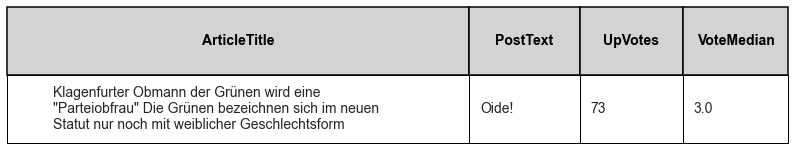

Styled table saved as graphic: ./figures/filtered_dataframe_table_arbitrary_columns.png


In [461]:
# Example usage
df_filtered = df_merged[df_merged["FullText"] == "Oide!"][["ArticleTitle", "FullText", "UpVotes", "article_vote_median"]]
create_styled_table(df_filtered, output_path= "./figures/filtered_dataframe_table_arbitrary_columns.png", max_width=50,  
                    font_size=14, min_text_width=0.25, column_names = [ "ArticleTitle", "PostText", "UpVotes", "VoteMedian"])


In [18]:
df_merged[ "ID_Parent_Post"]

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
471395    1011231.0
471396    1011501.0
471397    1011320.0
471398    1011428.0
471399    1011619.0
Name: ID_Parent_Post, Length: 471400, dtype: float64